In [1]:
import sklearn.preprocessing as preprocess
import numpy as np
import pandas as pd
from keras import optimizers
import keras.layers as kl
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import spacy
from keras.utils import to_categorical
from spacy.lang.en import English
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 1000)
from tqdm import tqdm_notebook
from keras.layers import BatchNormalization, Lambda, Concatenate, Dropout, Conv1D, MaxPooling1D, Input, TimeDistributed, Dense, LSTM, RepeatVector, GlobalAveragePooling1D
from keras.models import Model
import pickle
from datetime import datetime
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from AttentionModules import SelfAttention,CrossAttention
import sys,os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Using TensorFlow backend.


In [2]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
df_hd_tp_cdc = pd.read_csv('evaluation_set/cdc_ibm/headline_topic_mapping.csv')
df_ar_cl_cdc = pd.read_csv('evaluation_set/cdc_ibm/article_claim_mapping.csv')
df_hd_tp_dnf = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50.json')
with open('evaluation_set/cdc_ibm/articles.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/cdc_ibm/article_vectors.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
df_hd_tp_cdc.keys(),df_ar_cl_cdc.keys(), len(articles.keys()), len(article_vectors.keys()), df_hd_tp_dnf.keys()

(Index(['Topic', 'Title', 'article Id', 'Headline'], dtype='object'),
 Index(['Unnamed: 0', 'Topic', 'Article', 'Claim'], dtype='object'),
 522,
 522,
 Index(['authors', 'evidence', 'headline', 'id', 'reason', 'sentences', 'type',
        'urls'],
       dtype='object'))

In [4]:
test_titles = []
for ar in df_ar_cl_cdc.Article.unique():
    if len(df_ar_cl_cdc[df_ar_cl_cdc.Article==ar]['Claim'].values)>8:
        test_titles.append(ar)

In [5]:
0.8*475

380.0

In [6]:
titles = sorted(df_hd_tp_cdc.Title.unique())
non_test_titles = list(set(titles)-set(test_titles))
val_titles = non_test_titles[380:]
train_titles = titles[:380]
len(train_titles),len(val_titles),len(test_titles)

(380, 95, 47)

In [28]:
train_batchsize = 32
val_batchsize = 32
test_batchsize = 50
train_steps_per_epoch = 4
val_steps_per_epoch = 1
epochs = 50000

In [8]:
def load_spacy():
    sentencizer = English()
    sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))
    nlp = spacy.load("en_core_web_md")
    return sentencizer, nlp
sentencizer, nlp = load_spacy()


In [9]:
def datagen_cdc(batchsize,dataframe,mode):
    counter=0
    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds=[],[],[],[],[]
    while True:
        if mode=='train':
            idx=np.random.choice(train_titles)
        elif mode=='val':
            idx=np.random.choice(val_titles)
        elif mode=='test':
            idx=np.random.choice(test_titles)
        hd = dataframe[dataframe.Title==idx]['Headline'].values[0].lower()
        hds.append(hd)
        ar_id = dataframe[dataframe.Title==idx]['article Id'].values[0]
#         cl = dataframe[dataframe.Article==idx]['Claim'].values
#         sentences=articles[ar_id]
#         print(len(sentences))
        sents = np.zeros((1300,300))
        vectors = article_vectors[ar_id]
        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
        counter+=1
        if counter==batchsize:
            inputs = {
                'article_id': np.array(ar_ids)
                ,'headline': np.array(hds)
                ,'sentence_vectors' : np.array(ar_sents)
                ,'input_headline_vector': np.array(ar_head_vectors)
            }
            outputs = {
                'headline_token_classes': np.array(ar_head_classes)
                ,'output_headline_vector': np.array(ar_head_vectors)
            }
            yield inputs,outputs
            ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds=[],[],[],[],[]
            counter=0
            
def datagen_dnf(batchsize,dataframe):
    counter=0
    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds=[],[],[],[],[]
    while True:
        idx=np.random.choice(dataframe.id.nunique())
        hd = dataframe[dataframe.id==idx]['headline'].values[0]
        ar_id = dataframe[dataframe.id==idx]['id'].values[0]
        cl = dataframe[dataframe.id==idx]['sentences'].values[0]
        hds.append(hd)
#         cl = dataframe[dataframe.Article==idx]['Claim'].values
        with open('evaluation_set/deepnofakes/cleaned/article_{0}.txt'.format(ar_id)) as f:
            article = f.readlines()
            
        article=''.join(article)
        # print(article)
        article = article.replace('[REF]','')
        doc = sentencizer(article)
        sentences = [sent.string.strip() for sent in doc.sents]
    
#         print(len(sentences))
        sents = np.zeros((1300,300))
        vectors = []
        for s in sentences:
            vectors.append(nlp(s.lower()).vector)
        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
        counter+=1
        if counter==batchsize:
            inputs = {
                'article_id': np.array(ar_ids)
                ,'headline': np.array(hds)
                ,'sentence_vectors' : np.array(ar_sents)
                ,'input_headline_vector': np.array(ar_head_vectors)
            }
            outputs = {
                'headline_token_classes': np.array(ar_head_classes)
                ,'output_headline_vector': np.array(ar_head_vectors)
            }
            yield inputs,outputs
            ar_ids,ar_sents,ar_head_vectors,ar_head_classes=[],[],[],[]
            counter=0
            

In [10]:
tdg = datagen_cdc(train_batchsize,df_hd_tp_cdc,mode='train')
vdg = datagen_cdc(val_batchsize,df_hd_tp_cdc,mode='val')
test_dg = datagen_cdc(test_batchsize,df_hd_tp_cdc,mode='test')

In [11]:
x,y = next(test_dg)

In [12]:
# x['sentence_vectors'].shape, x['headline_vector'].shape, y['headline_token_classes'].shape

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 1300, 300)    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1300, 16)     14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1300, 16)     0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1300, 32)     1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

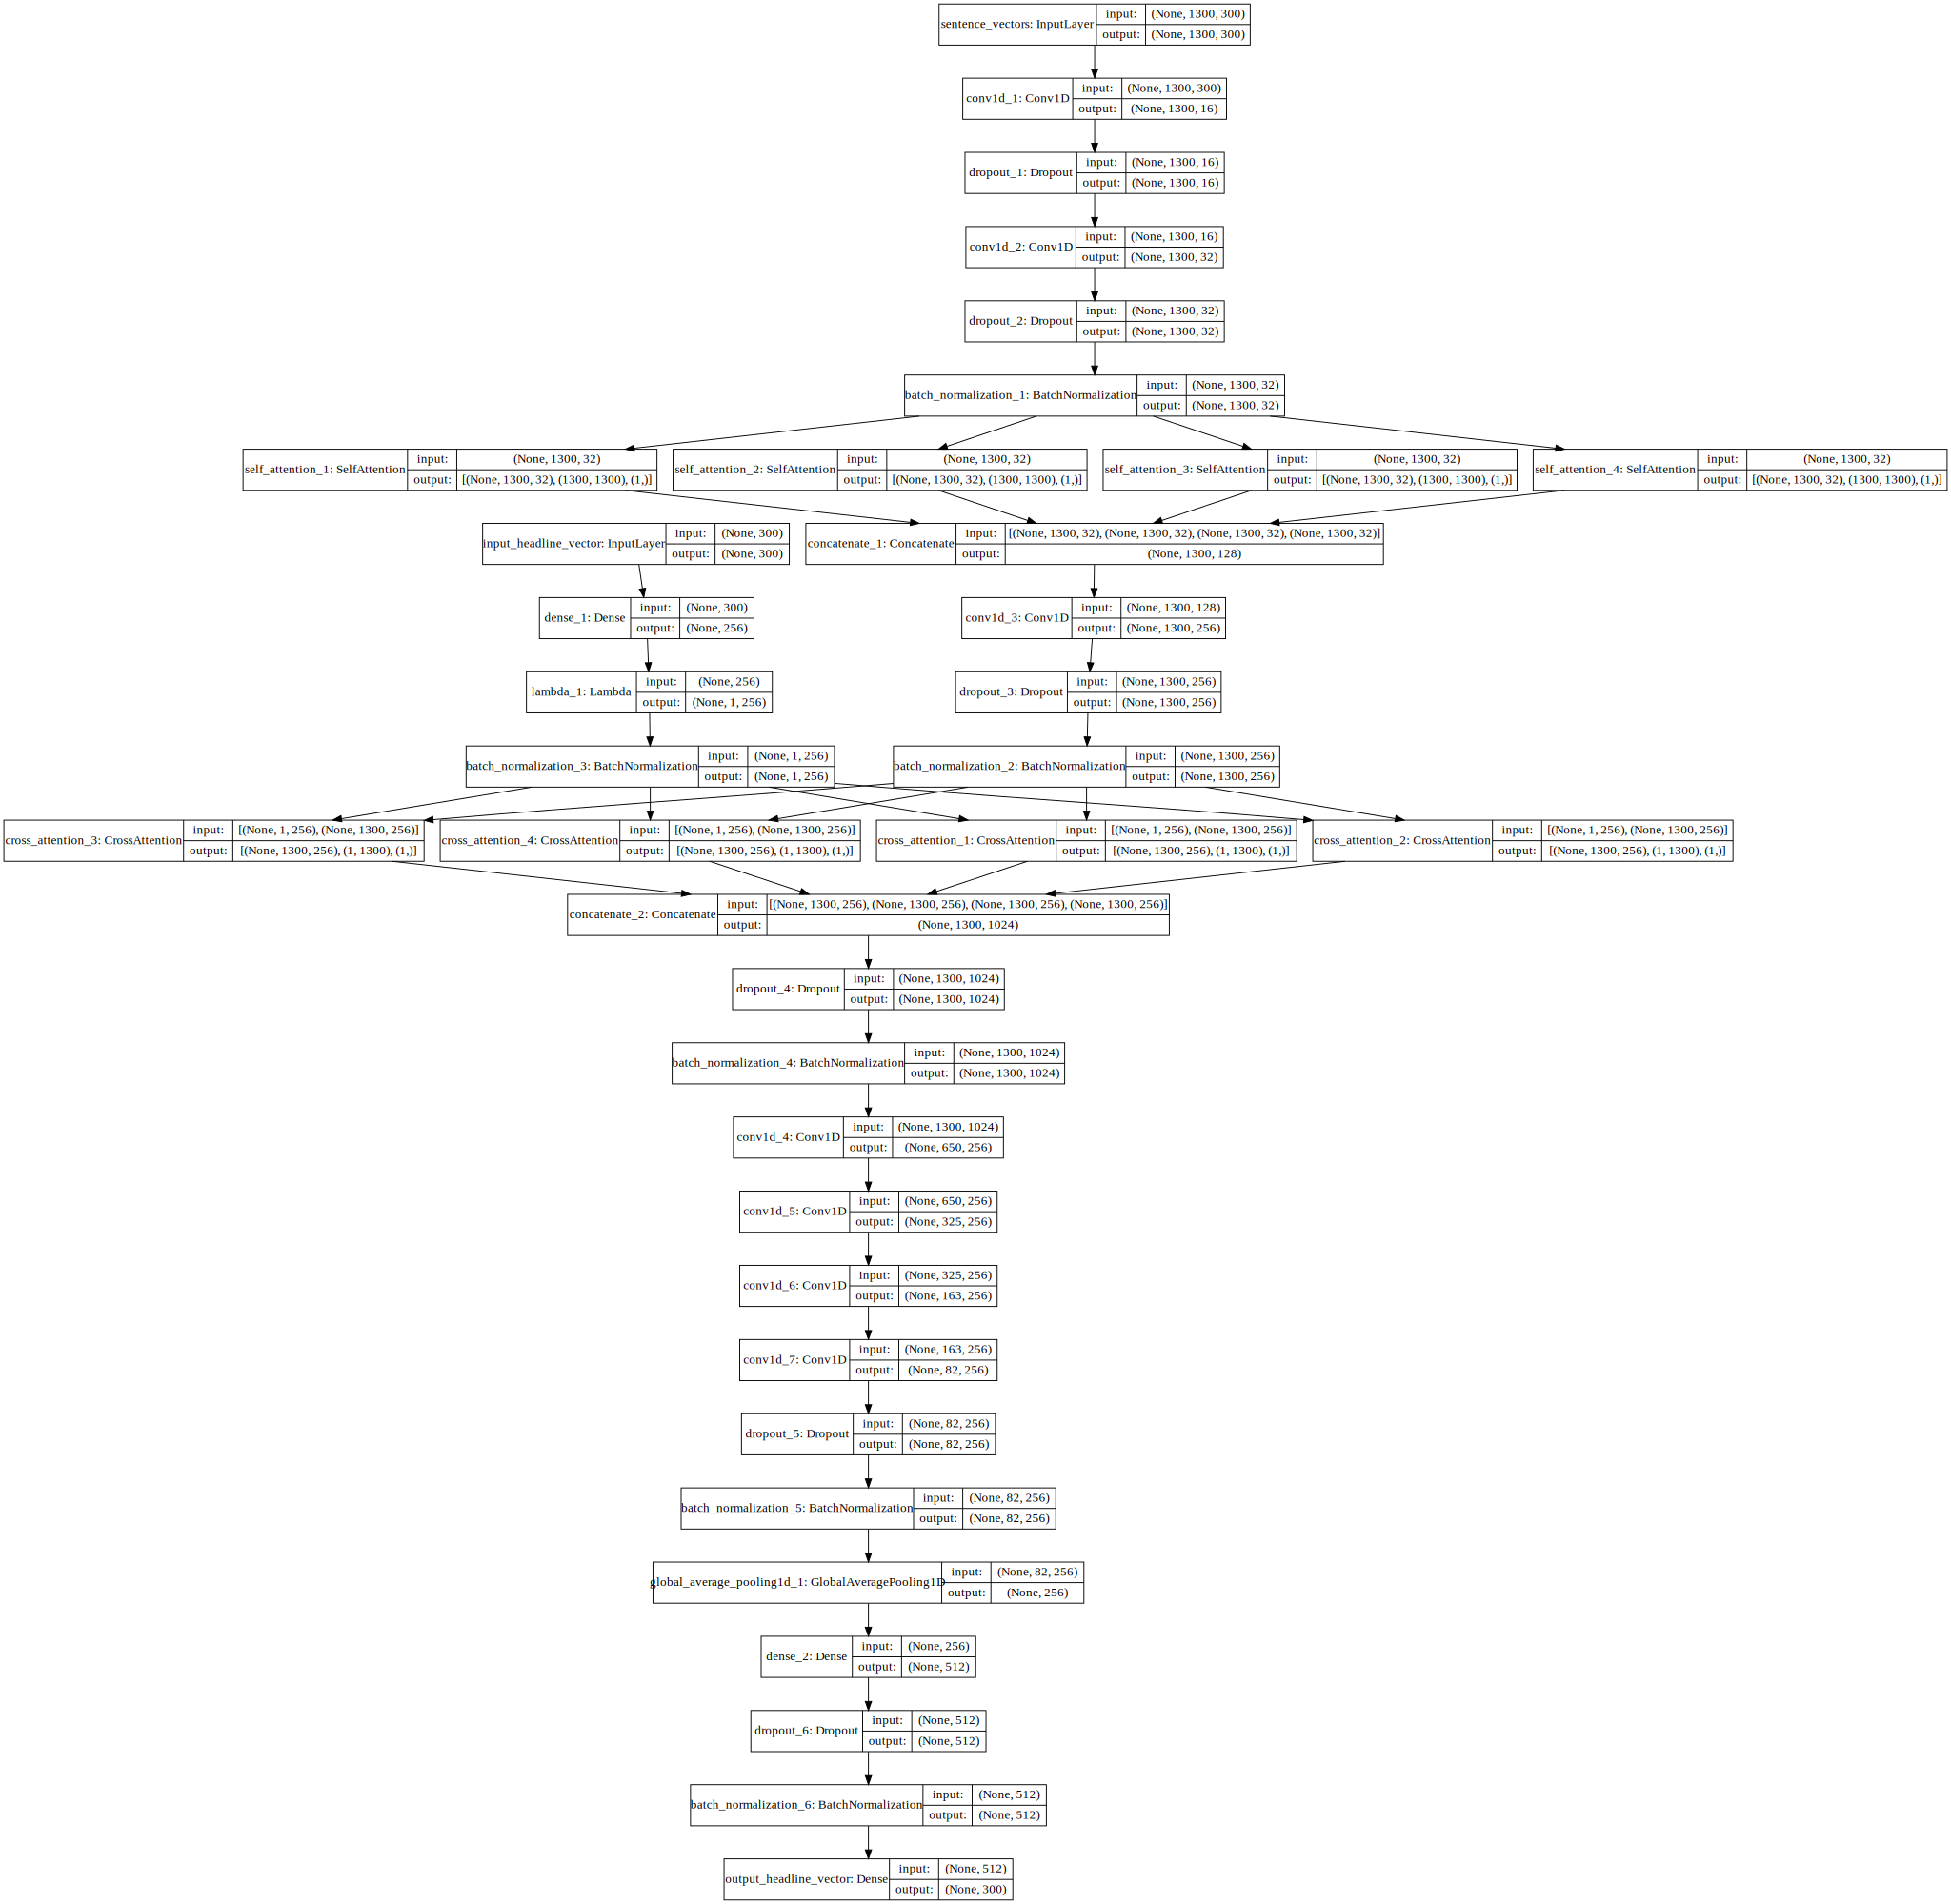

In [13]:
def build_model():
    inp_sentence_vectors = Input(shape=(1300, 300), name='sentence_vectors')
    inp_headline_vector = Input(shape=(300,), name='input_headline_vector')
    conv1 = Conv1D(filters=16,kernel_size=3,strides=1,activation='relu', padding='same')(inp_sentence_vectors)
    conv1 = Dropout(0.5)(conv1)
    conv2 = Conv1D(filters=32,kernel_size=3,strides=1,activation='relu', padding='same')(conv1)
    conv2 = Dropout(0.5)(conv2)
    conv2 = BatchNormalization()(conv2)
    sent_sa_feat_1, sent_beta_1, sent_gamma_1 = SelfAttention(int(conv2.shape[-1]))(conv2)
    sent_sa_feat_2, sent_beta_2, sent_gamma_2 = SelfAttention(int(conv2.shape[-1]))(conv2)
    sent_sa_feat_3, sent_beta_3, sent_gamma_3 = SelfAttention(int(conv2.shape[-1]))(conv2)
    sent_sa_feat_4, sent_beta_4, sent_gamma_4 = SelfAttention(int(conv2.shape[-1]))(conv2)
    concat1 = Concatenate()([sent_sa_feat_1,sent_sa_feat_2,sent_sa_feat_3,sent_sa_feat_4])
    conv3 = Conv1D(filters=256,kernel_size=3, strides=1, activation='relu', padding='same')(concat1)
    conv3 = Dropout(0.5)(conv3)
    conv3 = BatchNormalization()(conv3)
    headline = Dense(256, activation='relu')(inp_headline_vector)
    headline = Lambda(lambda x:K.expand_dims(x, axis=1))(headline)
    headline = BatchNormalization()(headline)
    sent_hd_sa_feat_1, sent_hd_beta_1, sent_hd_gamma_1 = CrossAttention(int(conv3.shape[-1]))([headline,conv3])
    sent_hd_sa_feat_2, sent_hd_beta_2, sent_hd_gamma_2 = CrossAttention(int(conv3.shape[-1]))([headline,conv3])
    sent_hd_sa_feat_3, sent_hd_beta_3, sent_hd_gamma_3 = CrossAttention(int(conv3.shape[-1]))([headline,conv3])
    sent_hd_sa_feat_4, sent_hd_beta_4, sent_hd_gamma_4 = CrossAttention(int(conv3.shape[-1]))([headline,conv3])  
    concat3 = Concatenate()([sent_hd_sa_feat_1,sent_hd_sa_feat_2,sent_hd_sa_feat_3,sent_hd_sa_feat_4])
    concat3 = Dropout(0.5)(concat3)
    concat3 = BatchNormalization()(concat3)
    conv5 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(concat3)
    conv6 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv5)
    conv7 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv6)
    conv8 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv7)
    conv8 = Dropout(0.5)(conv8)
    conv8 = BatchNormalization()(conv8)
    gap = GlobalAveragePooling1D()(conv8)
#     repeat = RepeatVector(50)(gap)
#     lstm = LSTM(256,return_sequences=True)(repeat)
    dense1 = Dense(512,activation='relu')(gap)
    dense1 = Dropout(0.5)(dense1)
    dense1 = BatchNormalization()(dense1)
    gen_hd_vector = Dense(300,activation='linear', name='output_headline_vector')(dense1)
    model = Model([inp_sentence_vectors,inp_headline_vector],gen_hd_vector)
    return model
model = build_model()
model.compile(optimizer=optimizers.Adam(lr=0.0001,beta_1=0.0,beta_2=0.99),loss='mse')
model.summary()
# print('model params:',model.count_params())
SVG(model_to_dot(model,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg'))

In [14]:
dt = datetime.now()
mc = ModelCheckpoint('weights/cdc_sa_sent_hd_vector.hdf5',save_best_only=True,save_weights_only=True)
tb = TensorBoard(batch_size=32,log_dir='logs/cdc_sa_sent_hd_vector/{0}'.format(dt.timestamp()),write_graph=True)

In [29]:
hist = model.fit_generator(tdg, callbacks=[mc,tb], initial_epoch=10000
                           ,steps_per_epoch=train_steps_per_epoch
                           ,validation_data=vdg
                           ,validation_steps=val_steps_per_epoch
                           ,epochs=epochs)

Epoch 10001/50000
4/4 [==============================] - 4s 1s/step - loss: 0.0154 - val_loss: 0.0218
Epoch 10002/50000
4/4 [==============================] - 4s 1s/step - loss: 0.0157 - val_loss: 0.0198
Epoch 10003/50000
4/4 [==============================] - 4s 1s/step - loss: 0.0163 - val_loss: 0.0177
Epoch 10004/50000
4/4 [==============================] - 2s 575ms/step - loss: 0.0161 - val_loss: 0.0153
Epoch 10005/50000
4/4 [==============================] - 3s 631ms/step - loss: 0.0154 - val_loss: 0.0189
Epoch 10006/50000
4/4 [==============================] - 3s 676ms/step - loss: 0.0178 - val_loss: 0.0194
Epoch 10007/50000
4/4 [==============================] - 2s 549ms/step - loss: 0.0156 - val_loss: 0.0157
Epoch 10008/50000
4/4 [==============================] - 3s 634ms/step - loss: 0.0150 - val_loss: 0.0153
Epoch 10009/50000
4/4 [==============================] - 2s 538ms/step - loss: 0.0158 - val_loss: 0.0162
Epoch 10010/50000
4/4 [==============================] - 2s 589m

4/4 [==============================] - 2s 618ms/step - loss: 0.0143 - val_loss: 0.0153
Epoch 10080/50000
4/4 [==============================] - 3s 658ms/step - loss: 0.0157 - val_loss: 0.0184
Epoch 10081/50000
4/4 [==============================] - 3s 696ms/step - loss: 0.0160 - val_loss: 0.0162
Epoch 10082/50000
4/4 [==============================] - 2s 597ms/step - loss: 0.0162 - val_loss: 0.0142
Epoch 10083/50000
4/4 [==============================] - 3s 654ms/step - loss: 0.0157 - val_loss: 0.0155
Epoch 10084/50000
4/4 [==============================] - 3s 667ms/step - loss: 0.0152 - val_loss: 0.0164
Epoch 10085/50000
4/4 [==============================] - 2s 561ms/step - loss: 0.0148 - val_loss: 0.0154
Epoch 10086/50000
4/4 [==============================] - 3s 692ms/step - loss: 0.0156 - val_loss: 0.0167
Epoch 10087/50000
4/4 [==============================] - 2s 606ms/step - loss: 0.0148 - val_loss: 0.0202
Epoch 10088/50000
4/4 [==============================] - 3s 629ms/step - 

4/4 [==============================] - 3s 628ms/step - loss: 0.0152 - val_loss: 0.0198
Epoch 10158/50000
4/4 [==============================] - 2s 604ms/step - loss: 0.0158 - val_loss: 0.0170
Epoch 10159/50000
4/4 [==============================] - 3s 661ms/step - loss: 0.0155 - val_loss: 0.0145
Epoch 10160/50000
4/4 [==============================] - 2s 578ms/step - loss: 0.0154 - val_loss: 0.0149
Epoch 10161/50000
4/4 [==============================] - 2s 545ms/step - loss: 0.0162 - val_loss: 0.0145
Epoch 10162/50000
4/4 [==============================] - 3s 654ms/step - loss: 0.0165 - val_loss: 0.0167
Epoch 10163/50000
4/4 [==============================] - 3s 680ms/step - loss: 0.0163 - val_loss: 0.0164
Epoch 10164/50000
4/4 [==============================] - 2s 603ms/step - loss: 0.0161 - val_loss: 0.0170
Epoch 10165/50000
4/4 [==============================] - 3s 728ms/step - loss: 0.0164 - val_loss: 0.0153
Epoch 10166/50000
4/4 [==============================] - 2s 585ms/step - 

4/4 [==============================] - 2s 580ms/step - loss: 0.0159 - val_loss: 0.0149
Epoch 10236/50000
4/4 [==============================] - 3s 653ms/step - loss: 0.0175 - val_loss: 0.0188
Epoch 10237/50000
4/4 [==============================] - 3s 642ms/step - loss: 0.0164 - val_loss: 0.0155
Epoch 10238/50000
4/4 [==============================] - 3s 698ms/step - loss: 0.0165 - val_loss: 0.0167
Epoch 10239/50000
4/4 [==============================] - 3s 669ms/step - loss: 0.0165 - val_loss: 0.0170
Epoch 10240/50000
4/4 [==============================] - 2s 561ms/step - loss: 0.0164 - val_loss: 0.0174
Epoch 10241/50000
4/4 [==============================] - 3s 724ms/step - loss: 0.0168 - val_loss: 0.0188
Epoch 10242/50000
4/4 [==============================] - 2s 613ms/step - loss: 0.0157 - val_loss: 0.0170
Epoch 10243/50000
4/4 [==============================] - 2s 574ms/step - loss: 0.0174 - val_loss: 0.0183
Epoch 10244/50000
4/4 [==============================] - 3s 673ms/step - 

4/4 [==============================] - 3s 684ms/step - loss: 0.0154 - val_loss: 0.0152
Epoch 10314/50000
4/4 [==============================] - 2s 557ms/step - loss: 0.0169 - val_loss: 0.0137
Epoch 10315/50000
4/4 [==============================] - 3s 657ms/step - loss: 0.0159 - val_loss: 0.0154
Epoch 10316/50000
4/4 [==============================] - 3s 657ms/step - loss: 0.0164 - val_loss: 0.0154
Epoch 10317/50000
4/4 [==============================] - 2s 600ms/step - loss: 0.0156 - val_loss: 0.0162
Epoch 10318/50000
4/4 [==============================] - 3s 738ms/step - loss: 0.0164 - val_loss: 0.0171
Epoch 10319/50000
4/4 [==============================] - 3s 632ms/step - loss: 0.0160 - val_loss: 0.0159
Epoch 10320/50000
4/4 [==============================] - 2s 568ms/step - loss: 0.0164 - val_loss: 0.0160
Epoch 10321/50000
4/4 [==============================] - 3s 650ms/step - loss: 0.0156 - val_loss: 0.0144
Epoch 10322/50000
4/4 [==============================] - 2s 594ms/step - 

4/4 [==============================] - 2s 598ms/step - loss: 0.0150 - val_loss: 0.0143
Epoch 10392/50000
4/4 [==============================] - 3s 689ms/step - loss: 0.0163 - val_loss: 0.0159
Epoch 10393/50000
4/4 [==============================] - 2s 625ms/step - loss: 0.0172 - val_loss: 0.0184
Epoch 10394/50000
4/4 [==============================] - 2s 595ms/step - loss: 0.0161 - val_loss: 0.0176
Epoch 10395/50000
4/4 [==============================] - 3s 638ms/step - loss: 0.0163 - val_loss: 0.0164
Epoch 10396/50000
4/4 [==============================] - 3s 633ms/step - loss: 0.0158 - val_loss: 0.0128
Epoch 10397/50000
4/4 [==============================] - 3s 637ms/step - loss: 0.0158 - val_loss: 0.0153
Epoch 10398/50000
4/4 [==============================] - 3s 761ms/step - loss: 0.0163 - val_loss: 0.0166
Epoch 10399/50000
4/4 [==============================] - 2s 615ms/step - loss: 0.0159 - val_loss: 0.0171
Epoch 10400/50000
4/4 [==============================] - 2s 588ms/step - 

4/4 [==============================] - 2s 622ms/step - loss: 0.0158 - val_loss: 0.0192
Epoch 10470/50000
4/4 [==============================] - 2s 609ms/step - loss: 0.0161 - val_loss: 0.0154
Epoch 10471/50000
4/4 [==============================] - 3s 736ms/step - loss: 0.0156 - val_loss: 0.0161
Epoch 10472/50000
4/4 [==============================] - 2s 579ms/step - loss: 0.0164 - val_loss: 0.0161
Epoch 10473/50000
4/4 [==============================] - 3s 715ms/step - loss: 0.0148 - val_loss: 0.0192
Epoch 10474/50000
4/4 [==============================] - 3s 669ms/step - loss: 0.0168 - val_loss: 0.0156
Epoch 10475/50000
4/4 [==============================] - 2s 596ms/step - loss: 0.0167 - val_loss: 0.0167
Epoch 10476/50000
4/4 [==============================] - 3s 686ms/step - loss: 0.0168 - val_loss: 0.0144
Epoch 10477/50000
4/4 [==============================] - 3s 669ms/step - loss: 0.0155 - val_loss: 0.0165
Epoch 10478/50000
4/4 [==============================] - 2s 595ms/step - 

4/4 [==============================] - 2s 616ms/step - loss: 0.0159 - val_loss: 0.0157
Epoch 10548/50000
4/4 [==============================] - 2s 567ms/step - loss: 0.0156 - val_loss: 0.0134
Epoch 10549/50000
4/4 [==============================] - 3s 626ms/step - loss: 0.0172 - val_loss: 0.0159
Epoch 10550/50000
4/4 [==============================] - 3s 701ms/step - loss: 0.0153 - val_loss: 0.0149
Epoch 10551/50000
4/4 [==============================] - 2s 592ms/step - loss: 0.0160 - val_loss: 0.0157
Epoch 10552/50000
4/4 [==============================] - 2s 589ms/step - loss: 0.0158 - val_loss: 0.0177
Epoch 10553/50000
4/4 [==============================] - 3s 647ms/step - loss: 0.0162 - val_loss: 0.0155
Epoch 10554/50000
4/4 [==============================] - 3s 625ms/step - loss: 0.0162 - val_loss: 0.0178
Epoch 10555/50000
4/4 [==============================] - 3s 659ms/step - loss: 0.0148 - val_loss: 0.0180
Epoch 10556/50000
4/4 [==============================] - 2s 598ms/step - 

4/4 [==============================] - 2s 591ms/step - loss: 0.0156 - val_loss: 0.3238
Epoch 10626/50000
4/4 [==============================] - 3s 758ms/step - loss: 0.0151 - val_loss: 0.0708
Epoch 10627/50000
4/4 [==============================] - 2s 581ms/step - loss: 0.0160 - val_loss: 0.0208
Epoch 10628/50000
4/4 [==============================] - 3s 628ms/step - loss: 0.0150 - val_loss: 0.0165
Epoch 10629/50000
4/4 [==============================] - 3s 715ms/step - loss: 0.0154 - val_loss: 0.0162
Epoch 10630/50000
4/4 [==============================] - 2s 598ms/step - loss: 0.0152 - val_loss: 0.0178
Epoch 10631/50000
4/4 [==============================] - 2s 556ms/step - loss: 0.0159 - val_loss: 0.0158
Epoch 10632/50000
4/4 [==============================] - 3s 775ms/step - loss: 0.0170 - val_loss: 0.0147
Epoch 10633/50000
4/4 [==============================] - 2s 583ms/step - loss: 0.0153 - val_loss: 0.0161
Epoch 10634/50000
4/4 [==============================] - 2s 615ms/step - 

4/4 [==============================] - 3s 637ms/step - loss: 0.0155 - val_loss: 0.0169
Epoch 10704/50000
4/4 [==============================] - 2s 586ms/step - loss: 0.0151 - val_loss: 0.0154
Epoch 10705/50000
4/4 [==============================] - 3s 710ms/step - loss: 0.0149 - val_loss: 0.0194
Epoch 10706/50000
4/4 [==============================] - 3s 639ms/step - loss: 0.0165 - val_loss: 0.0168
Epoch 10707/50000
4/4 [==============================] - 2s 584ms/step - loss: 0.0167 - val_loss: 0.0179
Epoch 10708/50000
4/4 [==============================] - 3s 646ms/step - loss: 0.0157 - val_loss: 0.0158
Epoch 10709/50000
4/4 [==============================] - 3s 632ms/step - loss: 0.0145 - val_loss: 0.0156
Epoch 10710/50000
4/4 [==============================] - 2s 594ms/step - loss: 0.0161 - val_loss: 0.0173
Epoch 10711/50000
4/4 [==============================] - 3s 665ms/step - loss: 0.0159 - val_loss: 0.0166
Epoch 10712/50000
4/4 [==============================] - 3s 636ms/step - 

4/4 [==============================] - 3s 677ms/step - loss: 0.0164 - val_loss: 0.0163
Epoch 10782/50000
4/4 [==============================] - 2s 610ms/step - loss: 0.0170 - val_loss: 0.0153
Epoch 10783/50000
4/4 [==============================] - 2s 601ms/step - loss: 0.0164 - val_loss: 0.0192
Epoch 10784/50000
4/4 [==============================] - 3s 767ms/step - loss: 0.0169 - val_loss: 0.0167
Epoch 10785/50000
4/4 [==============================] - 3s 627ms/step - loss: 0.0155 - val_loss: 0.0163
Epoch 10786/50000
4/4 [==============================] - 3s 626ms/step - loss: 0.0161 - val_loss: 0.0181
Epoch 10787/50000
4/4 [==============================] - 3s 772ms/step - loss: 0.0158 - val_loss: 0.0168
Epoch 10788/50000
4/4 [==============================] - 2s 582ms/step - loss: 0.0155 - val_loss: 0.0160
Epoch 10789/50000
4/4 [==============================] - 3s 656ms/step - loss: 0.0173 - val_loss: 0.0186
Epoch 10790/50000
4/4 [==============================] - 3s 707ms/step - 

4/4 [==============================] - 3s 629ms/step - loss: 0.0160 - val_loss: 0.0145
Epoch 10860/50000
4/4 [==============================] - 3s 639ms/step - loss: 0.0161 - val_loss: 0.0154
Epoch 10861/50000
4/4 [==============================] - 2s 570ms/step - loss: 0.0163 - val_loss: 0.0175
Epoch 10862/50000
4/4 [==============================] - 3s 704ms/step - loss: 0.0168 - val_loss: 0.0174
Epoch 10863/50000
4/4 [==============================] - 3s 650ms/step - loss: 0.0173 - val_loss: 0.0140
Epoch 10864/50000
4/4 [==============================] - 2s 585ms/step - loss: 0.0165 - val_loss: 0.0168
Epoch 10865/50000
4/4 [==============================] - 3s 662ms/step - loss: 0.0158 - val_loss: 0.0156
Epoch 10866/50000
4/4 [==============================] - 3s 658ms/step - loss: 0.0143 - val_loss: 0.0155
Epoch 10867/50000
4/4 [==============================] - 2s 621ms/step - loss: 0.0148 - val_loss: 0.0183
Epoch 10868/50000
4/4 [==============================] - 3s 692ms/step - 

4/4 [==============================] - 3s 657ms/step - loss: 0.0161 - val_loss: 0.0185
Epoch 10938/50000
4/4 [==============================] - 2s 599ms/step - loss: 0.0160 - val_loss: 0.0154
Epoch 10939/50000
4/4 [==============================] - 3s 666ms/step - loss: 0.0157 - val_loss: 0.0152
Epoch 10940/50000
4/4 [==============================] - 3s 635ms/step - loss: 0.0164 - val_loss: 0.0152
Epoch 10941/50000
4/4 [==============================] - 3s 641ms/step - loss: 0.0153 - val_loss: 0.0140
Epoch 10942/50000
4/4 [==============================] - 3s 705ms/step - loss: 0.0157 - val_loss: 0.0203
Epoch 10943/50000
4/4 [==============================] - 3s 683ms/step - loss: 0.0158 - val_loss: 0.0164
Epoch 10944/50000
4/4 [==============================] - 2s 537ms/step - loss: 0.0165 - val_loss: 0.0151
Epoch 10945/50000
4/4 [==============================] - 3s 641ms/step - loss: 0.0177 - val_loss: 0.0178
Epoch 10946/50000
4/4 [==============================] - 3s 643ms/step - 

4/4 [==============================] - 2s 610ms/step - loss: 0.0164 - val_loss: 0.0176
Epoch 11016/50000
4/4 [==============================] - 2s 602ms/step - loss: 0.0164 - val_loss: 0.0160
Epoch 11017/50000
4/4 [==============================] - 3s 737ms/step - loss: 0.0165 - val_loss: 0.0165
Epoch 11018/50000
4/4 [==============================] - 2s 559ms/step - loss: 0.0159 - val_loss: 0.0153
Epoch 11019/50000
4/4 [==============================] - 2s 580ms/step - loss: 0.0160 - val_loss: 0.0169
Epoch 11020/50000
4/4 [==============================] - 3s 689ms/step - loss: 0.0168 - val_loss: 0.0173
Epoch 11021/50000
4/4 [==============================] - 3s 634ms/step - loss: 0.0163 - val_loss: 0.0176
Epoch 11022/50000
4/4 [==============================] - 2s 556ms/step - loss: 0.0167 - val_loss: 0.0156
Epoch 11023/50000
4/4 [==============================] - 3s 729ms/step - loss: 0.0170 - val_loss: 0.0159
Epoch 11024/50000
4/4 [==============================] - 3s 633ms/step - 

4/4 [==============================] - 3s 643ms/step - loss: 0.0144 - val_loss: 0.0145
Epoch 11094/50000
4/4 [==============================] - 3s 633ms/step - loss: 0.0163 - val_loss: 0.0133
Epoch 11095/50000
4/4 [==============================] - 3s 644ms/step - loss: 0.0166 - val_loss: 0.0154
Epoch 11096/50000
4/4 [==============================] - 2s 586ms/step - loss: 0.0164 - val_loss: 0.0164
Epoch 11097/50000
4/4 [==============================] - 3s 733ms/step - loss: 0.0163 - val_loss: 0.0163
Epoch 11098/50000
4/4 [==============================] - 3s 663ms/step - loss: 0.0154 - val_loss: 0.0143
Epoch 11099/50000
4/4 [==============================] - 2s 619ms/step - loss: 0.0169 - val_loss: 0.0136
Epoch 11100/50000
4/4 [==============================] - 3s 652ms/step - loss: 0.0168 - val_loss: 0.0144
Epoch 11101/50000
4/4 [==============================] - 2s 607ms/step - loss: 0.0149 - val_loss: 0.0157
Epoch 11102/50000
4/4 [==============================] - 2s 551ms/step - 

4/4 [==============================] - 3s 739ms/step - loss: 0.0148 - val_loss: 0.0162
Epoch 11172/50000
4/4 [==============================] - 2s 557ms/step - loss: 0.0169 - val_loss: 0.0158
Epoch 11173/50000
4/4 [==============================] - 2s 582ms/step - loss: 0.0166 - val_loss: 0.0157
Epoch 11174/50000
4/4 [==============================] - 3s 802ms/step - loss: 0.0165 - val_loss: 0.0160
Epoch 11175/50000
4/4 [==============================] - 2s 604ms/step - loss: 0.0164 - val_loss: 0.0162
Epoch 11176/50000
4/4 [==============================] - 3s 698ms/step - loss: 0.0153 - val_loss: 0.0155
Epoch 11177/50000
4/4 [==============================] - 3s 639ms/step - loss: 0.0143 - val_loss: 0.0151
Epoch 11178/50000
4/4 [==============================] - 2s 571ms/step - loss: 0.0151 - val_loss: 0.0159
Epoch 11179/50000
4/4 [==============================] - 3s 631ms/step - loss: 0.0148 - val_loss: 0.0166
Epoch 11180/50000
4/4 [==============================] - 3s 714ms/step - 

4/4 [==============================] - 2s 600ms/step - loss: 0.0154 - val_loss: 0.0142
Epoch 11250/50000
4/4 [==============================] - 2s 547ms/step - loss: 0.0161 - val_loss: 0.0142
Epoch 11251/50000
4/4 [==============================] - 3s 678ms/step - loss: 0.0164 - val_loss: 0.0169
Epoch 11252/50000
4/4 [==============================] - 2s 608ms/step - loss: 0.0160 - val_loss: 0.0178
Epoch 11253/50000
4/4 [==============================] - 3s 674ms/step - loss: 0.0151 - val_loss: 0.0148
Epoch 11254/50000
4/4 [==============================] - 3s 768ms/step - loss: 0.0153 - val_loss: 0.0154
Epoch 11255/50000
4/4 [==============================] - 2s 561ms/step - loss: 0.0166 - val_loss: 0.0160
Epoch 11256/50000
4/4 [==============================] - 2s 555ms/step - loss: 0.0162 - val_loss: 0.0164
Epoch 11257/50000
4/4 [==============================] - 3s 659ms/step - loss: 0.0161 - val_loss: 0.0172
Epoch 11258/50000
4/4 [==============================] - 2s 545ms/step - 

4/4 [==============================] - 3s 734ms/step - loss: 0.0170 - val_loss: 0.0167
Epoch 11328/50000
4/4 [==============================] - 3s 660ms/step - loss: 0.0148 - val_loss: 0.0156
Epoch 11329/50000
4/4 [==============================] - 2s 569ms/step - loss: 0.0158 - val_loss: 0.0161
Epoch 11330/50000
4/4 [==============================] - 3s 694ms/step - loss: 0.0165 - val_loss: 0.0173
Epoch 11331/50000
4/4 [==============================] - 3s 643ms/step - loss: 0.0170 - val_loss: 0.0162
Epoch 11332/50000
4/4 [==============================] - 2s 613ms/step - loss: 0.0171 - val_loss: 0.0179
Epoch 11333/50000
4/4 [==============================] - 3s 644ms/step - loss: 0.0165 - val_loss: 0.0158
Epoch 11334/50000
4/4 [==============================] - 2s 624ms/step - loss: 0.0157 - val_loss: 0.0153
Epoch 11335/50000
4/4 [==============================] - 2s 550ms/step - loss: 0.0154 - val_loss: 0.0147
Epoch 11336/50000
4/4 [==============================] - 3s 699ms/step - 

4/4 [==============================] - 3s 768ms/step - loss: 0.0163 - val_loss: 0.0142
Epoch 11406/50000
4/4 [==============================] - 2s 617ms/step - loss: 0.0154 - val_loss: 0.0167
Epoch 11407/50000
4/4 [==============================] - 3s 649ms/step - loss: 0.0163 - val_loss: 0.0189
Epoch 11408/50000
4/4 [==============================] - 3s 739ms/step - loss: 0.0156 - val_loss: 0.0165
Epoch 11409/50000
4/4 [==============================] - 2s 557ms/step - loss: 0.0157 - val_loss: 0.0155
Epoch 11410/50000
4/4 [==============================] - 3s 681ms/step - loss: 0.0151 - val_loss: 0.0146
Epoch 11411/50000
4/4 [==============================] - 3s 680ms/step - loss: 0.0157 - val_loss: 0.0173
Epoch 11412/50000
4/4 [==============================] - 2s 623ms/step - loss: 0.0160 - val_loss: 0.0141
Epoch 11413/50000
4/4 [==============================] - 3s 642ms/step - loss: 0.0156 - val_loss: 0.0176
Epoch 11414/50000
4/4 [==============================] - 3s 635ms/step - 

4/4 [==============================] - 2s 579ms/step - loss: 0.0149 - val_loss: 0.0206
Epoch 11484/50000
4/4 [==============================] - 2s 578ms/step - loss: 0.0147 - val_loss: 0.0153
Epoch 11485/50000
4/4 [==============================] - 3s 664ms/step - loss: 0.0155 - val_loss: 0.0169
Epoch 11486/50000
4/4 [==============================] - 3s 667ms/step - loss: 0.0162 - val_loss: 0.0141
Epoch 11487/50000
4/4 [==============================] - 2s 579ms/step - loss: 0.0162 - val_loss: 0.0160
Epoch 11488/50000
4/4 [==============================] - 3s 702ms/step - loss: 0.0156 - val_loss: 0.0159
Epoch 11489/50000
4/4 [==============================] - 2s 559ms/step - loss: 0.0165 - val_loss: 0.0168
Epoch 11490/50000
4/4 [==============================] - 2s 554ms/step - loss: 0.0164 - val_loss: 0.0131
Epoch 11491/50000
4/4 [==============================] - 3s 698ms/step - loss: 0.0150 - val_loss: 0.0191
Epoch 11492/50000
4/4 [==============================] - 3s 708ms/step - 

4/4 [==============================] - 3s 650ms/step - loss: 0.0165 - val_loss: 0.0149
Epoch 11562/50000
4/4 [==============================] - 2s 603ms/step - loss: 0.0162 - val_loss: 0.0157
Epoch 11563/50000
4/4 [==============================] - 3s 710ms/step - loss: 0.0156 - val_loss: 0.0140
Epoch 11564/50000
4/4 [==============================] - 3s 630ms/step - loss: 0.0165 - val_loss: 0.0196
Epoch 11565/50000
4/4 [==============================] - 2s 596ms/step - loss: 0.0155 - val_loss: 0.0162
Epoch 11566/50000
4/4 [==============================] - 3s 812ms/step - loss: 0.0159 - val_loss: 0.0180
Epoch 11567/50000
4/4 [==============================] - 2s 591ms/step - loss: 0.0166 - val_loss: 0.0155
Epoch 11568/50000
4/4 [==============================] - 3s 643ms/step - loss: 0.0148 - val_loss: 0.0144
Epoch 11569/50000
4/4 [==============================] - 3s 723ms/step - loss: 0.0168 - val_loss: 0.0145
Epoch 11570/50000
4/4 [==============================] - 2s 594ms/step - 

4/4 [==============================] - 3s 649ms/step - loss: 0.0166 - val_loss: 0.0266
Epoch 11640/50000
4/4 [==============================] - 2s 591ms/step - loss: 0.0160 - val_loss: 0.0236
Epoch 11641/50000
4/4 [==============================] - 3s 702ms/step - loss: 0.0160 - val_loss: 0.0198
Epoch 11642/50000
4/4 [==============================] - 3s 657ms/step - loss: 0.0169 - val_loss: 0.0178
Epoch 11643/50000
4/4 [==============================] - 2s 585ms/step - loss: 0.0157 - val_loss: 0.0136
Epoch 11644/50000
4/4 [==============================] - 3s 676ms/step - loss: 0.0175 - val_loss: 0.0145
Epoch 11645/50000
4/4 [==============================] - 2s 613ms/step - loss: 0.0160 - val_loss: 0.0159
Epoch 11646/50000
4/4 [==============================] - 2s 588ms/step - loss: 0.0155 - val_loss: 0.0142
Epoch 11647/50000
4/4 [==============================] - 3s 660ms/step - loss: 0.0167 - val_loss: 0.0128
Epoch 11648/50000
4/4 [==============================] - 3s 700ms/step - 

4/4 [==============================] - 3s 629ms/step - loss: 0.0156 - val_loss: 0.0175
Epoch 11718/50000
4/4 [==============================] - 2s 581ms/step - loss: 0.0158 - val_loss: 0.0123
Epoch 11719/50000
4/4 [==============================] - 3s 693ms/step - loss: 0.0162 - val_loss: 0.0162
Epoch 11720/50000
4/4 [==============================] - 3s 631ms/step - loss: 0.0151 - val_loss: 0.0156
Epoch 11721/50000
4/4 [==============================] - 2s 586ms/step - loss: 0.0157 - val_loss: 0.0176
Epoch 11722/50000
4/4 [==============================] - 3s 666ms/step - loss: 0.0155 - val_loss: 0.0196
Epoch 11723/50000
4/4 [==============================] - 3s 631ms/step - loss: 0.0161 - val_loss: 0.0219
Epoch 11724/50000
4/4 [==============================] - 2s 568ms/step - loss: 0.0166 - val_loss: 0.0177
Epoch 11725/50000
4/4 [==============================] - 3s 744ms/step - loss: 0.0151 - val_loss: 0.0172
Epoch 11726/50000
4/4 [==============================] - 3s 628ms/step - 

4/4 [==============================] - 2s 608ms/step - loss: 0.0151 - val_loss: 0.0167
Epoch 11796/50000
4/4 [==============================] - 3s 793ms/step - loss: 0.0162 - val_loss: 0.0142
Epoch 11797/50000
4/4 [==============================] - 3s 688ms/step - loss: 0.0165 - val_loss: 0.0144
Epoch 11798/50000
4/4 [==============================] - 2s 565ms/step - loss: 0.0158 - val_loss: 0.0168
Epoch 11799/50000
4/4 [==============================] - 3s 768ms/step - loss: 0.0154 - val_loss: 0.0143
Epoch 11800/50000
4/4 [==============================] - 2s 600ms/step - loss: 0.0167 - val_loss: 0.0171
Epoch 11801/50000
4/4 [==============================] - 3s 721ms/step - loss: 0.0167 - val_loss: 0.0164
Epoch 11802/50000
4/4 [==============================] - 3s 643ms/step - loss: 0.0169 - val_loss: 0.0156
Epoch 11803/50000
4/4 [==============================] - 3s 630ms/step - loss: 0.0159 - val_loss: 0.0181
Epoch 11804/50000
4/4 [==============================] - 2s 589ms/step - 

4/4 [==============================] - 3s 687ms/step - loss: 0.0153 - val_loss: 0.0158
Epoch 11874/50000
4/4 [==============================] - 2s 608ms/step - loss: 0.0158 - val_loss: 0.0173
Epoch 11875/50000
4/4 [==============================] - 2s 560ms/step - loss: 0.0155 - val_loss: 0.0192
Epoch 11876/50000
4/4 [==============================] - 3s 760ms/step - loss: 0.0158 - val_loss: 0.0138
Epoch 11877/50000
4/4 [==============================] - 2s 600ms/step - loss: 0.0163 - val_loss: 0.0155
Epoch 11878/50000
4/4 [==============================] - 2s 612ms/step - loss: 0.0140 - val_loss: 0.0174
Epoch 11879/50000
4/4 [==============================] - 3s 725ms/step - loss: 0.0155 - val_loss: 0.0193
Epoch 11880/50000
4/4 [==============================] - 3s 644ms/step - loss: 0.0160 - val_loss: 0.0136
Epoch 11881/50000
4/4 [==============================] - 2s 584ms/step - loss: 0.0155 - val_loss: 0.0177
Epoch 11882/50000
4/4 [==============================] - 3s 747ms/step - 

4/4 [==============================] - 3s 703ms/step - loss: 0.0162 - val_loss: 0.0187
Epoch 11952/50000
4/4 [==============================] - 2s 583ms/step - loss: 0.0158 - val_loss: 0.0128
Epoch 11953/50000
4/4 [==============================] - 2s 617ms/step - loss: 0.0168 - val_loss: 0.0164
Epoch 11954/50000
4/4 [==============================] - 3s 734ms/step - loss: 0.0152 - val_loss: 0.0162
Epoch 11955/50000
4/4 [==============================] - 2s 600ms/step - loss: 0.0166 - val_loss: 0.0138
Epoch 11956/50000
4/4 [==============================] - 2s 608ms/step - loss: 0.0150 - val_loss: 0.0147
Epoch 11957/50000
4/4 [==============================] - 3s 707ms/step - loss: 0.0176 - val_loss: 0.0169
Epoch 11958/50000
4/4 [==============================] - 2s 595ms/step - loss: 0.0156 - val_loss: 0.0171
Epoch 11959/50000
4/4 [==============================] - 2s 583ms/step - loss: 0.0164 - val_loss: 0.0160
Epoch 11960/50000
4/4 [==============================] - 3s 687ms/step - 

4/4 [==============================] - 2s 456ms/step - loss: 0.0152 - val_loss: 5.9518
Epoch 12030/50000
4/4 [==============================] - 2s 459ms/step - loss: 0.0158 - val_loss: 1.0191
Epoch 12031/50000
4/4 [==============================] - 2s 466ms/step - loss: 0.0167 - val_loss: 0.1853
Epoch 12032/50000
4/4 [==============================] - 2s 469ms/step - loss: 0.0159 - val_loss: 0.0485
Epoch 12033/50000
4/4 [==============================] - 2s 435ms/step - loss: 0.0158 - val_loss: 0.0248
Epoch 12034/50000
4/4 [==============================] - 2s 469ms/step - loss: 0.0178 - val_loss: 0.0175
Epoch 12035/50000
4/4 [==============================] - 2s 457ms/step - loss: 0.0164 - val_loss: 0.0176
Epoch 12036/50000
4/4 [==============================] - 2s 463ms/step - loss: 0.0166 - val_loss: 0.0158
Epoch 12037/50000
4/4 [==============================] - 2s 456ms/step - loss: 0.0159 - val_loss: 0.0158
Epoch 12038/50000
4/4 [==============================] - 2s 460ms/step - 

4/4 [==============================] - 2s 618ms/step - loss: 0.0158 - val_loss: 0.0183
Epoch 12108/50000
4/4 [==============================] - 2s 596ms/step - loss: 0.0166 - val_loss: 0.0157
Epoch 12109/50000
4/4 [==============================] - 2s 619ms/step - loss: 0.0156 - val_loss: 0.0194
Epoch 12110/50000
4/4 [==============================] - 3s 656ms/step - loss: 0.0152 - val_loss: 0.0182
Epoch 12111/50000
4/4 [==============================] - 2s 576ms/step - loss: 0.0166 - val_loss: 0.0142
Epoch 12112/50000
4/4 [==============================] - 2s 621ms/step - loss: 0.0158 - val_loss: 0.0189
Epoch 12113/50000
4/4 [==============================] - 3s 723ms/step - loss: 0.0170 - val_loss: 0.0167
Epoch 12114/50000
4/4 [==============================] - 2s 578ms/step - loss: 0.0159 - val_loss: 0.0204
Epoch 12115/50000
4/4 [==============================] - 2s 573ms/step - loss: 0.0155 - val_loss: 0.0152
Epoch 12116/50000
4/4 [==============================] - 3s 673ms/step - 

4/4 [==============================] - 3s 647ms/step - loss: 0.0148 - val_loss: 0.0181
Epoch 12186/50000
4/4 [==============================] - 2s 602ms/step - loss: 0.0166 - val_loss: 0.0183
Epoch 12187/50000
4/4 [==============================] - 2s 604ms/step - loss: 0.0171 - val_loss: 0.0161
Epoch 12188/50000
4/4 [==============================] - 3s 632ms/step - loss: 0.0162 - val_loss: 0.0151
Epoch 12189/50000
4/4 [==============================] - 3s 648ms/step - loss: 0.0168 - val_loss: 0.0137
Epoch 12190/50000
4/4 [==============================] - 2s 575ms/step - loss: 0.0155 - val_loss: 0.0164
Epoch 12191/50000
4/4 [==============================] - 2s 595ms/step - loss: 0.0169 - val_loss: 0.0125
Epoch 12192/50000
4/4 [==============================] - 3s 697ms/step - loss: 0.0157 - val_loss: 0.0139
Epoch 12193/50000
4/4 [==============================] - 2s 599ms/step - loss: 0.0154 - val_loss: 0.0173
Epoch 12194/50000
4/4 [==============================] - 3s 666ms/step - 

4/4 [==============================] - 3s 683ms/step - loss: 0.0151 - val_loss: 0.0196
Epoch 12264/50000
4/4 [==============================] - 3s 669ms/step - loss: 0.0160 - val_loss: 0.0190
Epoch 12265/50000
4/4 [==============================] - 2s 573ms/step - loss: 0.0155 - val_loss: 0.0153
Epoch 12266/50000
4/4 [==============================] - 2s 560ms/step - loss: 0.0163 - val_loss: 0.0182
Epoch 12267/50000
4/4 [==============================] - 3s 707ms/step - loss: 0.0157 - val_loss: 0.0172
Epoch 12268/50000
4/4 [==============================] - 2s 559ms/step - loss: 0.0163 - val_loss: 0.0166
Epoch 12269/50000
4/4 [==============================] - 2s 586ms/step - loss: 0.0162 - val_loss: 0.0174
Epoch 12270/50000
4/4 [==============================] - 3s 674ms/step - loss: 0.0149 - val_loss: 0.0136
Epoch 12271/50000
4/4 [==============================] - 2s 622ms/step - loss: 0.0162 - val_loss: 0.0180
Epoch 12272/50000
4/4 [==============================] - 2s 601ms/step - 

4/4 [==============================] - 2s 596ms/step - loss: 0.0155 - val_loss: 0.0136
Epoch 12342/50000
4/4 [==============================] - 2s 548ms/step - loss: 0.0163 - val_loss: 0.0170
Epoch 12343/50000
4/4 [==============================] - 3s 663ms/step - loss: 0.0168 - val_loss: 0.0181
Epoch 12344/50000
4/4 [==============================] - 3s 703ms/step - loss: 0.0166 - val_loss: 0.0148
Epoch 12345/50000
4/4 [==============================] - 2s 609ms/step - loss: 0.0166 - val_loss: 0.0202
Epoch 12346/50000
4/4 [==============================] - 3s 686ms/step - loss: 0.0147 - val_loss: 0.0178
Epoch 12347/50000
4/4 [==============================] - 3s 707ms/step - loss: 0.0161 - val_loss: 0.0152
Epoch 12348/50000
4/4 [==============================] - 2s 587ms/step - loss: 0.0160 - val_loss: 0.0191
Epoch 12349/50000
4/4 [==============================] - 2s 594ms/step - loss: 0.0162 - val_loss: 0.0168
Epoch 12350/50000
4/4 [==============================] - 3s 759ms/step - 

4/4 [==============================] - 2s 546ms/step - loss: 0.0165 - val_loss: 0.0169
Epoch 12420/50000
4/4 [==============================] - 3s 670ms/step - loss: 0.0171 - val_loss: 0.0185
Epoch 12421/50000
4/4 [==============================] - 2s 593ms/step - loss: 0.0154 - val_loss: 0.0165
Epoch 12422/50000
4/4 [==============================] - 2s 576ms/step - loss: 0.0169 - val_loss: 0.0157
Epoch 12423/50000
4/4 [==============================] - 3s 712ms/step - loss: 0.0168 - val_loss: 0.0160
Epoch 12424/50000
4/4 [==============================] - 3s 649ms/step - loss: 0.0150 - val_loss: 0.0167
Epoch 12425/50000
4/4 [==============================] - 2s 578ms/step - loss: 0.0160 - val_loss: 0.0130
Epoch 12426/50000
4/4 [==============================] - 3s 632ms/step - loss: 0.0165 - val_loss: 0.0153
Epoch 12427/50000
4/4 [==============================] - 2s 608ms/step - loss: 0.0160 - val_loss: 0.0196
Epoch 12428/50000
4/4 [==============================] - 2s 593ms/step - 

4/4 [==============================] - 3s 632ms/step - loss: 0.0167 - val_loss: 0.0174
Epoch 12498/50000
4/4 [==============================] - 3s 669ms/step - loss: 0.0167 - val_loss: 0.0164
Epoch 12499/50000
4/4 [==============================] - 2s 599ms/step - loss: 0.0159 - val_loss: 0.0140
Epoch 12500/50000
4/4 [==============================] - 3s 627ms/step - loss: 0.0161 - val_loss: 0.0146
Epoch 12501/50000
4/4 [==============================] - 3s 791ms/step - loss: 0.0154 - val_loss: 0.0155
Epoch 12502/50000
4/4 [==============================] - 2s 613ms/step - loss: 0.0178 - val_loss: 0.0181
Epoch 12503/50000
4/4 [==============================] - 3s 638ms/step - loss: 0.0158 - val_loss: 0.0182
Epoch 12504/50000
4/4 [==============================] - 3s 676ms/step - loss: 0.0153 - val_loss: 0.0165
Epoch 12505/50000
4/4 [==============================] - 2s 588ms/step - loss: 0.0166 - val_loss: 0.0170
Epoch 12506/50000
4/4 [==============================] - 2s 625ms/step - 

4/4 [==============================] - 3s 628ms/step - loss: 0.0149 - val_loss: 0.0139
Epoch 12576/50000
4/4 [==============================] - 2s 558ms/step - loss: 0.0153 - val_loss: 0.0161
Epoch 12577/50000
4/4 [==============================] - 3s 732ms/step - loss: 0.0150 - val_loss: 0.0158
Epoch 12578/50000
4/4 [==============================] - 2s 578ms/step - loss: 0.0171 - val_loss: 0.0145
Epoch 12579/50000
4/4 [==============================] - 2s 601ms/step - loss: 0.0161 - val_loss: 0.0172
Epoch 12580/50000
4/4 [==============================] - 3s 692ms/step - loss: 0.0167 - val_loss: 0.0164
Epoch 12581/50000
4/4 [==============================] - 2s 574ms/step - loss: 0.0158 - val_loss: 0.0171
Epoch 12582/50000
4/4 [==============================] - 2s 573ms/step - loss: 0.0156 - val_loss: 0.0174
Epoch 12583/50000
4/4 [==============================] - 3s 749ms/step - loss: 0.0153 - val_loss: 0.0165
Epoch 12584/50000
4/4 [==============================] - 2s 607ms/step - 

4/4 [==============================] - 3s 680ms/step - loss: 0.0164 - val_loss: 0.0170
Epoch 12654/50000
4/4 [==============================] - 2s 560ms/step - loss: 0.0168 - val_loss: 0.0186
Epoch 12655/50000
4/4 [==============================] - 2s 611ms/step - loss: 0.0160 - val_loss: 0.0163
Epoch 12656/50000
4/4 [==============================] - 3s 654ms/step - loss: 0.0163 - val_loss: 0.0158
Epoch 12657/50000
4/4 [==============================] - 2s 625ms/step - loss: 0.0160 - val_loss: 0.0141
Epoch 12658/50000
4/4 [==============================] - 3s 645ms/step - loss: 0.0157 - val_loss: 0.0147
Epoch 12659/50000
4/4 [==============================] - 3s 702ms/step - loss: 0.0158 - val_loss: 0.0162
Epoch 12660/50000
4/4 [==============================] - 3s 625ms/step - loss: 0.0165 - val_loss: 0.0143
Epoch 12661/50000
4/4 [==============================] - 2s 589ms/step - loss: 0.0152 - val_loss: 0.0142
Epoch 12662/50000
4/4 [==============================] - 3s 705ms/step - 

4/4 [==============================] - 3s 749ms/step - loss: 0.0158 - val_loss: 0.0167
Epoch 12732/50000
4/4 [==============================] - 2s 623ms/step - loss: 0.0163 - val_loss: 0.0154
Epoch 12733/50000
4/4 [==============================] - 2s 593ms/step - loss: 0.0152 - val_loss: 0.0170
Epoch 12734/50000
4/4 [==============================] - 3s 699ms/step - loss: 0.0150 - val_loss: 0.0166
Epoch 12735/50000
4/4 [==============================] - 2s 587ms/step - loss: 0.0161 - val_loss: 0.0166
Epoch 12736/50000
4/4 [==============================] - 2s 578ms/step - loss: 0.0166 - val_loss: 0.0152
Epoch 12737/50000
4/4 [==============================] - 3s 756ms/step - loss: 0.0150 - val_loss: 0.0170
Epoch 12738/50000
4/4 [==============================] - 2s 556ms/step - loss: 0.0147 - val_loss: 0.0161
Epoch 12739/50000
4/4 [==============================] - 2s 598ms/step - loss: 0.0150 - val_loss: 0.0168
Epoch 12740/50000
4/4 [==============================] - 3s 692ms/step - 

4/4 [==============================] - 3s 632ms/step - loss: 0.0169 - val_loss: 0.0148
Epoch 12810/50000
4/4 [==============================] - 2s 599ms/step - loss: 0.0154 - val_loss: 0.0140
Epoch 12811/50000
4/4 [==============================] - 3s 683ms/step - loss: 0.0155 - val_loss: 0.0167
Epoch 12812/50000
4/4 [==============================] - 3s 681ms/step - loss: 0.0163 - val_loss: 0.0142
Epoch 12813/50000
4/4 [==============================] - 2s 573ms/step - loss: 0.0161 - val_loss: 0.0137
Epoch 12814/50000
4/4 [==============================] - 3s 692ms/step - loss: 0.0154 - val_loss: 0.0139
Epoch 12815/50000
4/4 [==============================] - 3s 652ms/step - loss: 0.0157 - val_loss: 0.0155
Epoch 12816/50000
4/4 [==============================] - 2s 564ms/step - loss: 0.0171 - val_loss: 0.0175
Epoch 12817/50000
4/4 [==============================] - 3s 718ms/step - loss: 0.0155 - val_loss: 0.0137
Epoch 12818/50000
4/4 [==============================] - 2s 606ms/step - 

4/4 [==============================] - 2s 587ms/step - loss: 0.0152 - val_loss: 0.0160
Epoch 12888/50000
4/4 [==============================] - 3s 710ms/step - loss: 0.0152 - val_loss: 0.0168
Epoch 12889/50000
4/4 [==============================] - 3s 707ms/step - loss: 0.0156 - val_loss: 0.0151
Epoch 12890/50000
4/4 [==============================] - 3s 642ms/step - loss: 0.0157 - val_loss: 0.0178
Epoch 12891/50000
4/4 [==============================] - 3s 698ms/step - loss: 0.0158 - val_loss: 0.0161
Epoch 12892/50000
4/4 [==============================] - 3s 639ms/step - loss: 0.0151 - val_loss: 0.0155
Epoch 12893/50000
4/4 [==============================] - 3s 633ms/step - loss: 0.0151 - val_loss: 0.0168
Epoch 12894/50000
4/4 [==============================] - 2s 574ms/step - loss: 0.0167 - val_loss: 0.0145
Epoch 12895/50000
4/4 [==============================] - 2s 605ms/step - loss: 0.0158 - val_loss: 0.0153
Epoch 12896/50000
4/4 [==============================] - 2s 589ms/step - 

4/4 [==============================] - 2s 605ms/step - loss: 0.0178 - val_loss: 0.0171
Epoch 12966/50000
4/4 [==============================] - 3s 650ms/step - loss: 0.0166 - val_loss: 0.0141
Epoch 12967/50000
4/4 [==============================] - 3s 702ms/step - loss: 0.0155 - val_loss: 0.0166
Epoch 12968/50000
4/4 [==============================] - 2s 563ms/step - loss: 0.0157 - val_loss: 0.0154
Epoch 12969/50000
4/4 [==============================] - 3s 663ms/step - loss: 0.0153 - val_loss: 0.0161
Epoch 12970/50000
4/4 [==============================] - 3s 648ms/step - loss: 0.0178 - val_loss: 0.0156
Epoch 12971/50000
4/4 [==============================] - 2s 575ms/step - loss: 0.0148 - val_loss: 0.0201
Epoch 12972/50000
4/4 [==============================] - 2s 575ms/step - loss: 0.0165 - val_loss: 0.0140
Epoch 12973/50000
4/4 [==============================] - 3s 708ms/step - loss: 0.0157 - val_loss: 0.0175
Epoch 12974/50000
4/4 [==============================] - 2s 619ms/step - 

4/4 [==============================] - 2s 569ms/step - loss: 0.0163 - val_loss: 0.0172
Epoch 13044/50000
4/4 [==============================] - 3s 662ms/step - loss: 0.0162 - val_loss: 0.0163
Epoch 13045/50000
4/4 [==============================] - 2s 547ms/step - loss: 0.0150 - val_loss: 0.0174
Epoch 13046/50000
4/4 [==============================] - 2s 603ms/step - loss: 0.0155 - val_loss: 0.0153
Epoch 13047/50000
4/4 [==============================] - 3s 710ms/step - loss: 0.0161 - val_loss: 0.0135
Epoch 13048/50000
4/4 [==============================] - 2s 596ms/step - loss: 0.0167 - val_loss: 0.0162
Epoch 13049/50000
4/4 [==============================] - 2s 570ms/step - loss: 0.0159 - val_loss: 0.0155
Epoch 13050/50000
4/4 [==============================] - 3s 662ms/step - loss: 0.0145 - val_loss: 0.0147
Epoch 13051/50000
4/4 [==============================] - 2s 584ms/step - loss: 0.0159 - val_loss: 0.0141
Epoch 13052/50000
4/4 [==============================] - 2s 622ms/step - 

4/4 [==============================] - 2s 616ms/step - loss: 0.0152 - val_loss: 0.0136
Epoch 13122/50000
4/4 [==============================] - 3s 648ms/step - loss: 0.0156 - val_loss: 0.0173
Epoch 13123/50000
4/4 [==============================] - 2s 611ms/step - loss: 0.0143 - val_loss: 0.0141
Epoch 13124/50000
4/4 [==============================] - 2s 562ms/step - loss: 0.0158 - val_loss: 0.0157
Epoch 13125/50000
4/4 [==============================] - 3s 676ms/step - loss: 0.0161 - val_loss: 0.0142
Epoch 13126/50000
4/4 [==============================] - 2s 624ms/step - loss: 0.0174 - val_loss: 0.0165
Epoch 13127/50000
4/4 [==============================] - 2s 586ms/step - loss: 0.0154 - val_loss: 0.0149
Epoch 13128/50000
4/4 [==============================] - 3s 666ms/step - loss: 0.0148 - val_loss: 0.0135
Epoch 13129/50000
4/4 [==============================] - 2s 623ms/step - loss: 0.0148 - val_loss: 0.0158
Epoch 13130/50000
4/4 [==============================] - 2s 590ms/step - 

4/4 [==============================] - 3s 638ms/step - loss: 0.0159 - val_loss: 0.0161
Epoch 13200/50000
4/4 [==============================] - 2s 567ms/step - loss: 0.0156 - val_loss: 0.0152
Epoch 13201/50000
4/4 [==============================] - 2s 586ms/step - loss: 0.0163 - val_loss: 0.0182
Epoch 13202/50000
4/4 [==============================] - 2s 615ms/step - loss: 0.0160 - val_loss: 0.0157
Epoch 13203/50000
4/4 [==============================] - 3s 706ms/step - loss: 0.0159 - val_loss: 0.0161
Epoch 13204/50000
4/4 [==============================] - 2s 609ms/step - loss: 0.0163 - val_loss: 0.0178
Epoch 13205/50000
4/4 [==============================] - 3s 676ms/step - loss: 0.0152 - val_loss: 0.0175
Epoch 13206/50000
4/4 [==============================] - 3s 666ms/step - loss: 0.0149 - val_loss: 0.0163
Epoch 13207/50000
4/4 [==============================] - 3s 631ms/step - loss: 0.0161 - val_loss: 0.0181
Epoch 13208/50000
4/4 [==============================] - 3s 671ms/step - 

4/4 [==============================] - 3s 630ms/step - loss: 0.0154 - val_loss: 0.0173
Epoch 13278/50000
4/4 [==============================] - 2s 578ms/step - loss: 0.0151 - val_loss: 0.0168
Epoch 13279/50000
4/4 [==============================] - 3s 633ms/step - loss: 0.0167 - val_loss: 0.0149
Epoch 13280/50000
4/4 [==============================] - 3s 699ms/step - loss: 0.0158 - val_loss: 0.0184
Epoch 13281/50000
4/4 [==============================] - 2s 591ms/step - loss: 0.0154 - val_loss: 0.0140
Epoch 13282/50000
4/4 [==============================] - 2s 550ms/step - loss: 0.0157 - val_loss: 0.0168
Epoch 13283/50000
4/4 [==============================] - 3s 718ms/step - loss: 0.0155 - val_loss: 0.0170
Epoch 13284/50000
4/4 [==============================] - 2s 606ms/step - loss: 0.0163 - val_loss: 0.0129
Epoch 13285/50000
4/4 [==============================] - 2s 606ms/step - loss: 0.0157 - val_loss: 0.0163
Epoch 13286/50000
4/4 [==============================] - 3s 697ms/step - 

4/4 [==============================] - 3s 736ms/step - loss: 0.0161 - val_loss: 0.0169
Epoch 13356/50000
4/4 [==============================] - 2s 569ms/step - loss: 0.0155 - val_loss: 0.0164
Epoch 13357/50000
4/4 [==============================] - 2s 576ms/step - loss: 0.0157 - val_loss: 0.0138
Epoch 13358/50000
4/4 [==============================] - 3s 730ms/step - loss: 0.0158 - val_loss: 0.0184
Epoch 13359/50000
4/4 [==============================] - 3s 655ms/step - loss: 0.0166 - val_loss: 0.0189
Epoch 13360/50000
4/4 [==============================] - 3s 655ms/step - loss: 0.0149 - val_loss: 0.0159
Epoch 13361/50000
4/4 [==============================] - 3s 673ms/step - loss: 0.0161 - val_loss: 0.0124
Epoch 13362/50000
4/4 [==============================] - 3s 668ms/step - loss: 0.0157 - val_loss: 0.0219
Epoch 13363/50000
4/4 [==============================] - 2s 622ms/step - loss: 0.0154 - val_loss: 0.0146
Epoch 13364/50000
4/4 [==============================] - 3s 671ms/step - 

4/4 [==============================] - 2s 594ms/step - loss: 0.0157 - val_loss: 0.0169
Epoch 13434/50000
4/4 [==============================] - 2s 613ms/step - loss: 0.0160 - val_loss: 0.0163
Epoch 13435/50000
4/4 [==============================] - 3s 663ms/step - loss: 0.0149 - val_loss: 0.0141
Epoch 13436/50000
4/4 [==============================] - 2s 595ms/step - loss: 0.0152 - val_loss: 0.0180
Epoch 13437/50000
4/4 [==============================] - 2s 623ms/step - loss: 0.0149 - val_loss: 0.0140
Epoch 13438/50000
4/4 [==============================] - 3s 762ms/step - loss: 0.0156 - val_loss: 0.0160
Epoch 13439/50000
4/4 [==============================] - 2s 612ms/step - loss: 0.0168 - val_loss: 0.0146
Epoch 13440/50000
4/4 [==============================] - 2s 535ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 13441/50000
4/4 [==============================] - 3s 719ms/step - loss: 0.0150 - val_loss: 0.0160
Epoch 13442/50000
4/4 [==============================] - 2s 586ms/step - 

4/4 [==============================] - 3s 731ms/step - loss: 0.0173 - val_loss: 0.0183
Epoch 13512/50000
4/4 [==============================] - 3s 680ms/step - loss: 0.0145 - val_loss: 0.0149
Epoch 13513/50000
4/4 [==============================] - 2s 610ms/step - loss: 0.0169 - val_loss: 0.0161
Epoch 13514/50000
4/4 [==============================] - 2s 624ms/step - loss: 0.0151 - val_loss: 0.0180
Epoch 13515/50000
4/4 [==============================] - 3s 676ms/step - loss: 0.0161 - val_loss: 0.0184
Epoch 13516/50000
4/4 [==============================] - 2s 574ms/step - loss: 0.0149 - val_loss: 0.0170
Epoch 13517/50000
4/4 [==============================] - 2s 556ms/step - loss: 0.0165 - val_loss: 0.0184
Epoch 13518/50000
4/4 [==============================] - 3s 665ms/step - loss: 0.0161 - val_loss: 0.0156
Epoch 13519/50000
4/4 [==============================] - 2s 615ms/step - loss: 0.0152 - val_loss: 0.0155
Epoch 13520/50000
4/4 [==============================] - 2s 575ms/step - 

4/4 [==============================] - 3s 629ms/step - loss: 0.0150 - val_loss: 0.0181
Epoch 13590/50000
4/4 [==============================] - 3s 669ms/step - loss: 0.0155 - val_loss: 0.0153
Epoch 13591/50000
4/4 [==============================] - 3s 638ms/step - loss: 0.0165 - val_loss: 0.0150
Epoch 13592/50000
4/4 [==============================] - 2s 621ms/step - loss: 0.0171 - val_loss: 0.0144
Epoch 13593/50000
4/4 [==============================] - 3s 694ms/step - loss: 0.0153 - val_loss: 0.0147
Epoch 13594/50000
4/4 [==============================] - 3s 664ms/step - loss: 0.0169 - val_loss: 0.0133
Epoch 13595/50000
4/4 [==============================] - 3s 654ms/step - loss: 0.0160 - val_loss: 0.0133
Epoch 13596/50000
4/4 [==============================] - 3s 648ms/step - loss: 0.0163 - val_loss: 0.0159
Epoch 13597/50000
4/4 [==============================] - 3s 769ms/step - loss: 0.0173 - val_loss: 0.0190
Epoch 13598/50000
4/4 [==============================] - 2s 611ms/step - 

4/4 [==============================] - 2s 598ms/step - loss: 0.0158 - val_loss: 0.0184
Epoch 13668/50000
4/4 [==============================] - 2s 621ms/step - loss: 0.0165 - val_loss: 0.0170
Epoch 13669/50000
4/4 [==============================] - 3s 653ms/step - loss: 0.0159 - val_loss: 0.0181
Epoch 13670/50000
4/4 [==============================] - 3s 642ms/step - loss: 0.0166 - val_loss: 0.0161
Epoch 13671/50000
4/4 [==============================] - 2s 569ms/step - loss: 0.0161 - val_loss: 0.0152
Epoch 13672/50000
4/4 [==============================] - 3s 715ms/step - loss: 0.0164 - val_loss: 0.0140
Epoch 13673/50000
4/4 [==============================] - 2s 607ms/step - loss: 0.0174 - val_loss: 0.0146
Epoch 13674/50000
4/4 [==============================] - 2s 546ms/step - loss: 0.0157 - val_loss: 0.0145
Epoch 13675/50000
4/4 [==============================] - 3s 657ms/step - loss: 0.0161 - val_loss: 0.0150
Epoch 13676/50000
4/4 [==============================] - 3s 645ms/step - 

4/4 [==============================] - 3s 632ms/step - loss: 0.0168 - val_loss: 0.0144
Epoch 13746/50000
4/4 [==============================] - 3s 695ms/step - loss: 0.0156 - val_loss: 0.0159
Epoch 13747/50000
4/4 [==============================] - 2s 594ms/step - loss: 0.0156 - val_loss: 0.0187
Epoch 13748/50000
4/4 [==============================] - 3s 630ms/step - loss: 0.0148 - val_loss: 0.0147
Epoch 13749/50000
4/4 [==============================] - 2s 616ms/step - loss: 0.0165 - val_loss: 0.0159
Epoch 13750/50000
4/4 [==============================] - 2s 618ms/step - loss: 0.0163 - val_loss: 0.0193
Epoch 13751/50000
4/4 [==============================] - 3s 639ms/step - loss: 0.0155 - val_loss: 0.0186
Epoch 13752/50000
4/4 [==============================] - 3s 691ms/step - loss: 0.0159 - val_loss: 0.0176
Epoch 13753/50000
4/4 [==============================] - 2s 580ms/step - loss: 0.0160 - val_loss: 0.0132
Epoch 13754/50000
4/4 [==============================] - 2s 589ms/step - 

4/4 [==============================] - 2s 567ms/step - loss: 0.0167 - val_loss: 0.0156
Epoch 13824/50000
4/4 [==============================] - 3s 636ms/step - loss: 0.0169 - val_loss: 0.0203
Epoch 13825/50000
4/4 [==============================] - 3s 652ms/step - loss: 0.0155 - val_loss: 0.0165
Epoch 13826/50000
4/4 [==============================] - 3s 652ms/step - loss: 0.0164 - val_loss: 0.0172
Epoch 13827/50000
4/4 [==============================] - 3s 631ms/step - loss: 0.0158 - val_loss: 0.0184
Epoch 13828/50000
4/4 [==============================] - 2s 601ms/step - loss: 0.0172 - val_loss: 0.0147
Epoch 13829/50000
4/4 [==============================] - 2s 614ms/step - loss: 0.0150 - val_loss: 0.0150
Epoch 13830/50000
4/4 [==============================] - 2s 615ms/step - loss: 0.0148 - val_loss: 0.0163
Epoch 13831/50000
4/4 [==============================] - 3s 661ms/step - loss: 0.0158 - val_loss: 0.0156
Epoch 13832/50000
4/4 [==============================] - 2s 624ms/step - 

4/4 [==============================] - 2s 603ms/step - loss: 0.0160 - val_loss: 0.0179
Epoch 13902/50000
4/4 [==============================] - 2s 582ms/step - loss: 0.0157 - val_loss: 0.0147
Epoch 13903/50000
4/4 [==============================] - 3s 658ms/step - loss: 0.0156 - val_loss: 0.0171
Epoch 13904/50000
4/4 [==============================] - 3s 652ms/step - loss: 0.0171 - val_loss: 0.0145
Epoch 13905/50000
4/4 [==============================] - 2s 620ms/step - loss: 0.0160 - val_loss: 0.0137
Epoch 13906/50000
4/4 [==============================] - 3s 646ms/step - loss: 0.0160 - val_loss: 0.0183
Epoch 13907/50000
4/4 [==============================] - 3s 675ms/step - loss: 0.0157 - val_loss: 0.0154
Epoch 13908/50000
4/4 [==============================] - 2s 610ms/step - loss: 0.0161 - val_loss: 0.0161
Epoch 13909/50000
4/4 [==============================] - 2s 605ms/step - loss: 0.0148 - val_loss: 0.0173
Epoch 13910/50000
4/4 [==============================] - 3s 753ms/step - 

4/4 [==============================] - 2s 591ms/step - loss: 0.0150 - val_loss: 0.0160
Epoch 13980/50000
4/4 [==============================] - 3s 686ms/step - loss: 0.0174 - val_loss: 0.0147
Epoch 13981/50000
4/4 [==============================] - 3s 672ms/step - loss: 0.0156 - val_loss: 0.0128
Epoch 13982/50000
4/4 [==============================] - 2s 555ms/step - loss: 0.0160 - val_loss: 0.0137
Epoch 13983/50000
4/4 [==============================] - 2s 615ms/step - loss: 0.0142 - val_loss: 0.0147
Epoch 13984/50000
4/4 [==============================] - 3s 670ms/step - loss: 0.0149 - val_loss: 0.0187
Epoch 13985/50000
4/4 [==============================] - 3s 631ms/step - loss: 0.0157 - val_loss: 0.0162
Epoch 13986/50000
4/4 [==============================] - 3s 647ms/step - loss: 0.0158 - val_loss: 0.0161
Epoch 13987/50000
4/4 [==============================] - 3s 796ms/step - loss: 0.0141 - val_loss: 0.0142
Epoch 13988/50000
4/4 [==============================] - 2s 573ms/step - 

4/4 [==============================] - 3s 652ms/step - loss: 0.0157 - val_loss: 0.0163
Epoch 14058/50000
4/4 [==============================] - 2s 615ms/step - loss: 0.0158 - val_loss: 0.0185
Epoch 14059/50000
4/4 [==============================] - 3s 639ms/step - loss: 0.0165 - val_loss: 0.0181
Epoch 14060/50000
4/4 [==============================] - 3s 625ms/step - loss: 0.0163 - val_loss: 0.0163
Epoch 14061/50000
4/4 [==============================] - 2s 590ms/step - loss: 0.0161 - val_loss: 0.0148
Epoch 14062/50000
4/4 [==============================] - 3s 655ms/step - loss: 0.0148 - val_loss: 0.0165
Epoch 14063/50000
4/4 [==============================] - 3s 660ms/step - loss: 0.0159 - val_loss: 0.0185
Epoch 14064/50000
4/4 [==============================] - 2s 589ms/step - loss: 0.0153 - val_loss: 0.0144
Epoch 14065/50000
4/4 [==============================] - 3s 655ms/step - loss: 0.0149 - val_loss: 0.0194
Epoch 14066/50000
4/4 [==============================] - 3s 740ms/step - 

4/4 [==============================] - 2s 609ms/step - loss: 0.0169 - val_loss: 0.0145
Epoch 14136/50000
4/4 [==============================] - 3s 710ms/step - loss: 0.0164 - val_loss: 0.0170
Epoch 14137/50000
4/4 [==============================] - 2s 596ms/step - loss: 0.0170 - val_loss: 0.0147
Epoch 14138/50000
4/4 [==============================] - 3s 676ms/step - loss: 0.0156 - val_loss: 0.0165
Epoch 14139/50000
4/4 [==============================] - 3s 710ms/step - loss: 0.0162 - val_loss: 0.0165
Epoch 14140/50000
4/4 [==============================] - 3s 647ms/step - loss: 0.0145 - val_loss: 0.0157
Epoch 14141/50000
4/4 [==============================] - 3s 657ms/step - loss: 0.0159 - val_loss: 0.0158
Epoch 14142/50000
4/4 [==============================] - 3s 640ms/step - loss: 0.0158 - val_loss: 0.0155
Epoch 14143/50000
4/4 [==============================] - 2s 584ms/step - loss: 0.0141 - val_loss: 0.0147
Epoch 14144/50000
4/4 [==============================] - 2s 592ms/step - 

4/4 [==============================] - 2s 590ms/step - loss: 0.0158 - val_loss: 0.0155
Epoch 14214/50000
4/4 [==============================] - 2s 580ms/step - loss: 0.0170 - val_loss: 0.0174
Epoch 14215/50000
4/4 [==============================] - 3s 626ms/step - loss: 0.0166 - val_loss: 0.0163
Epoch 14216/50000
4/4 [==============================] - 2s 615ms/step - loss: 0.0164 - val_loss: 0.0151
Epoch 14217/50000
4/4 [==============================] - 3s 666ms/step - loss: 0.0159 - val_loss: 0.0161
Epoch 14218/50000
4/4 [==============================] - 2s 598ms/step - loss: 0.0166 - val_loss: 0.0170
Epoch 14219/50000
4/4 [==============================] - 2s 602ms/step - loss: 0.0165 - val_loss: 0.0155
Epoch 14220/50000
4/4 [==============================] - 3s 627ms/step - loss: 0.0142 - val_loss: 0.0162
Epoch 14221/50000
4/4 [==============================] - 3s 681ms/step - loss: 0.0168 - val_loss: 0.0137
Epoch 14222/50000
4/4 [==============================] - 2s 559ms/step - 

4/4 [==============================] - 2s 582ms/step - loss: 0.0161 - val_loss: 0.0160
Epoch 14292/50000
4/4 [==============================] - 2s 552ms/step - loss: 0.0148 - val_loss: 0.0180
Epoch 14293/50000
4/4 [==============================] - 3s 679ms/step - loss: 0.0171 - val_loss: 0.0125
Epoch 14294/50000
4/4 [==============================] - 3s 715ms/step - loss: 0.0157 - val_loss: 0.0150
Epoch 14295/50000
4/4 [==============================] - 2s 596ms/step - loss: 0.0162 - val_loss: 0.0185
Epoch 14296/50000
4/4 [==============================] - 3s 638ms/step - loss: 0.0148 - val_loss: 0.0164
Epoch 14297/50000
4/4 [==============================] - 3s 660ms/step - loss: 0.0161 - val_loss: 0.0139
Epoch 14298/50000
4/4 [==============================] - 2s 615ms/step - loss: 0.0157 - val_loss: 0.0167
Epoch 14299/50000
4/4 [==============================] - 3s 725ms/step - loss: 0.0155 - val_loss: 0.0146
Epoch 14300/50000
4/4 [==============================] - 3s 647ms/step - 

4/4 [==============================] - 3s 702ms/step - loss: 0.0156 - val_loss: 0.0155
Epoch 14370/50000
4/4 [==============================] - 2s 579ms/step - loss: 0.0152 - val_loss: 0.0154
Epoch 14371/50000
4/4 [==============================] - 2s 589ms/step - loss: 0.0171 - val_loss: 0.0201
Epoch 14372/50000
4/4 [==============================] - 3s 691ms/step - loss: 0.0157 - val_loss: 0.0141
Epoch 14373/50000
4/4 [==============================] - 2s 609ms/step - loss: 0.0156 - val_loss: 0.0168
Epoch 14374/50000
4/4 [==============================] - 2s 591ms/step - loss: 0.0145 - val_loss: 0.0148
Epoch 14375/50000
4/4 [==============================] - 3s 715ms/step - loss: 0.0162 - val_loss: 0.0134
Epoch 14376/50000
4/4 [==============================] - 3s 687ms/step - loss: 0.0151 - val_loss: 0.0129
Epoch 14377/50000
4/4 [==============================] - 2s 592ms/step - loss: 0.0153 - val_loss: 0.0156
Epoch 14378/50000
4/4 [==============================] - 3s 675ms/step - 

4/4 [==============================] - 2s 539ms/step - loss: 0.0156 - val_loss: 0.0183
Epoch 14448/50000
4/4 [==============================] - 3s 681ms/step - loss: 0.0161 - val_loss: 0.0168
Epoch 14449/50000
4/4 [==============================] - 2s 594ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 14450/50000
4/4 [==============================] - 2s 594ms/step - loss: 0.0169 - val_loss: 0.0171
Epoch 14451/50000
4/4 [==============================] - 3s 717ms/step - loss: 0.0172 - val_loss: 0.0168
Epoch 14452/50000
4/4 [==============================] - 2s 611ms/step - loss: 0.0154 - val_loss: 0.0166
Epoch 14453/50000
4/4 [==============================] - 2s 585ms/step - loss: 0.0152 - val_loss: 0.0164
Epoch 14454/50000
4/4 [==============================] - 3s 686ms/step - loss: 0.0150 - val_loss: 0.0171
Epoch 14455/50000
4/4 [==============================] - 2s 617ms/step - loss: 0.0165 - val_loss: 0.0197
Epoch 14456/50000
4/4 [==============================] - 3s 626ms/step - 

4/4 [==============================] - 2s 547ms/step - loss: 0.0153 - val_loss: 0.0190
Epoch 14526/50000
4/4 [==============================] - 2s 609ms/step - loss: 0.0160 - val_loss: 0.0155
Epoch 14527/50000
4/4 [==============================] - 2s 591ms/step - loss: 0.0172 - val_loss: 0.0153
Epoch 14528/50000
4/4 [==============================] - 2s 554ms/step - loss: 0.0165 - val_loss: 0.0162
Epoch 14529/50000
4/4 [==============================] - 3s 728ms/step - loss: 0.0165 - val_loss: 0.0161
Epoch 14530/50000
4/4 [==============================] - 3s 647ms/step - loss: 0.0151 - val_loss: 0.0162
Epoch 14531/50000
4/4 [==============================] - 2s 601ms/step - loss: 0.0150 - val_loss: 0.0203
Epoch 14532/50000
4/4 [==============================] - 3s 694ms/step - loss: 0.0162 - val_loss: 0.0149
Epoch 14533/50000
4/4 [==============================] - 3s 651ms/step - loss: 0.0157 - val_loss: 0.0197
Epoch 14534/50000
4/4 [==============================] - 2s 571ms/step - 

4/4 [==============================] - 3s 755ms/step - loss: 0.0161 - val_loss: 0.0150
Epoch 14604/50000
4/4 [==============================] - 2s 581ms/step - loss: 0.0151 - val_loss: 0.0177
Epoch 14605/50000
4/4 [==============================] - 2s 591ms/step - loss: 0.0157 - val_loss: 0.0145
Epoch 14606/50000
4/4 [==============================] - 3s 668ms/step - loss: 0.0161 - val_loss: 0.0161
Epoch 14607/50000
4/4 [==============================] - 3s 636ms/step - loss: 0.0151 - val_loss: 0.0157
Epoch 14608/50000
4/4 [==============================] - 2s 582ms/step - loss: 0.0172 - val_loss: 0.0161
Epoch 14609/50000
4/4 [==============================] - 2s 609ms/step - loss: 0.0161 - val_loss: 0.0160
Epoch 14610/50000
4/4 [==============================] - 3s 653ms/step - loss: 0.0158 - val_loss: 0.0165
Epoch 14611/50000
4/4 [==============================] - 2s 588ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 14612/50000
4/4 [==============================] - 2s 613ms/step - 

4/4 [==============================] - 3s 694ms/step - loss: 0.0157 - val_loss: 0.0186
Epoch 14730/50000
4/4 [==============================] - 3s 638ms/step - loss: 0.0145 - val_loss: 0.0189
Epoch 14731/50000
4/4 [==============================] - 2s 586ms/step - loss: 0.0167 - val_loss: 0.0174
Epoch 14732/50000
4/4 [==============================] - 2s 569ms/step - loss: 0.0155 - val_loss: 0.0169
Epoch 14733/50000
4/4 [==============================] - 3s 782ms/step - loss: 0.0162 - val_loss: 0.0166
Epoch 14734/50000
4/4 [==============================] - 2s 569ms/step - loss: 0.0179 - val_loss: 0.0179
Epoch 14735/50000
4/4 [==============================] - 2s 587ms/step - loss: 0.0159 - val_loss: 0.0167
Epoch 14736/50000
4/4 [==============================] - 3s 701ms/step - loss: 0.0164 - val_loss: 0.0144
Epoch 14737/50000
4/4 [==============================] - 2s 611ms/step - loss: 0.0151 - val_loss: 0.0169
Epoch 14738/50000
4/4 [==============================] - 2s 565ms/step - 

4/4 [==============================] - 2s 556ms/step - loss: 0.0151 - val_loss: 0.0180
Epoch 14808/50000
4/4 [==============================] - 2s 598ms/step - loss: 0.0151 - val_loss: 0.0161
Epoch 14809/50000
4/4 [==============================] - 3s 717ms/step - loss: 0.0163 - val_loss: 0.0128
Epoch 14810/50000
4/4 [==============================] - 2s 616ms/step - loss: 0.0172 - val_loss: 0.0152
Epoch 14811/50000
4/4 [==============================] - 3s 658ms/step - loss: 0.0143 - val_loss: 0.0136
Epoch 14812/50000
4/4 [==============================] - 3s 655ms/step - loss: 0.0168 - val_loss: 0.0137
Epoch 14813/50000
4/4 [==============================] - 2s 588ms/step - loss: 0.0164 - val_loss: 0.0150
Epoch 14814/50000
4/4 [==============================] - 2s 580ms/step - loss: 0.0163 - val_loss: 0.0164
Epoch 14815/50000
4/4 [==============================] - 3s 632ms/step - loss: 0.0145 - val_loss: 0.0150
Epoch 14816/50000
4/4 [==============================] - 2s 610ms/step - 

4/4 [==============================] - 2s 584ms/step - loss: 0.0164 - val_loss: 0.0155
Epoch 14886/50000
4/4 [==============================] - 3s 669ms/step - loss: 0.0165 - val_loss: 0.0148
Epoch 14887/50000
4/4 [==============================] - 2s 580ms/step - loss: 0.0161 - val_loss: 0.0197
Epoch 14888/50000
4/4 [==============================] - 3s 633ms/step - loss: 0.0155 - val_loss: 0.0168
Epoch 14889/50000
4/4 [==============================] - 3s 742ms/step - loss: 0.0158 - val_loss: 0.0176
Epoch 14890/50000
4/4 [==============================] - 2s 583ms/step - loss: 0.0176 - val_loss: 0.0182
Epoch 14891/50000
4/4 [==============================] - 2s 603ms/step - loss: 0.0154 - val_loss: 0.0149
Epoch 14892/50000
4/4 [==============================] - 3s 687ms/step - loss: 0.0160 - val_loss: 0.0183
Epoch 14893/50000
4/4 [==============================] - 2s 624ms/step - loss: 0.0151 - val_loss: 0.0207
Epoch 14894/50000
4/4 [==============================] - 2s 611ms/step - 

4/4 [==============================] - 2s 571ms/step - loss: 0.0167 - val_loss: 0.0155
Epoch 14964/50000
4/4 [==============================] - 2s 584ms/step - loss: 0.0165 - val_loss: 0.0181
Epoch 14965/50000
4/4 [==============================] - 2s 624ms/step - loss: 0.0140 - val_loss: 0.0161
Epoch 14966/50000
4/4 [==============================] - 2s 608ms/step - loss: 0.0164 - val_loss: 0.0165
Epoch 14967/50000
4/4 [==============================] - 2s 549ms/step - loss: 0.0171 - val_loss: 0.0134
Epoch 14968/50000
4/4 [==============================] - 2s 598ms/step - loss: 0.0170 - val_loss: 0.0172
Epoch 14969/50000
4/4 [==============================] - 3s 688ms/step - loss: 0.0158 - val_loss: 0.0155
Epoch 14970/50000
4/4 [==============================] - 2s 623ms/step - loss: 0.0156 - val_loss: 0.0184
Epoch 14971/50000
4/4 [==============================] - 2s 623ms/step - loss: 0.0160 - val_loss: 0.0143
Epoch 14972/50000
4/4 [==============================] - 3s 694ms/step - 

4/4 [==============================] - 2s 613ms/step - loss: 0.0157 - val_loss: 0.0171
Epoch 15042/50000
4/4 [==============================] - 3s 672ms/step - loss: 0.0169 - val_loss: 0.0186
Epoch 15043/50000
4/4 [==============================] - 3s 648ms/step - loss: 0.0148 - val_loss: 0.0165
Epoch 15044/50000
4/4 [==============================] - 2s 544ms/step - loss: 0.0174 - val_loss: 0.0152
Epoch 15045/50000
4/4 [==============================] - 2s 611ms/step - loss: 0.0159 - val_loss: 0.0166
Epoch 15046/50000
4/4 [==============================] - 2s 623ms/step - loss: 0.0162 - val_loss: 0.0156
Epoch 15047/50000
4/4 [==============================] - 3s 660ms/step - loss: 0.0148 - val_loss: 0.0163
Epoch 15048/50000
4/4 [==============================] - 2s 588ms/step - loss: 0.0163 - val_loss: 0.0157
Epoch 15049/50000
4/4 [==============================] - 2s 586ms/step - loss: 0.0170 - val_loss: 0.0186
Epoch 15050/50000
4/4 [==============================] - 3s 626ms/step - 

4/4 [==============================] - 2s 591ms/step - loss: 0.0166 - val_loss: 0.0186
Epoch 15120/50000
4/4 [==============================] - 3s 715ms/step - loss: 0.0151 - val_loss: 0.0137
Epoch 15121/50000
4/4 [==============================] - 3s 676ms/step - loss: 0.0154 - val_loss: 0.0181
Epoch 15122/50000
4/4 [==============================] - 2s 555ms/step - loss: 0.0151 - val_loss: 0.0183
Epoch 15123/50000
4/4 [==============================] - 3s 650ms/step - loss: 0.0160 - val_loss: 0.0184
Epoch 15124/50000
4/4 [==============================] - 3s 673ms/step - loss: 0.0173 - val_loss: 0.0152
Epoch 15125/50000
4/4 [==============================] - 2s 545ms/step - loss: 0.0167 - val_loss: 0.0164
Epoch 15126/50000
4/4 [==============================] - 2s 596ms/step - loss: 0.0152 - val_loss: 0.0150
Epoch 15127/50000
4/4 [==============================] - 3s 773ms/step - loss: 0.0157 - val_loss: 0.0191
Epoch 15128/50000
4/4 [==============================] - 2s 587ms/step - 

4/4 [==============================] - 2s 595ms/step - loss: 0.0150 - val_loss: 0.0151
Epoch 15198/50000
4/4 [==============================] - 3s 668ms/step - loss: 0.0180 - val_loss: 0.0161
Epoch 15199/50000
4/4 [==============================] - 2s 607ms/step - loss: 0.0154 - val_loss: 0.0159
Epoch 15200/50000
4/4 [==============================] - 3s 633ms/step - loss: 0.0155 - val_loss: 0.0210
Epoch 15201/50000
4/4 [==============================] - 3s 626ms/step - loss: 0.0153 - val_loss: 0.0145
Epoch 15202/50000
4/4 [==============================] - 3s 663ms/step - loss: 0.0145 - val_loss: 0.0178
Epoch 15203/50000
4/4 [==============================] - 2s 587ms/step - loss: 0.0157 - val_loss: 0.0168
Epoch 15204/50000
4/4 [==============================] - 2s 569ms/step - loss: 0.0166 - val_loss: 0.0145
Epoch 15205/50000
4/4 [==============================] - 3s 739ms/step - loss: 0.0155 - val_loss: 0.0164
Epoch 15206/50000
4/4 [==============================] - 2s 573ms/step - 

4/4 [==============================] - 3s 696ms/step - loss: 0.0157 - val_loss: 0.0145
Epoch 15276/50000
4/4 [==============================] - 2s 606ms/step - loss: 0.0159 - val_loss: 0.0158
Epoch 15277/50000
4/4 [==============================] - 2s 575ms/step - loss: 0.0163 - val_loss: 0.0154
Epoch 15278/50000
4/4 [==============================] - 3s 627ms/step - loss: 0.0159 - val_loss: 0.0154
Epoch 15279/50000
4/4 [==============================] - 2s 620ms/step - loss: 0.0170 - val_loss: 0.0149
Epoch 15280/50000
4/4 [==============================] - 2s 614ms/step - loss: 0.0159 - val_loss: 0.0148
Epoch 15281/50000
4/4 [==============================] - 3s 701ms/step - loss: 0.0158 - val_loss: 0.0170
Epoch 15282/50000
4/4 [==============================] - 3s 685ms/step - loss: 0.0154 - val_loss: 0.0186
Epoch 15283/50000
4/4 [==============================] - 2s 585ms/step - loss: 0.0151 - val_loss: 0.0172
Epoch 15284/50000
4/4 [==============================] - 3s 642ms/step - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 15726/50000
4/4 [==============================] - 3s 696ms/step - loss: 0.0154 - val_loss: 0.0176
Epoch 15727/50000
4/4 [==============================] - 2s 602ms/step - loss: 0.0160 - val_loss: 0.0168
Epoch 15728/50000
4/4 [==============================] - 2s 572ms/step - loss: 0.0160 - val_loss: 0.0182
Epoch 15729/50000
4/4 [==============================] - 2s 613ms/step - loss: 0.0157 - val_loss: 0.0191
Epoch 15730/50000
4/4 [==============================] - 2s 595ms/step - loss: 0.0150 - val_loss: 0.0171
Epoch 15731/50000
4/4 [==============================] - 2s 585ms/step - loss: 0.0168 - val_loss: 0.0179
Epoch 15732/50000
4/4 [==============================] - 2s 586ms/step - loss: 0.0164 - val_loss: 0.0162
Epoch 15733/50000
4/4 [==============================] - 3s 689ms/step - loss: 0.0167 - val_loss: 0.0141
Epoch 15734/50000
4/4 [==============================] - 3s 653ms/step - loss: 0.0166 - val_loss: 0.0188
Epoch 15735/50000
4/4 [==============================] 

4/4 [==============================] - 3s 681ms/step - loss: 0.0156 - val_loss: 0.0168
Epoch 15805/50000
4/4 [==============================] - 2s 594ms/step - loss: 0.0151 - val_loss: 0.0176
Epoch 15806/50000
4/4 [==============================] - 2s 571ms/step - loss: 0.0143 - val_loss: 0.0156
Epoch 15807/50000
4/4 [==============================] - 2s 622ms/step - loss: 0.0171 - val_loss: 0.0170
Epoch 15808/50000
4/4 [==============================] - 3s 702ms/step - loss: 0.0157 - val_loss: 0.0181
Epoch 15809/50000
4/4 [==============================] - 2s 610ms/step - loss: 0.0165 - val_loss: 0.0139
Epoch 15810/50000
4/4 [==============================] - 2s 603ms/step - loss: 0.0162 - val_loss: 0.0160
Epoch 15811/50000
4/4 [==============================] - 3s 740ms/step - loss: 0.0157 - val_loss: 0.0151
Epoch 15812/50000
4/4 [==============================] - 2s 569ms/step - loss: 0.0155 - val_loss: 0.0166
Epoch 15813/50000
4/4 [==============================] - 2s 570ms/step - 

4/4 [==============================] - 2s 562ms/step - loss: 0.0153 - val_loss: 0.0178
Epoch 15883/50000
4/4 [==============================] - 2s 616ms/step - loss: 0.0162 - val_loss: 0.0189
Epoch 15884/50000
4/4 [==============================] - 3s 684ms/step - loss: 0.0162 - val_loss: 0.0183
Epoch 15885/50000
4/4 [==============================] - 3s 635ms/step - loss: 0.0158 - val_loss: 0.0163
Epoch 15886/50000
4/4 [==============================] - 3s 694ms/step - loss: 0.0174 - val_loss: 0.0166
Epoch 15887/50000
4/4 [==============================] - 3s 687ms/step - loss: 0.0163 - val_loss: 0.0151
Epoch 15888/50000
4/4 [==============================] - 2s 574ms/step - loss: 0.0161 - val_loss: 0.0154
Epoch 15889/50000
4/4 [==============================] - 3s 652ms/step - loss: 0.0151 - val_loss: 0.0150
Epoch 15890/50000
4/4 [==============================] - 3s 739ms/step - loss: 0.0157 - val_loss: 0.0176
Epoch 15891/50000
4/4 [==============================] - 2s 618ms/step - 

4/4 [==============================] - 3s 703ms/step - loss: 0.0163 - val_loss: 0.0151
Epoch 15961/50000
4/4 [==============================] - 2s 623ms/step - loss: 0.0167 - val_loss: 0.0209
Epoch 15962/50000
4/4 [==============================] - 2s 565ms/step - loss: 0.0143 - val_loss: 0.0141
Epoch 15963/50000
4/4 [==============================] - 3s 685ms/step - loss: 0.0169 - val_loss: 0.0158
Epoch 15964/50000
4/4 [==============================] - 2s 587ms/step - loss: 0.0155 - val_loss: 0.0167
Epoch 15965/50000
4/4 [==============================] - 2s 549ms/step - loss: 0.0156 - val_loss: 0.0186
Epoch 15966/50000
4/4 [==============================] - 3s 664ms/step - loss: 0.0164 - val_loss: 0.0148
Epoch 15967/50000
4/4 [==============================] - 2s 624ms/step - loss: 0.0164 - val_loss: 0.0158
Epoch 15968/50000
4/4 [==============================] - 2s 613ms/step - loss: 0.0173 - val_loss: 0.0178
Epoch 15969/50000
4/4 [==============================] - 3s 648ms/step - 

4/4 [==============================] - 3s 753ms/step - loss: 0.0151 - val_loss: 0.0178
Epoch 16039/50000
4/4 [==============================] - 2s 590ms/step - loss: 0.0164 - val_loss: 0.0148
Epoch 16040/50000
4/4 [==============================] - 2s 606ms/step - loss: 0.0148 - val_loss: 0.0168
Epoch 16041/50000
4/4 [==============================] - 3s 762ms/step - loss: 0.0155 - val_loss: 0.0187
Epoch 16042/50000
4/4 [==============================] - 3s 662ms/step - loss: 0.0150 - val_loss: 0.0154
Epoch 16043/50000
4/4 [==============================] - 2s 570ms/step - loss: 0.0172 - val_loss: 0.0147
Epoch 16044/50000
4/4 [==============================] - 3s 700ms/step - loss: 0.0159 - val_loss: 0.0150
Epoch 16045/50000
4/4 [==============================] - 3s 686ms/step - loss: 0.0153 - val_loss: 0.0147
Epoch 16046/50000
4/4 [==============================] - 3s 648ms/step - loss: 0.0145 - val_loss: 0.0172
Epoch 16047/50000
4/4 [==============================] - 3s 646ms/step - 

4/4 [==============================] - 2s 600ms/step - loss: 0.0157 - val_loss: 0.0177
Epoch 16117/50000
4/4 [==============================] - 2s 514ms/step - loss: 0.0169 - val_loss: 0.0180
Epoch 16118/50000
4/4 [==============================] - 2s 604ms/step - loss: 0.0152 - val_loss: 0.0162
Epoch 16119/50000
4/4 [==============================] - 3s 678ms/step - loss: 0.0168 - val_loss: 0.0155
Epoch 16120/50000
4/4 [==============================] - 2s 600ms/step - loss: 0.0153 - val_loss: 0.0171
Epoch 16121/50000
4/4 [==============================] - 2s 623ms/step - loss: 0.0158 - val_loss: 0.0167
Epoch 16122/50000
4/4 [==============================] - 3s 670ms/step - loss: 0.0151 - val_loss: 0.0151
Epoch 16123/50000
4/4 [==============================] - 3s 673ms/step - loss: 0.0160 - val_loss: 0.0146
Epoch 16124/50000
4/4 [==============================] - 2s 560ms/step - loss: 0.0151 - val_loss: 0.0129
Epoch 16125/50000
4/4 [==============================] - 3s 654ms/step - 

4/4 [==============================] - 3s 695ms/step - loss: 0.0162 - val_loss: 0.0161
Epoch 16195/50000
4/4 [==============================] - 2s 622ms/step - loss: 0.0155 - val_loss: 0.0185
Epoch 16196/50000
4/4 [==============================] - 2s 580ms/step - loss: 0.0167 - val_loss: 0.0139
Epoch 16197/50000
4/4 [==============================] - 3s 638ms/step - loss: 0.0158 - val_loss: 0.0191
Epoch 16198/50000
4/4 [==============================] - 2s 562ms/step - loss: 0.0163 - val_loss: 0.0199
Epoch 16199/50000
4/4 [==============================] - 2s 604ms/step - loss: 0.0156 - val_loss: 0.0150
Epoch 16200/50000
4/4 [==============================] - 3s 627ms/step - loss: 0.0166 - val_loss: 0.0143
Epoch 16201/50000
4/4 [==============================] - 3s 667ms/step - loss: 0.0154 - val_loss: 0.0165
Epoch 16202/50000
4/4 [==============================] - 2s 591ms/step - loss: 0.0153 - val_loss: 0.0190
Epoch 16203/50000
4/4 [==============================] - 2s 582ms/step - 

4/4 [==============================] - 3s 657ms/step - loss: 0.0155 - val_loss: 0.0185
Epoch 16273/50000
4/4 [==============================] - 3s 658ms/step - loss: 0.0159 - val_loss: 0.0170
Epoch 16274/50000
4/4 [==============================] - 2s 592ms/step - loss: 0.0160 - val_loss: 0.0151
Epoch 16275/50000
4/4 [==============================] - 3s 681ms/step - loss: 0.0177 - val_loss: 0.0170
Epoch 16276/50000
4/4 [==============================] - 3s 680ms/step - loss: 0.0167 - val_loss: 0.0145
Epoch 16277/50000
4/4 [==============================] - 2s 574ms/step - loss: 0.0169 - val_loss: 0.0145
Epoch 16278/50000
4/4 [==============================] - 2s 606ms/step - loss: 0.0166 - val_loss: 0.0154
Epoch 16279/50000
4/4 [==============================] - 3s 660ms/step - loss: 0.0181 - val_loss: 0.0177
Epoch 16280/50000
4/4 [==============================] - 2s 611ms/step - loss: 0.0154 - val_loss: 0.0177
Epoch 16281/50000
4/4 [==============================] - 2s 608ms/step - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4/4 [==============================] - 2s 585ms/step - loss: 0.0159 - val_loss: 0.0138
Epoch 16581/50000
4/4 [==============================] - 2s 612ms/step - loss: 0.0146 - val_loss: 0.0171
Epoch 16582/50000
4/4 [==============================] - 3s 665ms/step - loss: 0.0161 - val_loss: 0.0186
Epoch 16583/50000
4/4 [==============================] - 2s 592ms/step - loss: 0.0166 - val_loss: 0.0170
Epoch 16584/50000
4/4 [==============================] - 2s 591ms/step - loss: 0.0147 - val_loss: 0.0136
Epoch 16585/50000
4/4 [==============================] - 3s 662ms/step - loss: 0.0171 - val_loss: 0.0140
Epoch 16586/50000
4/4 [==============================] - 3s 651ms/step - loss: 0.0154 - val_loss: 0.0150
Epoch 16587/50000
4/4 [==============================] - 3s 631ms/step - loss: 0.0161 - val_loss: 0.0153
Epoch 16588/50000
4/4 [==============================] - 2s 572ms/step - loss: 0.0171 - val_loss: 0.0168
Epoch 16589/50000
4/4 [==============================] - 3s 709ms/step - 

4/4 [==============================] - 2s 622ms/step - loss: 0.0166 - val_loss: 0.0161
Epoch 16659/50000
4/4 [==============================] - 2s 583ms/step - loss: 0.0159 - val_loss: 0.0161
Epoch 16660/50000
4/4 [==============================] - 3s 707ms/step - loss: 0.0161 - val_loss: 0.0161
Epoch 16661/50000
4/4 [==============================] - 2s 597ms/step - loss: 0.0175 - val_loss: 0.0164
Epoch 16662/50000
4/4 [==============================] - 3s 626ms/step - loss: 0.0162 - val_loss: 0.0195
Epoch 16663/50000
4/4 [==============================] - 3s 773ms/step - loss: 0.0153 - val_loss: 0.0146
Epoch 16664/50000
4/4 [==============================] - 2s 558ms/step - loss: 0.0153 - val_loss: 0.0174
Epoch 16665/50000
4/4 [==============================] - 2s 585ms/step - loss: 0.0163 - val_loss: 0.0161
Epoch 16666/50000
4/4 [==============================] - 3s 740ms/step - loss: 0.0150 - val_loss: 0.0166
Epoch 16667/50000
4/4 [==============================] - 2s 593ms/step - 

4/4 [==============================] - 2s 622ms/step - loss: 0.0161 - val_loss: 0.0160
Epoch 16737/50000
4/4 [==============================] - 2s 579ms/step - loss: 0.0149 - val_loss: 0.0197
Epoch 16738/50000
4/4 [==============================] - 3s 642ms/step - loss: 0.0153 - val_loss: 0.0179
Epoch 16739/50000
4/4 [==============================] - 3s 740ms/step - loss: 0.0151 - val_loss: 0.0156
Epoch 16740/50000
4/4 [==============================] - 2s 613ms/step - loss: 0.0157 - val_loss: 0.0155
Epoch 16741/50000
4/4 [==============================] - 3s 660ms/step - loss: 0.0163 - val_loss: 0.0177
Epoch 16742/50000
4/4 [==============================] - 3s 730ms/step - loss: 0.0154 - val_loss: 0.0141
Epoch 16743/50000
4/4 [==============================] - 2s 581ms/step - loss: 0.0148 - val_loss: 0.0162
Epoch 16744/50000
4/4 [==============================] - 2s 565ms/step - loss: 0.0156 - val_loss: 0.0149
Epoch 16745/50000
4/4 [==============================] - 3s 694ms/step - 

4/4 [==============================] - 3s 709ms/step - loss: 0.0156 - val_loss: 0.0176
Epoch 16815/50000
4/4 [==============================] - 3s 631ms/step - loss: 0.0157 - val_loss: 0.0174
Epoch 16816/50000
4/4 [==============================] - 2s 600ms/step - loss: 0.0164 - val_loss: 0.0182
Epoch 16817/50000
4/4 [==============================] - 2s 623ms/step - loss: 0.0152 - val_loss: 0.0153
Epoch 16818/50000
4/4 [==============================] - 3s 658ms/step - loss: 0.0153 - val_loss: 0.0157
Epoch 16819/50000
4/4 [==============================] - 2s 575ms/step - loss: 0.0158 - val_loss: 0.0147
Epoch 16820/50000
4/4 [==============================] - 2s 587ms/step - loss: 0.0162 - val_loss: 0.0163
Epoch 16821/50000
4/4 [==============================] - 3s 695ms/step - loss: 0.0159 - val_loss: 0.0187
Epoch 16822/50000
4/4 [==============================] - 2s 590ms/step - loss: 0.0162 - val_loss: 0.0170
Epoch 16823/50000
4/4 [==============================] - 2s 593ms/step - 

4/4 [==============================] - 2s 615ms/step - loss: 0.0147 - val_loss: 0.0157
Epoch 16893/50000
4/4 [==============================] - 2s 619ms/step - loss: 0.0163 - val_loss: 0.0177
Epoch 16894/50000
4/4 [==============================] - 2s 539ms/step - loss: 0.0153 - val_loss: 0.0152
Epoch 16895/50000
4/4 [==============================] - 2s 551ms/step - loss: 0.0171 - val_loss: 0.0163
Epoch 16896/50000
4/4 [==============================] - 3s 711ms/step - loss: 0.0163 - val_loss: 0.0165
Epoch 16897/50000
4/4 [==============================] - 2s 587ms/step - loss: 0.0158 - val_loss: 0.0159
Epoch 16898/50000
4/4 [==============================] - 2s 597ms/step - loss: 0.0160 - val_loss: 0.0150
Epoch 16899/50000
4/4 [==============================] - 2s 603ms/step - loss: 0.0166 - val_loss: 0.0164
Epoch 16900/50000
4/4 [==============================] - 2s 622ms/step - loss: 0.0154 - val_loss: 0.0126
Epoch 16901/50000
4/4 [==============================] - 2s 612ms/step - 

4/4 [==============================] - 2s 602ms/step - loss: 0.0150 - val_loss: 0.0153
Epoch 16971/50000
4/4 [==============================] - 2s 620ms/step - loss: 0.0167 - val_loss: 0.0144
Epoch 16972/50000
4/4 [==============================] - 2s 612ms/step - loss: 0.0169 - val_loss: 0.0142
Epoch 16973/50000
4/4 [==============================] - 3s 640ms/step - loss: 0.0153 - val_loss: 0.0157
Epoch 16974/50000
4/4 [==============================] - 3s 704ms/step - loss: 0.0156 - val_loss: 0.0159
Epoch 16975/50000
4/4 [==============================] - 2s 624ms/step - loss: 0.0149 - val_loss: 0.0164
Epoch 16976/50000
4/4 [==============================] - 2s 595ms/step - loss: 0.0143 - val_loss: 0.0186
Epoch 16977/50000
4/4 [==============================] - 2s 602ms/step - loss: 0.0168 - val_loss: 0.0144
Epoch 16978/50000
4/4 [==============================] - 3s 747ms/step - loss: 0.0153 - val_loss: 0.0148
Epoch 16979/50000
4/4 [==============================] - 2s 564ms/step - 

4/4 [==============================] - 3s 686ms/step - loss: 0.0167 - val_loss: 0.0141
Epoch 17049/50000
4/4 [==============================] - 2s 585ms/step - loss: 0.0152 - val_loss: 0.0146
Epoch 17050/50000
4/4 [==============================] - 2s 579ms/step - loss: 0.0159 - val_loss: 0.0188
Epoch 17051/50000
4/4 [==============================] - 3s 669ms/step - loss: 0.0156 - val_loss: 0.0146
Epoch 17052/50000
4/4 [==============================] - 2s 609ms/step - loss: 0.0161 - val_loss: 0.0178
Epoch 17053/50000
4/4 [==============================] - 2s 595ms/step - loss: 0.0152 - val_loss: 0.0180
Epoch 17054/50000
4/4 [==============================] - 2s 617ms/step - loss: 0.0160 - val_loss: 0.0124
Epoch 17055/50000
4/4 [==============================] - 3s 647ms/step - loss: 0.0146 - val_loss: 0.0145
Epoch 17056/50000
4/4 [==============================] - 2s 581ms/step - loss: 0.0165 - val_loss: 0.0155
Epoch 17057/50000
4/4 [==============================] - 2s 570ms/step - 

4/4 [==============================] - 2s 540ms/step - loss: 0.0160 - val_loss: 0.0158
Epoch 17127/50000
4/4 [==============================] - 3s 737ms/step - loss: 0.0142 - val_loss: 0.0154
Epoch 17128/50000
4/4 [==============================] - 2s 615ms/step - loss: 0.0150 - val_loss: 0.0182
Epoch 17129/50000
4/4 [==============================] - 3s 661ms/step - loss: 0.0159 - val_loss: 0.0164
Epoch 17130/50000
4/4 [==============================] - 3s 694ms/step - loss: 0.0158 - val_loss: 0.0213
Epoch 17131/50000
4/4 [==============================] - 2s 575ms/step - loss: 0.0156 - val_loss: 0.0160
Epoch 17132/50000
4/4 [==============================] - 2s 550ms/step - loss: 0.0171 - val_loss: 0.0161
Epoch 17133/50000
4/4 [==============================] - 3s 708ms/step - loss: 0.0169 - val_loss: 0.0146
Epoch 17134/50000
4/4 [==============================] - 3s 679ms/step - loss: 0.0160 - val_loss: 0.0140
Epoch 17135/50000
4/4 [==============================] - 2s 613ms/step - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4/4 [==============================] - 2s 624ms/step - loss: 0.0169 - val_loss: 0.0145
Epoch 17598/50000
4/4 [==============================] - 3s 636ms/step - loss: 0.0160 - val_loss: 0.0142
Epoch 17599/50000
4/4 [==============================] - 2s 615ms/step - loss: 0.0163 - val_loss: 0.0145
Epoch 17600/50000
4/4 [==============================] - 2s 588ms/step - loss: 0.0164 - val_loss: 0.0160
Epoch 17601/50000
4/4 [==============================] - 3s 669ms/step - loss: 0.0160 - val_loss: 0.0160
Epoch 17602/50000
4/4 [==============================] - 3s 705ms/step - loss: 0.0167 - val_loss: 0.0155
Epoch 17603/50000
4/4 [==============================] - 2s 566ms/step - loss: 0.0146 - val_loss: 0.0174
Epoch 17604/50000
4/4 [==============================] - 2s 611ms/step - loss: 0.0168 - val_loss: 0.0180
Epoch 17605/50000
4/4 [==============================] - 3s 707ms/step - loss: 0.0161 - val_loss: 0.0153
Epoch 17606/50000
4/4 [==============================] - 3s 643ms/step - 

4/4 [==============================] - 3s 664ms/step - loss: 0.0159 - val_loss: 0.0136
Epoch 17676/50000
4/4 [==============================] - 3s 642ms/step - loss: 0.0162 - val_loss: 0.0167
Epoch 17677/50000
4/4 [==============================] - 2s 572ms/step - loss: 0.0148 - val_loss: 0.0142
Epoch 17678/50000
4/4 [==============================] - 3s 660ms/step - loss: 0.0161 - val_loss: 0.0152
Epoch 17679/50000
4/4 [==============================] - 3s 675ms/step - loss: 0.0156 - val_loss: 0.0152
Epoch 17680/50000
4/4 [==============================] - 2s 549ms/step - loss: 0.0162 - val_loss: 0.0203
Epoch 17681/50000
4/4 [==============================] - 2s 571ms/step - loss: 0.0166 - val_loss: 0.0168
Epoch 17682/50000
4/4 [==============================] - 3s 701ms/step - loss: 0.0155 - val_loss: 0.0176
Epoch 17683/50000
4/4 [==============================] - 2s 546ms/step - loss: 0.0167 - val_loss: 0.0150
Epoch 17684/50000
4/4 [==============================] - 2s 577ms/step - 

4/4 [==============================] - 2s 564ms/step - loss: 0.0165 - val_loss: 0.0154
Epoch 17754/50000
4/4 [==============================] - 2s 565ms/step - loss: 0.0159 - val_loss: 0.0135
Epoch 17755/50000
4/4 [==============================] - 2s 583ms/step - loss: 0.0161 - val_loss: 0.0143
Epoch 17756/50000
4/4 [==============================] - 3s 780ms/step - loss: 0.0171 - val_loss: 0.0171
Epoch 17757/50000
4/4 [==============================] - 2s 563ms/step - loss: 0.0138 - val_loss: 0.0161
Epoch 17758/50000
4/4 [==============================] - 2s 608ms/step - loss: 0.0155 - val_loss: 0.0158
Epoch 17759/50000
4/4 [==============================] - 2s 619ms/step - loss: 0.0152 - val_loss: 0.0174
Epoch 17760/50000
4/4 [==============================] - 2s 620ms/step - loss: 0.0151 - val_loss: 0.0145
Epoch 17761/50000
4/4 [==============================] - 2s 585ms/step - loss: 0.0151 - val_loss: 0.0145
Epoch 17762/50000
4/4 [==============================] - 3s 667ms/step - 

4/4 [==============================] - 2s 612ms/step - loss: 0.0154 - val_loss: 0.0184
Epoch 17832/50000
4/4 [==============================] - 3s 666ms/step - loss: 0.0160 - val_loss: 0.0145
Epoch 17833/50000
4/4 [==============================] - 2s 609ms/step - loss: 0.0155 - val_loss: 0.0145
Epoch 17834/50000
4/4 [==============================] - 2s 592ms/step - loss: 0.0159 - val_loss: 0.0178
Epoch 17835/50000
4/4 [==============================] - 3s 684ms/step - loss: 0.0158 - val_loss: 0.0172
Epoch 17836/50000
4/4 [==============================] - 3s 652ms/step - loss: 0.0149 - val_loss: 0.0153
Epoch 17837/50000
4/4 [==============================] - 2s 580ms/step - loss: 0.0156 - val_loss: 0.0163
Epoch 17838/50000
4/4 [==============================] - 3s 634ms/step - loss: 0.0154 - val_loss: 0.0184
Epoch 17839/50000
4/4 [==============================] - 2s 624ms/step - loss: 0.0168 - val_loss: 0.0144
Epoch 17840/50000
4/4 [==============================] - 2s 596ms/step - 

4/4 [==============================] - 2s 547ms/step - loss: 0.0171 - val_loss: 0.0173
Epoch 17910/50000
4/4 [==============================] - 2s 583ms/step - loss: 0.0159 - val_loss: 0.0176
Epoch 17911/50000
4/4 [==============================] - 2s 601ms/step - loss: 0.0149 - val_loss: 0.0165
Epoch 17912/50000
4/4 [==============================] - 3s 643ms/step - loss: 0.0151 - val_loss: 0.0150
Epoch 17913/50000
4/4 [==============================] - 2s 598ms/step - loss: 0.0170 - val_loss: 0.0158
Epoch 17914/50000
4/4 [==============================] - 2s 621ms/step - loss: 0.0172 - val_loss: 0.0173
Epoch 17915/50000
4/4 [==============================] - 3s 661ms/step - loss: 0.0170 - val_loss: 0.0156
Epoch 17916/50000
4/4 [==============================] - 2s 577ms/step - loss: 0.0160 - val_loss: 0.0171
Epoch 17917/50000
4/4 [==============================] - 3s 626ms/step - loss: 0.0154 - val_loss: 0.0168
Epoch 17918/50000
4/4 [==============================] - 3s 696ms/step - 

4/4 [==============================] - 2s 583ms/step - loss: 0.0150 - val_loss: 0.0152
Epoch 17988/50000
4/4 [==============================] - 3s 696ms/step - loss: 0.0154 - val_loss: 0.0184
Epoch 17989/50000
4/4 [==============================] - 3s 635ms/step - loss: 0.0157 - val_loss: 0.0159
Epoch 17990/50000
4/4 [==============================] - 2s 586ms/step - loss: 0.0156 - val_loss: 0.0141
Epoch 17991/50000
4/4 [==============================] - 2s 596ms/step - loss: 0.0156 - val_loss: 0.0158
Epoch 17992/50000
4/4 [==============================] - 3s 738ms/step - loss: 0.0159 - val_loss: 0.0180
Epoch 17993/50000
4/4 [==============================] - 2s 603ms/step - loss: 0.0159 - val_loss: 0.0166
Epoch 17994/50000
4/4 [==============================] - 2s 613ms/step - loss: 0.0157 - val_loss: 0.0201
Epoch 17995/50000
4/4 [==============================] - 2s 623ms/step - loss: 0.0155 - val_loss: 0.0225
Epoch 17996/50000
4/4 [==============================] - 3s 653ms/step - 

4/4 [==============================] - 3s 678ms/step - loss: 0.0150 - val_loss: 0.0152
Epoch 18066/50000
4/4 [==============================] - 3s 719ms/step - loss: 0.0150 - val_loss: 0.0175
Epoch 18067/50000
4/4 [==============================] - 2s 623ms/step - loss: 0.0168 - val_loss: 0.0147
Epoch 18068/50000
4/4 [==============================] - 2s 567ms/step - loss: 0.0160 - val_loss: 0.0184
Epoch 18069/50000
4/4 [==============================] - 3s 688ms/step - loss: 0.0169 - val_loss: 0.0163
Epoch 18070/50000
4/4 [==============================] - 2s 594ms/step - loss: 0.0154 - val_loss: 0.0146
Epoch 18071/50000
4/4 [==============================] - 2s 569ms/step - loss: 0.0163 - val_loss: 0.0162
Epoch 18072/50000
4/4 [==============================] - 3s 638ms/step - loss: 0.0159 - val_loss: 0.0154
Epoch 18073/50000
4/4 [==============================] - 3s 663ms/step - loss: 0.0141 - val_loss: 0.0144
Epoch 18074/50000
4/4 [==============================] - 2s 609ms/step - 

4/4 [==============================] - 2s 622ms/step - loss: 0.0155 - val_loss: 0.0168
Epoch 18144/50000
4/4 [==============================] - 2s 606ms/step - loss: 0.0162 - val_loss: 0.0173
Epoch 18145/50000
4/4 [==============================] - 3s 636ms/step - loss: 0.0150 - val_loss: 0.0158
Epoch 18146/50000
4/4 [==============================] - 3s 626ms/step - loss: 0.0173 - val_loss: 0.0173
Epoch 18147/50000
4/4 [==============================] - 2s 586ms/step - loss: 0.0174 - val_loss: 0.0172
Epoch 18148/50000
4/4 [==============================] - 2s 565ms/step - loss: 0.0164 - val_loss: 0.0154
Epoch 18149/50000
4/4 [==============================] - 3s 664ms/step - loss: 0.0163 - val_loss: 0.0176
Epoch 18150/50000
4/4 [==============================] - 2s 588ms/step - loss: 0.0176 - val_loss: 0.0155
Epoch 18151/50000
4/4 [==============================] - 2s 595ms/step - loss: 0.0144 - val_loss: 0.0165
Epoch 18152/50000
4/4 [==============================] - 3s 689ms/step - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4/4 [==============================] - 2s 561ms/step - loss: 0.0159 - val_loss: 0.0166
Epoch 18717/50000
4/4 [==============================] - 2s 590ms/step - loss: 0.0167 - val_loss: 0.0143
Epoch 18718/50000
4/4 [==============================] - 3s 695ms/step - loss: 0.0157 - val_loss: 0.0138
Epoch 18719/50000
4/4 [==============================] - 3s 653ms/step - loss: 0.0155 - val_loss: 0.0149
Epoch 18720/50000
4/4 [==============================] - 2s 584ms/step - loss: 0.0164 - val_loss: 0.0154
Epoch 18721/50000
4/4 [==============================] - 2s 565ms/step - loss: 0.0155 - val_loss: 0.0164
Epoch 18722/50000
4/4 [==============================] - 3s 669ms/step - loss: 0.0154 - val_loss: 0.0179
Epoch 18723/50000
4/4 [==============================] - 2s 593ms/step - loss: 0.0153 - val_loss: 0.0170
Epoch 18724/50000
4/4 [==============================] - 2s 593ms/step - loss: 0.0165 - val_loss: 0.0163
Epoch 18725/50000
4/4 [==============================] - 3s 638ms/step - 

4/4 [==============================] - 2s 557ms/step - loss: 0.0180 - val_loss: 0.0161
Epoch 18795/50000
4/4 [==============================] - 2s 592ms/step - loss: 0.0160 - val_loss: 0.0161
Epoch 18796/50000
4/4 [==============================] - 3s 784ms/step - loss: 0.0161 - val_loss: 0.0167
Epoch 18797/50000
4/4 [==============================] - 2s 605ms/step - loss: 0.0155 - val_loss: 0.0178
Epoch 18798/50000
4/4 [==============================] - 3s 642ms/step - loss: 0.0146 - val_loss: 0.0176
Epoch 18799/50000
4/4 [==============================] - 3s 716ms/step - loss: 0.0158 - val_loss: 0.0178
Epoch 18800/50000
4/4 [==============================] - 2s 588ms/step - loss: 0.0140 - val_loss: 0.0162
Epoch 18801/50000
4/4 [==============================] - 2s 601ms/step - loss: 0.0156 - val_loss: 0.0136
Epoch 18802/50000
4/4 [==============================] - 3s 629ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 18803/50000
4/4 [==============================] - 2s 580ms/step - 

4/4 [==============================] - 2s 591ms/step - loss: 0.0156 - val_loss: 0.0147
Epoch 18873/50000
4/4 [==============================] - 2s 622ms/step - loss: 0.0152 - val_loss: 0.0155
Epoch 18874/50000
4/4 [==============================] - 3s 674ms/step - loss: 0.0163 - val_loss: 0.0158
Epoch 18875/50000
4/4 [==============================] - 2s 552ms/step - loss: 0.0149 - val_loss: 0.0154
Epoch 18876/50000
4/4 [==============================] - 2s 578ms/step - loss: 0.0159 - val_loss: 0.0170
Epoch 18877/50000
4/4 [==============================] - 3s 776ms/step - loss: 0.0154 - val_loss: 0.0187
Epoch 18878/50000
4/4 [==============================] - 2s 617ms/step - loss: 0.0160 - val_loss: 0.0148
Epoch 18879/50000
4/4 [==============================] - 2s 602ms/step - loss: 0.0163 - val_loss: 0.0146
Epoch 18880/50000
4/4 [==============================] - 3s 650ms/step - loss: 0.0150 - val_loss: 0.0144
Epoch 18881/50000
4/4 [==============================] - 3s 638ms/step - 

4/4 [==============================] - 3s 691ms/step - loss: 0.0161 - val_loss: 0.0174
Epoch 18951/50000
4/4 [==============================] - 2s 607ms/step - loss: 0.0157 - val_loss: 0.0143
Epoch 18952/50000
4/4 [==============================] - 3s 630ms/step - loss: 0.0170 - val_loss: 0.0164
Epoch 18953/50000
4/4 [==============================] - 3s 670ms/step - loss: 0.0155 - val_loss: 0.0139
Epoch 18954/50000
4/4 [==============================] - 2s 595ms/step - loss: 0.0166 - val_loss: 0.0175
Epoch 18955/50000
4/4 [==============================] - 2s 563ms/step - loss: 0.0167 - val_loss: 0.0195
Epoch 18956/50000
4/4 [==============================] - 3s 694ms/step - loss: 0.0149 - val_loss: 0.0161
Epoch 18957/50000
4/4 [==============================] - 2s 573ms/step - loss: 0.0154 - val_loss: 0.0156
Epoch 18958/50000
4/4 [==============================] - 2s 567ms/step - loss: 0.0166 - val_loss: 0.0141
Epoch 18959/50000
4/4 [==============================] - 3s 677ms/step - 

4/4 [==============================] - 3s 640ms/step - loss: 0.0157 - val_loss: 0.0157
Epoch 19029/50000
4/4 [==============================] - 2s 557ms/step - loss: 0.0162 - val_loss: 0.0143
Epoch 19030/50000
4/4 [==============================] - 2s 612ms/step - loss: 0.0160 - val_loss: 0.0158
Epoch 19031/50000
4/4 [==============================] - 3s 696ms/step - loss: 0.0166 - val_loss: 0.0165
Epoch 19032/50000
4/4 [==============================] - 2s 559ms/step - loss: 0.0170 - val_loss: 0.0126
Epoch 19033/50000
4/4 [==============================] - 2s 620ms/step - loss: 0.0181 - val_loss: 0.0169
Epoch 19034/50000
4/4 [==============================] - 3s 699ms/step - loss: 0.0166 - val_loss: 0.0165
Epoch 19035/50000
4/4 [==============================] - 2s 618ms/step - loss: 0.0156 - val_loss: 0.0162
Epoch 19036/50000
4/4 [==============================] - 2s 607ms/step - loss: 0.0165 - val_loss: 0.0170
Epoch 19037/50000
4/4 [==============================] - 3s 660ms/step - 

4/4 [==============================] - 3s 703ms/step - loss: 0.0152 - val_loss: 0.0168
Epoch 19107/50000
4/4 [==============================] - 2s 612ms/step - loss: 0.0150 - val_loss: 0.0172
Epoch 19108/50000
4/4 [==============================] - 2s 603ms/step - loss: 0.0153 - val_loss: 0.0156
Epoch 19109/50000
4/4 [==============================] - 3s 683ms/step - loss: 0.0148 - val_loss: 0.0181
Epoch 19110/50000
4/4 [==============================] - 3s 667ms/step - loss: 0.0148 - val_loss: 0.0140
Epoch 19111/50000
4/4 [==============================] - 2s 606ms/step - loss: 0.0165 - val_loss: 0.0175
Epoch 19112/50000
4/4 [==============================] - 3s 654ms/step - loss: 0.0155 - val_loss: 0.0170
Epoch 19113/50000
4/4 [==============================] - 3s 685ms/step - loss: 0.0147 - val_loss: 0.0190
Epoch 19114/50000
4/4 [==============================] - 2s 602ms/step - loss: 0.0152 - val_loss: 0.0153
Epoch 19115/50000
4/4 [==============================] - 2s 597ms/step - 

4/4 [==============================] - 2s 616ms/step - loss: 0.0155 - val_loss: 0.0171
Epoch 19185/50000
4/4 [==============================] - 2s 615ms/step - loss: 0.0159 - val_loss: 0.0168
Epoch 19186/50000
4/4 [==============================] - 2s 582ms/step - loss: 0.0154 - val_loss: 0.0139
Epoch 19187/50000
4/4 [==============================] - 2s 593ms/step - loss: 0.0161 - val_loss: 0.0163
Epoch 19188/50000
4/4 [==============================] - 3s 637ms/step - loss: 0.0165 - val_loss: 0.0171
Epoch 19189/50000
4/4 [==============================] - 2s 533ms/step - loss: 0.0155 - val_loss: 0.0154
Epoch 19190/50000
4/4 [==============================] - 3s 640ms/step - loss: 0.0149 - val_loss: 0.0170
Epoch 19191/50000
4/4 [==============================] - 3s 690ms/step - loss: 0.0165 - val_loss: 0.0167
Epoch 19192/50000
4/4 [==============================] - 2s 579ms/step - loss: 0.0159 - val_loss: 0.0172
Epoch 19193/50000
4/4 [==============================] - 2s 542ms/step - 

4/4 [==============================] - 3s 646ms/step - loss: 0.0154 - val_loss: 0.0150
Epoch 19263/50000
4/4 [==============================] - 3s 626ms/step - loss: 0.0175 - val_loss: 0.0148
Epoch 19264/50000
4/4 [==============================] - 2s 561ms/step - loss: 0.0153 - val_loss: 0.0181
Epoch 19265/50000
4/4 [==============================] - 3s 666ms/step - loss: 0.0169 - val_loss: 0.0173
Epoch 19266/50000
4/4 [==============================] - 3s 693ms/step - loss: 0.0164 - val_loss: 0.0166
Epoch 19267/50000
4/4 [==============================] - 2s 576ms/step - loss: 0.0156 - val_loss: 0.0152
Epoch 19268/50000
4/4 [==============================] - 3s 633ms/step - loss: 0.0155 - val_loss: 0.0166
Epoch 19269/50000
4/4 [==============================] - 3s 640ms/step - loss: 0.0162 - val_loss: 0.0133
Epoch 19270/50000
4/4 [==============================] - 3s 636ms/step - loss: 0.0168 - val_loss: 0.0165
Epoch 19271/50000
4/4 [==============================] - 2s 579ms/step - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4/4 [==============================] - 2s 587ms/step - loss: 0.0157 - val_loss: 0.0194
Epoch 19668/50000
4/4 [==============================] - 2s 581ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 19669/50000
4/4 [==============================] - 3s 710ms/step - loss: 0.0163 - val_loss: 0.0182
Epoch 19670/50000
4/4 [==============================] - 2s 583ms/step - loss: 0.0157 - val_loss: 0.0159
Epoch 19671/50000
4/4 [==============================] - 2s 614ms/step - loss: 0.0158 - val_loss: 0.0143
Epoch 19672/50000
4/4 [==============================] - 3s 713ms/step - loss: 0.0164 - val_loss: 0.0150
Epoch 19673/50000
4/4 [==============================] - 2s 561ms/step - loss: 0.0156 - val_loss: 0.0178
Epoch 19674/50000
4/4 [==============================] - 2s 549ms/step - loss: 0.0164 - val_loss: 0.0172
Epoch 19675/50000
4/4 [==============================] - 3s 645ms/step - loss: 0.0161 - val_loss: 0.0154
Epoch 19676/50000
4/4 [==============================] - 3s 645ms/step - 

4/4 [==============================] - 3s 668ms/step - loss: 0.0173 - val_loss: 0.0143
Epoch 19746/50000
4/4 [==============================] - 2s 606ms/step - loss: 0.0162 - val_loss: 0.0138
Epoch 19747/50000
4/4 [==============================] - 2s 589ms/step - loss: 0.0167 - val_loss: 0.0160
Epoch 19748/50000
4/4 [==============================] - 2s 583ms/step - loss: 0.0157 - val_loss: 0.0155
Epoch 19749/50000
4/4 [==============================] - 2s 609ms/step - loss: 0.0158 - val_loss: 0.0144
Epoch 19750/50000
4/4 [==============================] - 2s 613ms/step - loss: 0.0153 - val_loss: 0.0163
Epoch 19751/50000
4/4 [==============================] - 3s 758ms/step - loss: 0.0159 - val_loss: 0.0152
Epoch 19752/50000
4/4 [==============================] - 2s 564ms/step - loss: 0.0163 - val_loss: 0.0161
Epoch 19753/50000
4/4 [==============================] - 2s 587ms/step - loss: 0.0177 - val_loss: 0.0146
Epoch 19754/50000
4/4 [==============================] - 3s 661ms/step - 

4/4 [==============================] - 3s 743ms/step - loss: 0.0155 - val_loss: 0.0153
Epoch 19824/50000
4/4 [==============================] - 2s 578ms/step - loss: 0.0187 - val_loss: 0.0181
Epoch 19825/50000
4/4 [==============================] - 2s 574ms/step - loss: 0.0164 - val_loss: 0.0130
Epoch 19826/50000
4/4 [==============================] - 2s 610ms/step - loss: 0.0163 - val_loss: 0.0154
Epoch 19827/50000
4/4 [==============================] - 2s 564ms/step - loss: 0.0153 - val_loss: 0.0164
Epoch 19828/50000
4/4 [==============================] - 2s 554ms/step - loss: 0.0166 - val_loss: 0.0171
Epoch 19829/50000
4/4 [==============================] - 2s 580ms/step - loss: 0.0159 - val_loss: 0.0191
Epoch 19830/50000
4/4 [==============================] - 3s 739ms/step - loss: 0.0161 - val_loss: 0.0135
Epoch 19831/50000
4/4 [==============================] - 2s 615ms/step - loss: 0.0161 - val_loss: 0.0154
Epoch 19832/50000
4/4 [==============================] - 2s 600ms/step - 

4/4 [==============================] - 3s 663ms/step - loss: 0.0165 - val_loss: 0.0195
Epoch 19902/50000
4/4 [==============================] - 2s 566ms/step - loss: 0.0158 - val_loss: 0.0187
Epoch 19903/50000
4/4 [==============================] - 3s 640ms/step - loss: 0.0157 - val_loss: 0.0152
Epoch 19904/50000
4/4 [==============================] - 2s 625ms/step - loss: 0.0177 - val_loss: 0.0135
Epoch 19905/50000
4/4 [==============================] - 2s 612ms/step - loss: 0.0151 - val_loss: 0.0154
Epoch 19906/50000
4/4 [==============================] - 2s 588ms/step - loss: 0.0155 - val_loss: 0.0174
Epoch 19907/50000
4/4 [==============================] - 3s 763ms/step - loss: 0.0155 - val_loss: 0.0169
Epoch 19908/50000
4/4 [==============================] - 2s 571ms/step - loss: 0.0147 - val_loss: 0.0157
Epoch 19909/50000
4/4 [==============================] - 2s 583ms/step - loss: 0.0159 - val_loss: 0.0135
Epoch 19910/50000
4/4 [==============================] - 3s 638ms/step - 

4/4 [==============================] - 2s 565ms/step - loss: 0.0149 - val_loss: 0.0183
Epoch 19980/50000
4/4 [==============================] - 3s 692ms/step - loss: 0.0163 - val_loss: 0.0175
Epoch 19981/50000
4/4 [==============================] - 2s 587ms/step - loss: 0.0171 - val_loss: 0.0174
Epoch 19982/50000
4/4 [==============================] - 2s 563ms/step - loss: 0.0168 - val_loss: 0.0173
Epoch 19983/50000
4/4 [==============================] - 2s 536ms/step - loss: 0.0153 - val_loss: 0.0198
Epoch 19984/50000
4/4 [==============================] - 3s 666ms/step - loss: 0.0175 - val_loss: 0.0177
Epoch 19985/50000
4/4 [==============================] - 2s 555ms/step - loss: 0.0163 - val_loss: 0.0178
Epoch 19986/50000
4/4 [==============================] - 2s 572ms/step - loss: 0.0150 - val_loss: 0.0171
Epoch 19987/50000
4/4 [==============================] - 3s 641ms/step - loss: 0.0172 - val_loss: 0.0140
Epoch 19988/50000
4/4 [==============================] - 2s 624ms/step - 

4/4 [==============================] - 2s 606ms/step - loss: 0.0147 - val_loss: 0.0177
Epoch 20058/50000
4/4 [==============================] - 3s 642ms/step - loss: 0.0153 - val_loss: 0.0201
Epoch 20059/50000
4/4 [==============================] - 3s 707ms/step - loss: 0.0166 - val_loss: 0.0154
Epoch 20060/50000
4/4 [==============================] - 2s 562ms/step - loss: 0.0157 - val_loss: 0.0161
Epoch 20061/50000
4/4 [==============================] - 2s 604ms/step - loss: 0.0158 - val_loss: 0.0159
Epoch 20062/50000
4/4 [==============================] - 3s 730ms/step - loss: 0.0162 - val_loss: 0.0159
Epoch 20063/50000
4/4 [==============================] - 2s 608ms/step - loss: 0.0151 - val_loss: 0.0181
Epoch 20064/50000
4/4 [==============================] - 2s 579ms/step - loss: 0.0157 - val_loss: 0.0175
Epoch 20065/50000
4/4 [==============================] - 2s 610ms/step - loss: 0.0150 - val_loss: 0.0186
Epoch 20066/50000
4/4 [==============================] - 3s 650ms/step - 

4/4 [==============================] - 2s 554ms/step - loss: 0.0157 - val_loss: 0.0182
Epoch 20136/50000
4/4 [==============================] - 2s 589ms/step - loss: 0.0154 - val_loss: 0.0144
Epoch 20137/50000
4/4 [==============================] - 3s 719ms/step - loss: 0.0161 - val_loss: 0.0156
Epoch 20138/50000
4/4 [==============================] - 3s 627ms/step - loss: 0.0151 - val_loss: 0.0168
Epoch 20139/50000
4/4 [==============================] - 2s 577ms/step - loss: 0.0169 - val_loss: 0.0164
Epoch 20140/50000
4/4 [==============================] - 2s 619ms/step - loss: 0.0162 - val_loss: 0.0195
Epoch 20141/50000
4/4 [==============================] - 3s 675ms/step - loss: 0.0152 - val_loss: 0.0146
Epoch 20142/50000
4/4 [==============================] - 2s 568ms/step - loss: 0.0159 - val_loss: 0.0149
Epoch 20143/50000
4/4 [==============================] - 2s 607ms/step - loss: 0.0160 - val_loss: 0.0159
Epoch 20144/50000
4/4 [==============================] - 3s 683ms/step - 

4/4 [==============================] - 3s 661ms/step - loss: 0.0160 - val_loss: 0.0137
Epoch 20214/50000
4/4 [==============================] - 2s 617ms/step - loss: 0.0151 - val_loss: 0.0138
Epoch 20215/50000
4/4 [==============================] - 2s 596ms/step - loss: 0.0158 - val_loss: 0.0161
Epoch 20216/50000
4/4 [==============================] - 3s 661ms/step - loss: 0.0157 - val_loss: 0.0189
Epoch 20217/50000
4/4 [==============================] - 2s 620ms/step - loss: 0.0161 - val_loss: 0.0172
Epoch 20218/50000
4/4 [==============================] - 3s 660ms/step - loss: 0.0162 - val_loss: 0.0164
Epoch 20219/50000
4/4 [==============================] - 3s 650ms/step - loss: 0.0167 - val_loss: 0.0166
Epoch 20220/50000
4/4 [==============================] - 3s 680ms/step - loss: 0.0152 - val_loss: 0.0142
Epoch 20221/50000
4/4 [==============================] - 2s 614ms/step - loss: 0.0161 - val_loss: 0.0158
Epoch 20222/50000
4/4 [==============================] - 2s 616ms/step - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4/4 [==============================] - 2s 587ms/step - loss: 0.0157 - val_loss: 0.0150
Epoch 20791/50000
4/4 [==============================] - 2s 610ms/step - loss: 0.0159 - val_loss: 0.0136
Epoch 20792/50000
4/4 [==============================] - 3s 631ms/step - loss: 0.0172 - val_loss: 0.0139
Epoch 20793/50000
4/4 [==============================] - 3s 638ms/step - loss: 0.0151 - val_loss: 0.0130
Epoch 20794/50000
4/4 [==============================] - 3s 693ms/step - loss: 0.0153 - val_loss: 0.0196
Epoch 20795/50000
4/4 [==============================] - 3s 675ms/step - loss: 0.0153 - val_loss: 0.0151
Epoch 20796/50000
4/4 [==============================] - 2s 580ms/step - loss: 0.0148 - val_loss: 0.0139
Epoch 20797/50000
4/4 [==============================] - 2s 588ms/step - loss: 0.0149 - val_loss: 0.0151
Epoch 20798/50000
4/4 [==============================] - 3s 662ms/step - loss: 0.0174 - val_loss: 0.0188
Epoch 20799/50000
4/4 [==============================] - 3s 657ms/step - 

4/4 [==============================] - 2s 544ms/step - loss: 0.0163 - val_loss: 0.0152
Epoch 20869/50000
4/4 [==============================] - 2s 546ms/step - loss: 0.0160 - val_loss: 0.0173
Epoch 20870/50000
4/4 [==============================] - 2s 563ms/step - loss: 0.0169 - val_loss: 0.0142
Epoch 20871/50000
4/4 [==============================] - 3s 639ms/step - loss: 0.0165 - val_loss: 0.0163
Epoch 20872/50000
4/4 [==============================] - 2s 560ms/step - loss: 0.0169 - val_loss: 0.0171
Epoch 20873/50000
4/4 [==============================] - 2s 591ms/step - loss: 0.0149 - val_loss: 0.0176
Epoch 20874/50000
4/4 [==============================] - 3s 666ms/step - loss: 0.0158 - val_loss: 0.0129
Epoch 20875/50000
4/4 [==============================] - 3s 685ms/step - loss: 0.0165 - val_loss: 0.0140
Epoch 20876/50000
4/4 [==============================] - 2s 573ms/step - loss: 0.0166 - val_loss: 0.0162
Epoch 20877/50000
4/4 [==============================] - 2s 529ms/step - 

4/4 [==============================] - 2s 539ms/step - loss: 0.0161 - val_loss: 0.0130
Epoch 20947/50000
4/4 [==============================] - 2s 590ms/step - loss: 0.0150 - val_loss: 0.0163
Epoch 20948/50000
4/4 [==============================] - 3s 678ms/step - loss: 0.0146 - val_loss: 0.0149
Epoch 20949/50000
4/4 [==============================] - 2s 600ms/step - loss: 0.0157 - val_loss: 0.0142
Epoch 20950/50000
4/4 [==============================] - 2s 600ms/step - loss: 0.0159 - val_loss: 0.0164
Epoch 20951/50000
4/4 [==============================] - 3s 650ms/step - loss: 0.0168 - val_loss: 0.0156
Epoch 20952/50000
4/4 [==============================] - 3s 643ms/step - loss: 0.0165 - val_loss: 0.0167
Epoch 20953/50000
4/4 [==============================] - 2s 596ms/step - loss: 0.0151 - val_loss: 0.0161
Epoch 20954/50000
4/4 [==============================] - 2s 582ms/step - loss: 0.0168 - val_loss: 0.0128
Epoch 20955/50000
4/4 [==============================] - 3s 766ms/step - 

4/4 [==============================] - 3s 667ms/step - loss: 0.0161 - val_loss: 0.0154
Epoch 21025/50000
4/4 [==============================] - 2s 585ms/step - loss: 0.0158 - val_loss: 0.0125
Epoch 21026/50000
4/4 [==============================] - 2s 564ms/step - loss: 0.0169 - val_loss: 0.0162
Epoch 21027/50000
4/4 [==============================] - 3s 766ms/step - loss: 0.0145 - val_loss: 0.0159
Epoch 21028/50000
4/4 [==============================] - 2s 624ms/step - loss: 0.0147 - val_loss: 0.0192
Epoch 21029/50000
4/4 [==============================] - 2s 582ms/step - loss: 0.0162 - val_loss: 0.0153
Epoch 21030/50000
4/4 [==============================] - 2s 581ms/step - loss: 0.0153 - val_loss: 0.0205
Epoch 21031/50000
4/4 [==============================] - 3s 629ms/step - loss: 0.0156 - val_loss: 0.0145
Epoch 21032/50000
4/4 [==============================] - 2s 591ms/step - loss: 0.0166 - val_loss: 0.0183
Epoch 21033/50000
4/4 [==============================] - 2s 557ms/step - 

4/4 [==============================] - 2s 565ms/step - loss: 0.0157 - val_loss: 0.0153
Epoch 21103/50000
4/4 [==============================] - 2s 557ms/step - loss: 0.0162 - val_loss: 0.0183
Epoch 21104/50000
4/4 [==============================] - 2s 555ms/step - loss: 0.0160 - val_loss: 0.0141
Epoch 21105/50000
4/4 [==============================] - 3s 646ms/step - loss: 0.0156 - val_loss: 0.0186
Epoch 21106/50000
4/4 [==============================] - 2s 584ms/step - loss: 0.0163 - val_loss: 0.0177
Epoch 21107/50000
4/4 [==============================] - 2s 555ms/step - loss: 0.0147 - val_loss: 0.0160
Epoch 21108/50000
4/4 [==============================] - 2s 551ms/step - loss: 0.0160 - val_loss: 0.0197
Epoch 21109/50000
4/4 [==============================] - 3s 692ms/step - loss: 0.0166 - val_loss: 0.0143
Epoch 21110/50000
4/4 [==============================] - 3s 627ms/step - loss: 0.0159 - val_loss: 0.0151
Epoch 21111/50000
4/4 [==============================] - 2s 586ms/step - 

4/4 [==============================] - 3s 664ms/step - loss: 0.0145 - val_loss: 0.0169
Epoch 21181/50000
4/4 [==============================] - 3s 680ms/step - loss: 0.0154 - val_loss: 0.0181
Epoch 21182/50000
4/4 [==============================] - 2s 576ms/step - loss: 0.0173 - val_loss: 0.0188
Epoch 21183/50000
4/4 [==============================] - 3s 625ms/step - loss: 0.0164 - val_loss: 0.0199
Epoch 21184/50000
4/4 [==============================] - 3s 626ms/step - loss: 0.0168 - val_loss: 0.0172
Epoch 21185/50000
4/4 [==============================] - 2s 594ms/step - loss: 0.0155 - val_loss: 0.0174
Epoch 21186/50000
4/4 [==============================] - 2s 598ms/step - loss: 0.0160 - val_loss: 0.0162
Epoch 21187/50000
4/4 [==============================] - 3s 632ms/step - loss: 0.0167 - val_loss: 0.0153
Epoch 21188/50000
4/4 [==============================] - 3s 702ms/step - loss: 0.0146 - val_loss: 0.0194
Epoch 21189/50000
4/4 [==============================] - 2s 571ms/step - 

4/4 [==============================] - 2s 614ms/step - loss: 0.0162 - val_loss: 0.0158
Epoch 21259/50000
4/4 [==============================] - 2s 591ms/step - loss: 0.0169 - val_loss: 0.0155
Epoch 21260/50000
4/4 [==============================] - 3s 655ms/step - loss: 0.0152 - val_loss: 0.0154
Epoch 21261/50000
4/4 [==============================] - 3s 674ms/step - loss: 0.0162 - val_loss: 0.0180
Epoch 21262/50000
4/4 [==============================] - 2s 623ms/step - loss: 0.0155 - val_loss: 0.0146
Epoch 21263/50000
4/4 [==============================] - 2s 625ms/step - loss: 0.0155 - val_loss: 0.0148
Epoch 21264/50000
4/4 [==============================] - 3s 687ms/step - loss: 0.0158 - val_loss: 0.0159
Epoch 21265/50000
4/4 [==============================] - 2s 618ms/step - loss: 0.0156 - val_loss: 0.0155
Epoch 21266/50000
4/4 [==============================] - 2s 618ms/step - loss: 0.0169 - val_loss: 0.0176
Epoch 21267/50000
4/4 [==============================] - 2s 586ms/step - 

4/4 [==============================] - 2s 597ms/step - loss: 0.0158 - val_loss: 0.0168
Epoch 21337/50000
4/4 [==============================] - 2s 591ms/step - loss: 0.0173 - val_loss: 0.0163
Epoch 21338/50000
4/4 [==============================] - 3s 709ms/step - loss: 0.0165 - val_loss: 0.0153
Epoch 21339/50000
4/4 [==============================] - 2s 580ms/step - loss: 0.0144 - val_loss: 0.0170
Epoch 21340/50000
4/4 [==============================] - 2s 592ms/step - loss: 0.0156 - val_loss: 0.0158
Epoch 21341/50000
4/4 [==============================] - 3s 715ms/step - loss: 0.0160 - val_loss: 0.0168
Epoch 21342/50000
4/4 [==============================] - 2s 551ms/step - loss: 0.0171 - val_loss: 0.0151
Epoch 21343/50000
4/4 [==============================] - 2s 616ms/step - loss: 0.0152 - val_loss: 0.0187
Epoch 21344/50000
4/4 [==============================] - 3s 645ms/step - loss: 0.0170 - val_loss: 0.0184
Epoch 21345/50000
4/4 [==============================] - 3s 692ms/step - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4/4 [==============================] - 2s 610ms/step - loss: 0.0164 - val_loss: 0.0156
Epoch 21710/50000
4/4 [==============================] - 2s 601ms/step - loss: 0.0169 - val_loss: 0.0139
Epoch 21711/50000
4/4 [==============================] - 3s 750ms/step - loss: 0.0174 - val_loss: 0.0177
Epoch 21712/50000
4/4 [==============================] - 2s 573ms/step - loss: 0.0163 - val_loss: 0.0214
Epoch 21713/50000
4/4 [==============================] - 3s 641ms/step - loss: 0.0164 - val_loss: 0.0194
Epoch 21714/50000
4/4 [==============================] - 3s 640ms/step - loss: 0.0157 - val_loss: 0.0152
Epoch 21715/50000
4/4 [==============================] - 2s 621ms/step - loss: 0.0157 - val_loss: 0.0167
Epoch 21716/50000
4/4 [==============================] - 2s 529ms/step - loss: 0.0157 - val_loss: 0.0172
Epoch 21717/50000
4/4 [==============================] - 2s 557ms/step - loss: 0.0166 - val_loss: 0.0176
Epoch 21718/50000
4/4 [==============================] - 3s 662ms/step - 

4/4 [==============================] - 2s 596ms/step - loss: 0.0157 - val_loss: 0.0139
Epoch 21788/50000
4/4 [==============================] - 2s 618ms/step - loss: 0.0159 - val_loss: 0.0180
Epoch 21789/50000
4/4 [==============================] - 3s 670ms/step - loss: 0.0159 - val_loss: 0.0152
Epoch 21790/50000
4/4 [==============================] - 3s 660ms/step - loss: 0.0160 - val_loss: 0.0165
Epoch 21791/50000
4/4 [==============================] - 2s 574ms/step - loss: 0.0166 - val_loss: 0.0188
Epoch 21792/50000
4/4 [==============================] - 2s 615ms/step - loss: 0.0168 - val_loss: 0.0147
Epoch 21793/50000
4/4 [==============================] - 2s 618ms/step - loss: 0.0170 - val_loss: 0.0161
Epoch 21794/50000
4/4 [==============================] - 3s 684ms/step - loss: 0.0157 - val_loss: 0.0161
Epoch 21795/50000
4/4 [==============================] - 2s 566ms/step - loss: 0.0170 - val_loss: 0.0168
Epoch 21796/50000
4/4 [==============================] - 3s 656ms/step - 

4/4 [==============================] - 2s 577ms/step - loss: 0.0148 - val_loss: 0.0179
Epoch 21866/50000
4/4 [==============================] - 2s 519ms/step - loss: 0.0164 - val_loss: 0.0154
Epoch 21867/50000
4/4 [==============================] - 3s 660ms/step - loss: 0.0164 - val_loss: 0.0176
Epoch 21868/50000
4/4 [==============================] - 3s 641ms/step - loss: 0.0151 - val_loss: 0.0155
Epoch 21869/50000
4/4 [==============================] - 3s 628ms/step - loss: 0.0150 - val_loss: 0.0184
Epoch 21870/50000
4/4 [==============================] - 3s 644ms/step - loss: 0.0157 - val_loss: 0.0159
Epoch 21871/50000
4/4 [==============================] - 3s 668ms/step - loss: 0.0155 - val_loss: 0.0175
Epoch 21872/50000
4/4 [==============================] - 2s 540ms/step - loss: 0.0150 - val_loss: 0.0153
Epoch 21873/50000
4/4 [==============================] - 2s 544ms/step - loss: 0.0156 - val_loss: 0.0168
Epoch 21874/50000
4/4 [==============================] - 2s 622ms/step - 

4/4 [==============================] - 3s 643ms/step - loss: 0.0153 - val_loss: 0.0152
Epoch 21944/50000
4/4 [==============================] - 3s 662ms/step - loss: 0.0158 - val_loss: 0.0151
Epoch 21945/50000
4/4 [==============================] - 2s 580ms/step - loss: 0.0159 - val_loss: 0.0130
Epoch 21946/50000
4/4 [==============================] - 2s 595ms/step - loss: 0.0159 - val_loss: 0.0195
Epoch 21947/50000
4/4 [==============================] - 3s 725ms/step - loss: 0.0168 - val_loss: 0.0159
Epoch 21948/50000
4/4 [==============================] - 2s 557ms/step - loss: 0.0159 - val_loss: 0.0155
Epoch 21949/50000
4/4 [==============================] - 2s 603ms/step - loss: 0.0156 - val_loss: 0.0161
Epoch 21950/50000
4/4 [==============================] - 3s 686ms/step - loss: 0.0149 - val_loss: 0.0146
Epoch 21951/50000
4/4 [==============================] - 2s 603ms/step - loss: 0.0168 - val_loss: 0.0185
Epoch 21952/50000
4/4 [==============================] - 2s 617ms/step - 

4/4 [==============================] - 3s 672ms/step - loss: 0.0159 - val_loss: 0.0207
Epoch 22022/50000
4/4 [==============================] - 2s 608ms/step - loss: 0.0151 - val_loss: 0.0174
Epoch 22023/50000
4/4 [==============================] - 3s 638ms/step - loss: 0.0170 - val_loss: 0.0157
Epoch 22024/50000
4/4 [==============================] - 2s 609ms/step - loss: 0.0159 - val_loss: 0.0144
Epoch 22025/50000
4/4 [==============================] - 3s 706ms/step - loss: 0.0152 - val_loss: 0.0160
Epoch 22026/50000
4/4 [==============================] - 2s 556ms/step - loss: 0.0160 - val_loss: 0.0167
Epoch 22027/50000
4/4 [==============================] - 2s 606ms/step - loss: 0.0178 - val_loss: 0.0154
Epoch 22028/50000
4/4 [==============================] - 2s 611ms/step - loss: 0.0162 - val_loss: 0.0163
Epoch 22029/50000
4/4 [==============================] - 3s 684ms/step - loss: 0.0157 - val_loss: 0.0153
Epoch 22030/50000
4/4 [==============================] - 2s 602ms/step - 

4/4 [==============================] - 2s 581ms/step - loss: 0.0162 - val_loss: 0.0192
Epoch 22100/50000
4/4 [==============================] - 3s 639ms/step - loss: 0.0153 - val_loss: 0.0165
Epoch 22101/50000
4/4 [==============================] - 2s 551ms/step - loss: 0.0171 - val_loss: 0.0161
Epoch 22102/50000
4/4 [==============================] - 2s 560ms/step - loss: 0.0158 - val_loss: 0.0191
Epoch 22103/50000
4/4 [==============================] - 2s 607ms/step - loss: 0.0155 - val_loss: 0.0162
Epoch 22104/50000
4/4 [==============================] - 2s 559ms/step - loss: 0.0157 - val_loss: 0.0178
Epoch 22105/50000
4/4 [==============================] - 2s 571ms/step - loss: 0.0154 - val_loss: 0.0143
Epoch 22106/50000
4/4 [==============================] - 2s 608ms/step - loss: 0.0166 - val_loss: 0.0139
Epoch 22107/50000
4/4 [==============================] - 3s 719ms/step - loss: 0.0165 - val_loss: 0.0153
Epoch 22108/50000
4/4 [==============================] - 2s 560ms/step - 

4/4 [==============================] - 3s 652ms/step - loss: 0.0175 - val_loss: 0.0151
Epoch 22178/50000
4/4 [==============================] - 2s 624ms/step - loss: 0.0171 - val_loss: 0.0193
Epoch 22179/50000
4/4 [==============================] - 2s 561ms/step - loss: 0.0152 - val_loss: 0.0156
Epoch 22180/50000
4/4 [==============================] - 3s 669ms/step - loss: 0.0166 - val_loss: 0.0193
Epoch 22181/50000
4/4 [==============================] - 3s 654ms/step - loss: 0.0152 - val_loss: 0.0135
Epoch 22182/50000
4/4 [==============================] - 2s 588ms/step - loss: 0.0162 - val_loss: 0.0135
Epoch 22183/50000
4/4 [==============================] - 2s 579ms/step - loss: 0.0147 - val_loss: 0.0163
Epoch 22184/50000
4/4 [==============================] - 3s 673ms/step - loss: 0.0147 - val_loss: 0.0141
Epoch 22185/50000
4/4 [==============================] - 2s 618ms/step - loss: 0.0147 - val_loss: 0.0162
Epoch 22186/50000
4/4 [==============================] - 2s 562ms/step - 

4/4 [==============================] - 3s 631ms/step - loss: 0.0159 - val_loss: 0.0191
Epoch 22256/50000
4/4 [==============================] - 3s 650ms/step - loss: 0.0165 - val_loss: 0.0170
Epoch 22257/50000
4/4 [==============================] - 2s 605ms/step - loss: 0.0164 - val_loss: 0.0148
Epoch 22258/50000
4/4 [==============================] - 2s 560ms/step - loss: 0.0157 - val_loss: 0.0143
Epoch 22259/50000
4/4 [==============================] - 3s 681ms/step - loss: 0.0170 - val_loss: 0.0197
Epoch 22260/50000
4/4 [==============================] - 2s 587ms/step - loss: 0.0155 - val_loss: 0.0187
Epoch 22261/50000
4/4 [==============================] - 2s 592ms/step - loss: 0.0164 - val_loss: 0.0158
Epoch 22262/50000
4/4 [==============================] - 3s 636ms/step - loss: 0.0156 - val_loss: 0.0149
Epoch 22263/50000
4/4 [==============================] - 3s 645ms/step - loss: 0.0152 - val_loss: 0.0167
Epoch 22264/50000
4/4 [==============================] - 2s 621ms/step - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4/4 [==============================] - 2s 622ms/step - loss: 0.0149 - val_loss: 0.0152
Epoch 22565/50000
4/4 [==============================] - 3s 735ms/step - loss: 0.0153 - val_loss: 0.0152
Epoch 22566/50000
4/4 [==============================] - 2s 618ms/step - loss: 0.0158 - val_loss: 0.0182
Epoch 22567/50000
4/4 [==============================] - 2s 610ms/step - loss: 0.0168 - val_loss: 0.0154
Epoch 22568/50000
4/4 [==============================] - 3s 681ms/step - loss: 0.0162 - val_loss: 0.0149
Epoch 22569/50000
4/4 [==============================] - 2s 602ms/step - loss: 0.0161 - val_loss: 0.0155
Epoch 22570/50000
4/4 [==============================] - 2s 603ms/step - loss: 0.0159 - val_loss: 0.0142
Epoch 22571/50000
4/4 [==============================] - 3s 640ms/step - loss: 0.0170 - val_loss: 0.0144
Epoch 22572/50000
4/4 [==============================] - 3s 721ms/step - loss: 0.0161 - val_loss: 0.0158
Epoch 22573/50000
4/4 [==============================] - 2s 621ms/step - 

4/4 [==============================] - 3s 642ms/step - loss: 0.0159 - val_loss: 0.0148
Epoch 22643/50000
4/4 [==============================] - 2s 619ms/step - loss: 0.0157 - val_loss: 0.0158
Epoch 22644/50000
4/4 [==============================] - 3s 674ms/step - loss: 0.0174 - val_loss: 0.0162
Epoch 22645/50000
4/4 [==============================] - 2s 621ms/step - loss: 0.0161 - val_loss: 0.0177
Epoch 22646/50000
4/4 [==============================] - 2s 588ms/step - loss: 0.0151 - val_loss: 0.0161
Epoch 22647/50000
4/4 [==============================] - 3s 666ms/step - loss: 0.0164 - val_loss: 0.0166
Epoch 22648/50000
4/4 [==============================] - 2s 584ms/step - loss: 0.0153 - val_loss: 0.0150
Epoch 22649/50000
4/4 [==============================] - 2s 527ms/step - loss: 0.0159 - val_loss: 0.0162
Epoch 22650/50000
4/4 [==============================] - 3s 654ms/step - loss: 0.0143 - val_loss: 0.0165
Epoch 22651/50000
4/4 [==============================] - 3s 642ms/step - 

4/4 [==============================] - 2s 588ms/step - loss: 0.0148 - val_loss: 0.0208
Epoch 22721/50000
4/4 [==============================] - 3s 681ms/step - loss: 0.0166 - val_loss: 0.0160
Epoch 22722/50000
4/4 [==============================] - 2s 585ms/step - loss: 0.0167 - val_loss: 0.0204
Epoch 22723/50000
4/4 [==============================] - 2s 565ms/step - loss: 0.0159 - val_loss: 0.0170
Epoch 22724/50000
4/4 [==============================] - 3s 634ms/step - loss: 0.0162 - val_loss: 0.0164
Epoch 22725/50000
4/4 [==============================] - 3s 644ms/step - loss: 0.0160 - val_loss: 0.0163
Epoch 22726/50000
4/4 [==============================] - 3s 646ms/step - loss: 0.0155 - val_loss: 0.0164
Epoch 22727/50000
4/4 [==============================] - 3s 632ms/step - loss: 0.0159 - val_loss: 0.0196
Epoch 22728/50000
4/4 [==============================] - 3s 681ms/step - loss: 0.0142 - val_loss: 0.0162
Epoch 22729/50000
4/4 [==============================] - 2s 625ms/step - 

4/4 [==============================] - 2s 535ms/step - loss: 0.0152 - val_loss: 0.0171
Epoch 22799/50000
4/4 [==============================] - 2s 561ms/step - loss: 0.0164 - val_loss: 0.0132
Epoch 22800/50000
4/4 [==============================] - 3s 658ms/step - loss: 0.0167 - val_loss: 0.0208
Epoch 22801/50000
4/4 [==============================] - 3s 646ms/step - loss: 0.0174 - val_loss: 0.0173
Epoch 22802/50000
4/4 [==============================] - 2s 579ms/step - loss: 0.0152 - val_loss: 0.0152
Epoch 22803/50000
4/4 [==============================] - 2s 579ms/step - loss: 0.0159 - val_loss: 0.0180
Epoch 22804/50000
4/4 [==============================] - 2s 593ms/step - loss: 0.0167 - val_loss: 0.0216
Epoch 22805/50000
4/4 [==============================] - 3s 637ms/step - loss: 0.0155 - val_loss: 0.0186
Epoch 22806/50000
4/4 [==============================] - 2s 588ms/step - loss: 0.0163 - val_loss: 0.0173
Epoch 22807/50000
4/4 [==============================] - 3s 628ms/step - 

4/4 [==============================] - 3s 708ms/step - loss: 0.0157 - val_loss: 0.0166
Epoch 22877/50000
4/4 [==============================] - 2s 614ms/step - loss: 0.0165 - val_loss: 0.0165
Epoch 22878/50000
4/4 [==============================] - 2s 577ms/step - loss: 0.0161 - val_loss: 0.0162
Epoch 22879/50000
4/4 [==============================] - 3s 626ms/step - loss: 0.0165 - val_loss: 0.0192
Epoch 22880/50000
4/4 [==============================] - 3s 666ms/step - loss: 0.0153 - val_loss: 0.0197
Epoch 22881/50000
4/4 [==============================] - 3s 627ms/step - loss: 0.0165 - val_loss: 0.0162
Epoch 22882/50000
4/4 [==============================] - 2s 571ms/step - loss: 0.0155 - val_loss: 0.0140
Epoch 22883/50000
4/4 [==============================] - 3s 654ms/step - loss: 0.0156 - val_loss: 0.0154
Epoch 22884/50000
4/4 [==============================] - 3s 657ms/step - loss: 0.0150 - val_loss: 0.0172
Epoch 22885/50000
4/4 [==============================] - 2s 559ms/step - 

4/4 [==============================] - 3s 637ms/step - loss: 0.0156 - val_loss: 0.0172
Epoch 22955/50000
4/4 [==============================] - 3s 706ms/step - loss: 0.0164 - val_loss: 0.0176
Epoch 22956/50000
4/4 [==============================] - 2s 541ms/step - loss: 0.0152 - val_loss: 0.0167
Epoch 22957/50000
4/4 [==============================] - 2s 586ms/step - loss: 0.0167 - val_loss: 0.0164
Epoch 22958/50000
4/4 [==============================] - 3s 647ms/step - loss: 0.0167 - val_loss: 0.0153
Epoch 22959/50000
4/4 [==============================] - 2s 599ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 22960/50000
4/4 [==============================] - 2s 535ms/step - loss: 0.0158 - val_loss: 0.0175
Epoch 22961/50000
4/4 [==============================] - 3s 678ms/step - loss: 0.0150 - val_loss: 0.0156
Epoch 22962/50000
4/4 [==============================] - 3s 747ms/step - loss: 0.0152 - val_loss: 0.0183
Epoch 22963/50000
4/4 [==============================] - 2s 581ms/step - 

4/4 [==============================] - 2s 600ms/step - loss: 0.0160 - val_loss: 0.0165
Epoch 23033/50000
4/4 [==============================] - 2s 586ms/step - loss: 0.0154 - val_loss: 0.0162
Epoch 23034/50000
4/4 [==============================] - 2s 588ms/step - loss: 0.0154 - val_loss: 0.0153
Epoch 23035/50000
4/4 [==============================] - 3s 666ms/step - loss: 0.0150 - val_loss: 0.0172
Epoch 23036/50000
4/4 [==============================] - 2s 623ms/step - loss: 0.0171 - val_loss: 0.0165
Epoch 23037/50000
4/4 [==============================] - 2s 519ms/step - loss: 0.0159 - val_loss: 0.0164
Epoch 23038/50000
4/4 [==============================] - 2s 547ms/step - loss: 0.0147 - val_loss: 0.0171
Epoch 23039/50000
4/4 [==============================] - 2s 614ms/step - loss: 0.0164 - val_loss: 0.0152
Epoch 23040/50000
4/4 [==============================] - 2s 621ms/step - loss: 0.0158 - val_loss: 0.0196
Epoch 23041/50000
4/4 [==============================] - 2s 581ms/step - 

4/4 [==============================] - 3s 684ms/step - loss: 0.0152 - val_loss: 0.0147
Epoch 23111/50000
4/4 [==============================] - 2s 585ms/step - loss: 0.0158 - val_loss: 0.0161
Epoch 23112/50000
4/4 [==============================] - 2s 570ms/step - loss: 0.0159 - val_loss: 0.0180
Epoch 23113/50000
4/4 [==============================] - 2s 604ms/step - loss: 0.0149 - val_loss: 0.0181
Epoch 23114/50000
4/4 [==============================] - 3s 652ms/step - loss: 0.0164 - val_loss: 0.0153
Epoch 23115/50000
4/4 [==============================] - 2s 556ms/step - loss: 0.0168 - val_loss: 0.0158
Epoch 23116/50000
4/4 [==============================] - 2s 540ms/step - loss: 0.0171 - val_loss: 0.0153
Epoch 23117/50000
4/4 [==============================] - 3s 647ms/step - loss: 0.0159 - val_loss: 0.0173
Epoch 23118/50000
4/4 [==============================] - 2s 601ms/step - loss: 0.0160 - val_loss: 0.0147
Epoch 23119/50000
4/4 [==============================] - 2s 608ms/step - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4/4 [==============================] - 3s 667ms/step - loss: 0.0156 - val_loss: 0.0159
Epoch 23643/50000
4/4 [==============================] - 2s 554ms/step - loss: 0.0173 - val_loss: 0.0197
Epoch 23644/50000
4/4 [==============================] - 2s 622ms/step - loss: 0.0155 - val_loss: 0.0123
Epoch 23645/50000
4/4 [==============================] - 3s 689ms/step - loss: 0.0167 - val_loss: 0.0180
Epoch 23646/50000
4/4 [==============================] - 2s 617ms/step - loss: 0.0157 - val_loss: 0.0187
Epoch 23647/50000
4/4 [==============================] - 3s 641ms/step - loss: 0.0153 - val_loss: 0.0164
Epoch 23648/50000
4/4 [==============================] - 2s 598ms/step - loss: 0.0162 - val_loss: 0.0187
Epoch 23649/50000
4/4 [==============================] - 3s 632ms/step - loss: 0.0167 - val_loss: 0.0141
Epoch 23650/50000
4/4 [==============================] - 2s 571ms/step - loss: 0.0158 - val_loss: 0.0142
Epoch 23651/50000
4/4 [==============================] - 2s 584ms/step - 

4/4 [==============================] - 2s 573ms/step - loss: 0.0163 - val_loss: 0.0161
Epoch 23721/50000
4/4 [==============================] - 3s 659ms/step - loss: 0.0164 - val_loss: 0.0159
Epoch 23722/50000
4/4 [==============================] - 2s 617ms/step - loss: 0.0152 - val_loss: 0.0172
Epoch 23723/50000
4/4 [==============================] - 2s 595ms/step - loss: 0.0162 - val_loss: 0.0145
Epoch 23724/50000
4/4 [==============================] - 3s 642ms/step - loss: 0.0161 - val_loss: 0.0200
Epoch 23725/50000
4/4 [==============================] - 3s 673ms/step - loss: 0.0153 - val_loss: 0.0143
Epoch 23726/50000
4/4 [==============================] - 2s 624ms/step - loss: 0.0164 - val_loss: 0.0133
Epoch 23727/50000
4/4 [==============================] - 2s 557ms/step - loss: 0.0177 - val_loss: 0.0192
Epoch 23728/50000
4/4 [==============================] - 2s 591ms/step - loss: 0.0155 - val_loss: 0.0178
Epoch 23729/50000
4/4 [==============================] - 2s 558ms/step - 

4/4 [==============================] - 3s 630ms/step - loss: 0.0148 - val_loss: 0.0151
Epoch 23799/50000
4/4 [==============================] - 2s 569ms/step - loss: 0.0157 - val_loss: 0.0165
Epoch 23800/50000
4/4 [==============================] - 3s 642ms/step - loss: 0.0161 - val_loss: 0.0170
Epoch 23801/50000
4/4 [==============================] - 3s 661ms/step - loss: 0.0158 - val_loss: 0.0170
Epoch 23802/50000
4/4 [==============================] - 2s 576ms/step - loss: 0.0158 - val_loss: 0.0157
Epoch 23803/50000
4/4 [==============================] - 2s 552ms/step - loss: 0.0164 - val_loss: 0.0168
Epoch 23804/50000
4/4 [==============================] - 2s 540ms/step - loss: 0.0168 - val_loss: 0.0144
Epoch 23805/50000
4/4 [==============================] - 3s 632ms/step - loss: 0.0157 - val_loss: 0.0165
Epoch 23806/50000
4/4 [==============================] - 2s 532ms/step - loss: 0.0157 - val_loss: 0.0214
Epoch 23807/50000
4/4 [==============================] - 2s 555ms/step - 

4/4 [==============================] - 2s 586ms/step - loss: 0.0159 - val_loss: 0.0147
Epoch 23877/50000
4/4 [==============================] - 3s 756ms/step - loss: 0.0171 - val_loss: 0.0189
Epoch 23878/50000
4/4 [==============================] - 2s 600ms/step - loss: 0.0171 - val_loss: 0.0164
Epoch 23879/50000
4/4 [==============================] - 2s 551ms/step - loss: 0.0173 - val_loss: 0.0194
Epoch 23880/50000
4/4 [==============================] - 3s 626ms/step - loss: 0.0150 - val_loss: 0.0156
Epoch 23881/50000
4/4 [==============================] - 3s 641ms/step - loss: 0.0162 - val_loss: 0.0184
Epoch 23882/50000
4/4 [==============================] - 3s 633ms/step - loss: 0.0153 - val_loss: 0.0171
Epoch 23883/50000
4/4 [==============================] - 2s 595ms/step - loss: 0.0154 - val_loss: 0.0168
Epoch 23884/50000
4/4 [==============================] - 3s 751ms/step - loss: 0.0153 - val_loss: 0.0168
Epoch 23885/50000
4/4 [==============================] - 2s 540ms/step - 

4/4 [==============================] - 2s 593ms/step - loss: 0.0157 - val_loss: 0.0141
Epoch 23955/50000
4/4 [==============================] - 2s 566ms/step - loss: 0.0156 - val_loss: 0.0141
Epoch 23956/50000
4/4 [==============================] - 2s 596ms/step - loss: 0.0164 - val_loss: 0.0169
Epoch 23957/50000
4/4 [==============================] - 3s 646ms/step - loss: 0.0160 - val_loss: 0.0153
Epoch 23958/50000
4/4 [==============================] - 2s 571ms/step - loss: 0.0155 - val_loss: 0.0168
Epoch 23959/50000
4/4 [==============================] - 2s 574ms/step - loss: 0.0157 - val_loss: 0.0137
Epoch 23960/50000
4/4 [==============================] - 2s 570ms/step - loss: 0.0157 - val_loss: 0.0194
Epoch 23961/50000
4/4 [==============================] - 3s 643ms/step - loss: 0.0168 - val_loss: 0.0141
Epoch 23962/50000
4/4 [==============================] - 2s 614ms/step - loss: 0.0148 - val_loss: 0.0149
Epoch 23963/50000
4/4 [==============================] - 2s 601ms/step - 

4/4 [==============================] - 2s 569ms/step - loss: 0.0149 - val_loss: 0.0145
Epoch 24033/50000
4/4 [==============================] - 2s 592ms/step - loss: 0.0150 - val_loss: 0.0159
Epoch 24034/50000
4/4 [==============================] - 3s 631ms/step - loss: 0.0145 - val_loss: 0.0154
Epoch 24035/50000
4/4 [==============================] - 2s 613ms/step - loss: 0.0156 - val_loss: 0.0148
Epoch 24036/50000
4/4 [==============================] - 2s 580ms/step - loss: 0.0154 - val_loss: 0.0157
Epoch 24037/50000
4/4 [==============================] - 3s 712ms/step - loss: 0.0155 - val_loss: 0.0145
Epoch 24038/50000
4/4 [==============================] - 3s 639ms/step - loss: 0.0148 - val_loss: 0.0160
Epoch 24039/50000
4/4 [==============================] - 2s 607ms/step - loss: 0.0148 - val_loss: 0.0166
Epoch 24040/50000
4/4 [==============================] - 2s 568ms/step - loss: 0.0145 - val_loss: 0.0193
Epoch 24041/50000
4/4 [==============================] - 3s 652ms/step - 

4/4 [==============================] - 2s 620ms/step - loss: 0.0151 - val_loss: 0.0161
Epoch 24111/50000
4/4 [==============================] - 2s 531ms/step - loss: 0.0154 - val_loss: 0.0155
Epoch 24112/50000
4/4 [==============================] - 2s 546ms/step - loss: 0.0162 - val_loss: 0.0143
Epoch 24113/50000
4/4 [==============================] - 3s 715ms/step - loss: 0.0159 - val_loss: 0.0151
Epoch 24114/50000
4/4 [==============================] - 2s 594ms/step - loss: 0.0154 - val_loss: 0.0194
Epoch 24115/50000
4/4 [==============================] - 2s 588ms/step - loss: 0.0155 - val_loss: 0.0197
Epoch 24116/50000
4/4 [==============================] - 3s 662ms/step - loss: 0.0166 - val_loss: 0.0174
Epoch 24117/50000
4/4 [==============================] - 3s 659ms/step - loss: 0.0167 - val_loss: 0.0179
Epoch 24118/50000
4/4 [==============================] - 2s 602ms/step - loss: 0.0158 - val_loss: 0.0167
Epoch 24119/50000
4/4 [==============================] - 3s 625ms/step - 

4/4 [==============================] - 2s 575ms/step - loss: 0.0157 - val_loss: 0.0147
Epoch 24189/50000
4/4 [==============================] - 3s 653ms/step - loss: 0.0167 - val_loss: 0.0145
Epoch 24190/50000
4/4 [==============================] - 2s 611ms/step - loss: 0.0170 - val_loss: 0.0195
Epoch 24191/50000
4/4 [==============================] - 2s 624ms/step - loss: 0.0161 - val_loss: 0.0176
Epoch 24192/50000
4/4 [==============================] - 3s 664ms/step - loss: 0.0169 - val_loss: 0.0188
Epoch 24193/50000
4/4 [==============================] - 2s 602ms/step - loss: 0.0154 - val_loss: 0.0136
Epoch 24194/50000
4/4 [==============================] - 2s 566ms/step - loss: 0.0158 - val_loss: 0.0144
Epoch 24195/50000
4/4 [==============================] - 2s 575ms/step - loss: 0.0148 - val_loss: 0.0173
Epoch 24196/50000
4/4 [==============================] - 2s 611ms/step - loss: 0.0165 - val_loss: 0.0190
Epoch 24197/50000
4/4 [==============================] - 2s 609ms/step - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 24523/50000
4/4 [==============================] - 3s 636ms/step - loss: 0.0161 - val_loss: 0.0161
Epoch 24524/50000
4/4 [==============================] - 2s 578ms/step - loss: 0.0161 - val_loss: 0.0204
Epoch 24525/50000
4/4 [==============================] - 3s 683ms/step - loss: 0.0152 - val_loss: 0.0141
Epoch 24526/50000
4/4 [==============================] - 3s 649ms/step - loss: 0.0162 - val_loss: 0.0155
Epoch 24527/50000
4/4 [==============================] - 2s 599ms/step - loss: 0.0152 - val_loss: 0.0173
Epoch 24528/50000
4/4 [==============================] - 2s 539ms/step - loss: 0.0159 - val_loss: 0.0164
Epoch 24529/50000
4/4 [==============================] - 3s 633ms/step - loss: 0.0155 - val_loss: 0.0167
Epoch 24530/50000
4/4 [==============================] - 3s 653ms/step - loss: 0.0158 - val_loss: 0.0161
Epoch 24531/50000
4/4 [==============================] - 2s 553ms/step - loss: 0.0166 - val_loss: 0.0156
Epoch 24532/50000
4/4 [==============================] 

4/4 [==============================] - 2s 623ms/step - loss: 0.0159 - val_loss: 0.0155
Epoch 24602/50000
4/4 [==============================] - 3s 669ms/step - loss: 0.0154 - val_loss: 0.0147
Epoch 24603/50000
4/4 [==============================] - 2s 552ms/step - loss: 0.0156 - val_loss: 0.0177
Epoch 24604/50000
4/4 [==============================] - 2s 593ms/step - loss: 0.0169 - val_loss: 0.0150
Epoch 24605/50000
4/4 [==============================] - 2s 573ms/step - loss: 0.0169 - val_loss: 0.0160
Epoch 24606/50000
4/4 [==============================] - 2s 607ms/step - loss: 0.0180 - val_loss: 0.0197
Epoch 24607/50000
4/4 [==============================] - 2s 567ms/step - loss: 0.0166 - val_loss: 0.0146
Epoch 24608/50000
4/4 [==============================] - 2s 594ms/step - loss: 0.0158 - val_loss: 0.0163
Epoch 24609/50000
4/4 [==============================] - 3s 702ms/step - loss: 0.0153 - val_loss: 0.0169
Epoch 24610/50000
4/4 [==============================] - 2s 602ms/step - 

4/4 [==============================] - 2s 600ms/step - loss: 0.0157 - val_loss: 0.0180
Epoch 24680/50000
4/4 [==============================] - 2s 554ms/step - loss: 0.0162 - val_loss: 0.0153
Epoch 24681/50000
4/4 [==============================] - 3s 710ms/step - loss: 0.0169 - val_loss: 0.0165
Epoch 24682/50000
4/4 [==============================] - 2s 600ms/step - loss: 0.0161 - val_loss: 0.0191
Epoch 24683/50000
4/4 [==============================] - 2s 589ms/step - loss: 0.0159 - val_loss: 0.0153
Epoch 24684/50000
4/4 [==============================] - 2s 618ms/step - loss: 0.0157 - val_loss: 0.0156
Epoch 24685/50000
4/4 [==============================] - 3s 710ms/step - loss: 0.0176 - val_loss: 0.0190
Epoch 24686/50000
4/4 [==============================] - 2s 574ms/step - loss: 0.0166 - val_loss: 0.0176
Epoch 24687/50000
4/4 [==============================] - 2s 616ms/step - loss: 0.0163 - val_loss: 0.0182
Epoch 24688/50000
4/4 [==============================] - 3s 637ms/step - 

4/4 [==============================] - 2s 603ms/step - loss: 0.0165 - val_loss: 0.0156
Epoch 24758/50000
4/4 [==============================] - 3s 666ms/step - loss: 0.0164 - val_loss: 0.0166
Epoch 24759/50000
4/4 [==============================] - 2s 573ms/step - loss: 0.0147 - val_loss: 0.0143
Epoch 24760/50000
4/4 [==============================] - 2s 623ms/step - loss: 0.0152 - val_loss: 0.0166
Epoch 24761/50000
4/4 [==============================] - 3s 705ms/step - loss: 0.0163 - val_loss: 0.0164
Epoch 24762/50000
4/4 [==============================] - 2s 583ms/step - loss: 0.0161 - val_loss: 0.0187
Epoch 24763/50000
4/4 [==============================] - 2s 580ms/step - loss: 0.0175 - val_loss: 0.0189
Epoch 24764/50000
4/4 [==============================] - 3s 663ms/step - loss: 0.0164 - val_loss: 0.0163
Epoch 24765/50000
4/4 [==============================] - 2s 621ms/step - loss: 0.0148 - val_loss: 0.0192
Epoch 24766/50000
4/4 [==============================] - 2s 547ms/step - 

4/4 [==============================] - 2s 600ms/step - loss: 0.0155 - val_loss: 0.0174
Epoch 24836/50000
4/4 [==============================] - 2s 609ms/step - loss: 0.0159 - val_loss: 0.0150
Epoch 24837/50000
4/4 [==============================] - 2s 567ms/step - loss: 0.0171 - val_loss: 0.0154
Epoch 24838/50000
4/4 [==============================] - 3s 658ms/step - loss: 0.0157 - val_loss: 0.0172
Epoch 24839/50000
4/4 [==============================] - 2s 607ms/step - loss: 0.0145 - val_loss: 0.0152
Epoch 24840/50000
4/4 [==============================] - 2s 582ms/step - loss: 0.0150 - val_loss: 0.0125
Epoch 24841/50000
4/4 [==============================] - 2s 558ms/step - loss: 0.0161 - val_loss: 0.0167
Epoch 24842/50000
4/4 [==============================] - 2s 617ms/step - loss: 0.0164 - val_loss: 0.0153
Epoch 24843/50000
4/4 [==============================] - 2s 611ms/step - loss: 0.0156 - val_loss: 0.0117
Epoch 24844/50000
4/4 [==============================] - 2s 588ms/step - 

4/4 [==============================] - 3s 636ms/step - loss: 0.0160 - val_loss: 0.0174
Epoch 24914/50000
4/4 [==============================] - 2s 569ms/step - loss: 0.0170 - val_loss: 0.0133
Epoch 24915/50000
4/4 [==============================] - 2s 545ms/step - loss: 0.0152 - val_loss: 0.0189
Epoch 24916/50000
4/4 [==============================] - 3s 736ms/step - loss: 0.0155 - val_loss: 0.0137
Epoch 24917/50000
4/4 [==============================] - 2s 562ms/step - loss: 0.0170 - val_loss: 0.0156
Epoch 24918/50000
4/4 [==============================] - 2s 579ms/step - loss: 0.0158 - val_loss: 0.0128
Epoch 24919/50000
4/4 [==============================] - 3s 644ms/step - loss: 0.0152 - val_loss: 0.0169
Epoch 24920/50000
4/4 [==============================] - 3s 647ms/step - loss: 0.0161 - val_loss: 0.0187
Epoch 24921/50000
4/4 [==============================] - 2s 568ms/step - loss: 0.0156 - val_loss: 0.0158
Epoch 24922/50000
4/4 [==============================] - 2s 549ms/step - 

4/4 [==============================] - 3s 631ms/step - loss: 0.0159 - val_loss: 0.0147
Epoch 24992/50000
4/4 [==============================] - 3s 682ms/step - loss: 0.0175 - val_loss: 0.0158
Epoch 24993/50000
4/4 [==============================] - 2s 603ms/step - loss: 0.0157 - val_loss: 0.0165
Epoch 24994/50000
4/4 [==============================] - 2s 590ms/step - loss: 0.0171 - val_loss: 0.0150
Epoch 24995/50000
4/4 [==============================] - 3s 667ms/step - loss: 0.0152 - val_loss: 0.0130
Epoch 24996/50000
4/4 [==============================] - 3s 695ms/step - loss: 0.0151 - val_loss: 0.0166
Epoch 24997/50000
4/4 [==============================] - 2s 582ms/step - loss: 0.0171 - val_loss: 0.0147
Epoch 24998/50000
4/4 [==============================] - 3s 635ms/step - loss: 0.0154 - val_loss: 0.0179
Epoch 24999/50000
4/4 [==============================] - 3s 659ms/step - loss: 0.0162 - val_loss: 0.0132
Epoch 25000/50000
4/4 [==============================] - 2s 581ms/step - 

4/4 [==============================] - 3s 632ms/step - loss: 0.0158 - val_loss: 0.0166
Epoch 25070/50000
4/4 [==============================] - 3s 698ms/step - loss: 0.0179 - val_loss: 0.0150
Epoch 25071/50000
4/4 [==============================] - 2s 598ms/step - loss: 0.0152 - val_loss: 0.0159
Epoch 25072/50000
4/4 [==============================] - 2s 564ms/step - loss: 0.0153 - val_loss: 0.0176
Epoch 25073/50000
4/4 [==============================] - 3s 683ms/step - loss: 0.0145 - val_loss: 0.0187
Epoch 25074/50000
4/4 [==============================] - 2s 599ms/step - loss: 0.0158 - val_loss: 0.0157
Epoch 25075/50000
4/4 [==============================] - 2s 566ms/step - loss: 0.0165 - val_loss: 0.0156
Epoch 25076/50000
4/4 [==============================] - 2s 578ms/step - loss: 0.0153 - val_loss: 0.0179
Epoch 25077/50000
4/4 [==============================] - 3s 741ms/step - loss: 0.0164 - val_loss: 0.0132
Epoch 25078/50000
4/4 [==============================] - 2s 544ms/step - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4/4 [==============================] - 2s 617ms/step - loss: 0.0161 - val_loss: 0.0158
Epoch 25669/50000
4/4 [==============================] - 2s 588ms/step - loss: 0.0151 - val_loss: 0.0172
Epoch 25670/50000
4/4 [==============================] - 2s 571ms/step - loss: 0.0164 - val_loss: 0.0147
Epoch 25671/50000
4/4 [==============================] - 3s 660ms/step - loss: 0.0164 - val_loss: 0.0153
Epoch 25672/50000
4/4 [==============================] - 3s 655ms/step - loss: 0.0159 - val_loss: 0.0142
Epoch 25673/50000
4/4 [==============================] - 2s 570ms/step - loss: 0.0158 - val_loss: 0.0137
Epoch 25674/50000
4/4 [==============================] - 3s 635ms/step - loss: 0.0161 - val_loss: 0.0136
Epoch 25675/50000
4/4 [==============================] - 3s 683ms/step - loss: 0.0141 - val_loss: 0.0199
Epoch 25676/50000
4/4 [==============================] - 2s 566ms/step - loss: 0.0163 - val_loss: 0.0168
Epoch 25677/50000
4/4 [==============================] - 2s 595ms/step - 

4/4 [==============================] - 2s 614ms/step - loss: 0.0153 - val_loss: 0.0168
Epoch 25747/50000
4/4 [==============================] - 2s 567ms/step - loss: 0.0167 - val_loss: 0.0146
Epoch 25748/50000
4/4 [==============================] - 2s 569ms/step - loss: 0.0155 - val_loss: 0.0170
Epoch 25749/50000
4/4 [==============================] - 3s 643ms/step - loss: 0.0167 - val_loss: 0.0156
Epoch 25750/50000
4/4 [==============================] - 2s 579ms/step - loss: 0.0160 - val_loss: 0.0150
Epoch 25751/50000
4/4 [==============================] - 2s 587ms/step - loss: 0.0154 - val_loss: 0.0174
Epoch 25752/50000
4/4 [==============================] - 3s 674ms/step - loss: 0.0164 - val_loss: 0.0159
Epoch 25753/50000
4/4 [==============================] - 2s 603ms/step - loss: 0.0159 - val_loss: 0.0147
Epoch 25754/50000
4/4 [==============================] - 2s 558ms/step - loss: 0.0167 - val_loss: 0.0209
Epoch 25755/50000
4/4 [==============================] - 3s 635ms/step - 

4/4 [==============================] - 3s 630ms/step - loss: 0.0164 - val_loss: 0.0145
Epoch 25825/50000
4/4 [==============================] - 2s 580ms/step - loss: 0.0163 - val_loss: 0.0137
Epoch 25826/50000
4/4 [==============================] - 3s 663ms/step - loss: 0.0157 - val_loss: 0.0131
Epoch 25827/50000
4/4 [==============================] - 2s 608ms/step - loss: 0.0160 - val_loss: 0.0158
Epoch 25828/50000
4/4 [==============================] - 2s 579ms/step - loss: 0.0174 - val_loss: 0.0164
Epoch 25829/50000
4/4 [==============================] - 2s 567ms/step - loss: 0.0146 - val_loss: 0.0158
Epoch 25830/50000
4/4 [==============================] - 3s 661ms/step - loss: 0.0156 - val_loss: 0.0164
Epoch 25831/50000
4/4 [==============================] - 2s 598ms/step - loss: 0.0156 - val_loss: 0.0158
Epoch 25832/50000
4/4 [==============================] - 2s 567ms/step - loss: 0.0152 - val_loss: 0.0172
Epoch 25833/50000
4/4 [==============================] - 3s 647ms/step - 

4/4 [==============================] - 2s 575ms/step - loss: 0.0140 - val_loss: 0.0127
Epoch 25903/50000
4/4 [==============================] - 2s 557ms/step - loss: 0.0161 - val_loss: 0.0188
Epoch 25904/50000
4/4 [==============================] - 3s 627ms/step - loss: 0.0156 - val_loss: 0.0194
Epoch 25905/50000
4/4 [==============================] - 2s 616ms/step - loss: 0.0163 - val_loss: 0.0161
Epoch 25906/50000
4/4 [==============================] - 2s 561ms/step - loss: 0.0169 - val_loss: 0.0155
Epoch 25907/50000
4/4 [==============================] - 2s 531ms/step - loss: 0.0157 - val_loss: 0.0188
Epoch 25908/50000
4/4 [==============================] - 2s 620ms/step - loss: 0.0165 - val_loss: 0.0151
Epoch 25909/50000
4/4 [==============================] - 2s 608ms/step - loss: 0.0161 - val_loss: 0.0180
Epoch 25910/50000
4/4 [==============================] - 3s 625ms/step - loss: 0.0166 - val_loss: 0.0162
Epoch 25911/50000
4/4 [==============================] - 2s 605ms/step - 

4/4 [==============================] - 2s 575ms/step - loss: 0.0154 - val_loss: 0.0182
Epoch 25981/50000
4/4 [==============================] - 2s 610ms/step - loss: 0.0148 - val_loss: 0.0169
Epoch 25982/50000
4/4 [==============================] - 3s 684ms/step - loss: 0.0172 - val_loss: 0.0138
Epoch 25983/50000
4/4 [==============================] - 2s 563ms/step - loss: 0.0167 - val_loss: 0.0201
Epoch 25984/50000
4/4 [==============================] - 2s 618ms/step - loss: 0.0165 - val_loss: 0.0178
Epoch 25985/50000
4/4 [==============================] - 2s 590ms/step - loss: 0.0151 - val_loss: 0.0151
Epoch 25986/50000
4/4 [==============================] - 2s 621ms/step - loss: 0.0158 - val_loss: 0.0129
Epoch 25987/50000
4/4 [==============================] - 2s 580ms/step - loss: 0.0164 - val_loss: 0.0150
Epoch 25988/50000
4/4 [==============================] - 2s 531ms/step - loss: 0.0159 - val_loss: 0.0160
Epoch 25989/50000
4/4 [==============================] - 2s 598ms/step - 

4/4 [==============================] - 2s 540ms/step - loss: 0.0159 - val_loss: 0.0160
Epoch 26059/50000
4/4 [==============================] - 2s 557ms/step - loss: 0.0157 - val_loss: 0.0165
Epoch 26060/50000
4/4 [==============================] - 2s 607ms/step - loss: 0.0178 - val_loss: 0.0154
Epoch 26061/50000
4/4 [==============================] - 3s 694ms/step - loss: 0.0164 - val_loss: 0.0143
Epoch 26062/50000
4/4 [==============================] - 2s 553ms/step - loss: 0.0163 - val_loss: 0.0153
Epoch 26063/50000
4/4 [==============================] - 2s 564ms/step - loss: 0.0150 - val_loss: 0.0167
Epoch 26064/50000
4/4 [==============================] - 3s 657ms/step - loss: 0.0157 - val_loss: 0.0178
Epoch 26065/50000
4/4 [==============================] - 3s 648ms/step - loss: 0.0160 - val_loss: 0.0167
Epoch 26066/50000
4/4 [==============================] - 2s 555ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 26067/50000
4/4 [==============================] - 2s 559ms/step - 

4/4 [==============================] - 3s 668ms/step - loss: 0.0150 - val_loss: 0.0178
Epoch 26137/50000
4/4 [==============================] - 2s 570ms/step - loss: 0.0159 - val_loss: 0.0186
Epoch 26138/50000
4/4 [==============================] - 2s 565ms/step - loss: 0.0162 - val_loss: 0.0168
Epoch 26139/50000
4/4 [==============================] - 3s 718ms/step - loss: 0.0169 - val_loss: 0.0153
Epoch 26140/50000
4/4 [==============================] - 3s 651ms/step - loss: 0.0170 - val_loss: 0.0146
Epoch 26141/50000
4/4 [==============================] - 2s 580ms/step - loss: 0.0148 - val_loss: 0.0141
Epoch 26142/50000
4/4 [==============================] - 2s 566ms/step - loss: 0.0156 - val_loss: 0.0164
Epoch 26143/50000
4/4 [==============================] - 3s 634ms/step - loss: 0.0162 - val_loss: 0.0154
Epoch 26144/50000
4/4 [==============================] - 2s 579ms/step - loss: 0.0160 - val_loss: 0.0157
Epoch 26145/50000
4/4 [==============================] - 2s 554ms/step - 

4/4 [==============================] - 2s 571ms/step - loss: 0.0159 - val_loss: 0.0139
Epoch 26215/50000
4/4 [==============================] - 3s 686ms/step - loss: 0.0161 - val_loss: 0.0159
Epoch 26216/50000
4/4 [==============================] - 3s 636ms/step - loss: 0.0166 - val_loss: 0.0162
Epoch 26217/50000
4/4 [==============================] - 2s 528ms/step - loss: 0.0158 - val_loss: 0.0135
Epoch 26218/50000
4/4 [==============================] - 2s 585ms/step - loss: 0.0143 - val_loss: 0.0172
Epoch 26219/50000
4/4 [==============================] - 3s 711ms/step - loss: 0.0152 - val_loss: 0.0155
Epoch 26220/50000
4/4 [==============================] - 2s 561ms/step - loss: 0.0151 - val_loss: 0.0151
Epoch 26221/50000
4/4 [==============================] - 2s 571ms/step - loss: 0.0160 - val_loss: 0.0142
Epoch 26222/50000
4/4 [==============================] - 3s 667ms/step - loss: 0.0163 - val_loss: 0.0173
Epoch 26223/50000
4/4 [==============================] - 3s 666ms/step - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4/4 [==============================] - 2s 607ms/step - loss: 0.0151 - val_loss: 0.0146
Epoch 26336/50000
4/4 [==============================] - 2s 576ms/step - loss: 0.0155 - val_loss: 0.0198
Epoch 26337/50000
4/4 [==============================] - 3s 629ms/step - loss: 0.0159 - val_loss: 0.0160
Epoch 26338/50000
4/4 [==============================] - 3s 709ms/step - loss: 0.0149 - val_loss: 0.0147
Epoch 26339/50000
4/4 [==============================] - 2s 577ms/step - loss: 0.0149 - val_loss: 0.0163
Epoch 26340/50000
4/4 [==============================] - 3s 654ms/step - loss: 0.0147 - val_loss: 0.0192
Epoch 26341/50000
4/4 [==============================] - 3s 717ms/step - loss: 0.0173 - val_loss: 0.0157
Epoch 26342/50000
4/4 [==============================] - 2s 588ms/step - loss: 0.0148 - val_loss: 0.0159
Epoch 26343/50000
4/4 [==============================] - 2s 602ms/step - loss: 0.0167 - val_loss: 0.0157
Epoch 26344/50000
4/4 [==============================] - 2s 596ms/step - 

4/4 [==============================] - 2s 615ms/step - loss: 0.0154 - val_loss: 0.0165
Epoch 26414/50000
4/4 [==============================] - 2s 612ms/step - loss: 0.0156 - val_loss: 0.0151
Epoch 26415/50000
4/4 [==============================] - 2s 612ms/step - loss: 0.0152 - val_loss: 0.0170
Epoch 26416/50000
4/4 [==============================] - 3s 670ms/step - loss: 0.0166 - val_loss: 0.0170
Epoch 26417/50000
4/4 [==============================] - 2s 573ms/step - loss: 0.0158 - val_loss: 0.0158
Epoch 26418/50000
4/4 [==============================] - 2s 537ms/step - loss: 0.0153 - val_loss: 0.0160
Epoch 26419/50000
4/4 [==============================] - 3s 658ms/step - loss: 0.0161 - val_loss: 0.0181
Epoch 26420/50000
4/4 [==============================] - 3s 663ms/step - loss: 0.0166 - val_loss: 0.0161
Epoch 26421/50000
4/4 [==============================] - 2s 616ms/step - loss: 0.0168 - val_loss: 0.0159
Epoch 26422/50000
4/4 [==============================] - 2s 554ms/step - 

4/4 [==============================] - 3s 697ms/step - loss: 0.0160 - val_loss: 0.0158
Epoch 26492/50000
4/4 [==============================] - 3s 642ms/step - loss: 0.0168 - val_loss: 0.0150
Epoch 26493/50000
4/4 [==============================] - 2s 597ms/step - loss: 0.0159 - val_loss: 0.0159
Epoch 26494/50000
4/4 [==============================] - 3s 756ms/step - loss: 0.0174 - val_loss: 0.0155
Epoch 26495/50000
4/4 [==============================] - 2s 592ms/step - loss: 0.0152 - val_loss: 0.0163
Epoch 26496/50000
4/4 [==============================] - 2s 564ms/step - loss: 0.0160 - val_loss: 0.0134
Epoch 26497/50000
4/4 [==============================] - 3s 637ms/step - loss: 0.0148 - val_loss: 0.0149
Epoch 26498/50000
4/4 [==============================] - 2s 619ms/step - loss: 0.0159 - val_loss: 0.0174
Epoch 26499/50000
4/4 [==============================] - 2s 601ms/step - loss: 0.0166 - val_loss: 0.0145
Epoch 26500/50000
4/4 [==============================] - 2s 606ms/step - 

4/4 [==============================] - 2s 602ms/step - loss: 0.0166 - val_loss: 0.0139
Epoch 26570/50000
4/4 [==============================] - 2s 544ms/step - loss: 0.0162 - val_loss: 0.0177
Epoch 26571/50000
4/4 [==============================] - 2s 558ms/step - loss: 0.0152 - val_loss: 0.0153
Epoch 26572/50000
4/4 [==============================] - 2s 587ms/step - loss: 0.0169 - val_loss: 0.0176
Epoch 26573/50000
4/4 [==============================] - 3s 697ms/step - loss: 0.0154 - val_loss: 0.0150
Epoch 26574/50000
4/4 [==============================] - 2s 561ms/step - loss: 0.0149 - val_loss: 0.0163
Epoch 26575/50000
4/4 [==============================] - 2s 554ms/step - loss: 0.0175 - val_loss: 0.0171
Epoch 26576/50000
4/4 [==============================] - 2s 578ms/step - loss: 0.0157 - val_loss: 0.0152
Epoch 26577/50000
4/4 [==============================] - 3s 660ms/step - loss: 0.0174 - val_loss: 0.0152
Epoch 26578/50000
4/4 [==============================] - 3s 642ms/step - 

4/4 [==============================] - 2s 593ms/step - loss: 0.0160 - val_loss: 0.0160
Epoch 26648/50000
4/4 [==============================] - 2s 598ms/step - loss: 0.0162 - val_loss: 0.0150
Epoch 26649/50000
4/4 [==============================] - 2s 613ms/step - loss: 0.0159 - val_loss: 0.0158
Epoch 26650/50000
4/4 [==============================] - 2s 531ms/step - loss: 0.0163 - val_loss: 0.0179
Epoch 26651/50000
4/4 [==============================] - 3s 735ms/step - loss: 0.0148 - val_loss: 0.0165
Epoch 26652/50000
4/4 [==============================] - 2s 618ms/step - loss: 0.0156 - val_loss: 0.0171
Epoch 26653/50000
4/4 [==============================] - 2s 558ms/step - loss: 0.0161 - val_loss: 0.0148
Epoch 26654/50000
4/4 [==============================] - 2s 585ms/step - loss: 0.0160 - val_loss: 0.0160
Epoch 26655/50000
4/4 [==============================] - 3s 672ms/step - loss: 0.0158 - val_loss: 0.0156
Epoch 26656/50000
4/4 [==============================] - 2s 557ms/step - 

4/4 [==============================] - 3s 684ms/step - loss: 0.0160 - val_loss: 0.0182
Epoch 26726/50000
4/4 [==============================] - 2s 583ms/step - loss: 0.0158 - val_loss: 0.0192
Epoch 26727/50000
4/4 [==============================] - 2s 575ms/step - loss: 0.0166 - val_loss: 0.0144
Epoch 26728/50000
4/4 [==============================] - 2s 590ms/step - loss: 0.0154 - val_loss: 0.0175
Epoch 26729/50000
4/4 [==============================] - 3s 685ms/step - loss: 0.0162 - val_loss: 0.0193
Epoch 26730/50000
4/4 [==============================] - 2s 588ms/step - loss: 0.0163 - val_loss: 0.0148
Epoch 26731/50000
4/4 [==============================] - 2s 578ms/step - loss: 0.0158 - val_loss: 0.0184
Epoch 26732/50000
4/4 [==============================] - 3s 698ms/step - loss: 0.0163 - val_loss: 0.0161
Epoch 26733/50000
4/4 [==============================] - 2s 621ms/step - loss: 0.0155 - val_loss: 0.0155
Epoch 26734/50000
4/4 [==============================] - 2s 606ms/step - 

4/4 [==============================] - 2s 587ms/step - loss: 0.0156 - val_loss: 0.0143
Epoch 26804/50000
4/4 [==============================] - 3s 705ms/step - loss: 0.0150 - val_loss: 0.0166
Epoch 26805/50000
4/4 [==============================] - 3s 628ms/step - loss: 0.0146 - val_loss: 0.0174
Epoch 26806/50000
4/4 [==============================] - 2s 557ms/step - loss: 0.0153 - val_loss: 0.0158
Epoch 26807/50000
4/4 [==============================] - 3s 628ms/step - loss: 0.0148 - val_loss: 0.0188
Epoch 26808/50000
4/4 [==============================] - 3s 697ms/step - loss: 0.0168 - val_loss: 0.0165
Epoch 26809/50000
4/4 [==============================] - 2s 559ms/step - loss: 0.0178 - val_loss: 0.0167
Epoch 26810/50000
4/4 [==============================] - 2s 572ms/step - loss: 0.0151 - val_loss: 0.0203
Epoch 26811/50000
4/4 [==============================] - 3s 697ms/step - loss: 0.0173 - val_loss: 0.0198
Epoch 26812/50000
4/4 [==============================] - 3s 674ms/step - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 27178/50000
4/4 [==============================] - 2s 569ms/step - loss: 0.0157 - val_loss: 0.0155
Epoch 27179/50000
4/4 [==============================] - 2s 572ms/step - loss: 0.0145 - val_loss: 0.0158
Epoch 27180/50000
4/4 [==============================] - 3s 635ms/step - loss: 0.0170 - val_loss: 0.0134
Epoch 27181/50000
4/4 [==============================] - 2s 598ms/step - loss: 0.0152 - val_loss: 0.0137
Epoch 27182/50000
4/4 [==============================] - 2s 558ms/step - loss: 0.0148 - val_loss: 0.0151
Epoch 27183/50000
4/4 [==============================] - 2s 559ms/step - loss: 0.0142 - val_loss: 0.0162
Epoch 27184/50000
4/4 [==============================] - 3s 652ms/step - loss: 0.0144 - val_loss: 0.0153
Epoch 27185/50000
4/4 [==============================] - 2s 547ms/step - loss: 0.0164 - val_loss: 0.0156
Epoch 27186/50000
4/4 [==============================] - 2s 545ms/step - loss: 0.0159 - val_loss: 0.0153
Epoch 27187/50000
4/4 [==============================] 

4/4 [==============================] - 2s 582ms/step - loss: 0.0164 - val_loss: 0.0178
Epoch 27257/50000
4/4 [==============================] - 2s 540ms/step - loss: 0.0164 - val_loss: 0.0129
Epoch 27258/50000
4/4 [==============================] - 3s 662ms/step - loss: 0.0163 - val_loss: 0.0151
Epoch 27259/50000
4/4 [==============================] - 2s 573ms/step - loss: 0.0162 - val_loss: 0.0170
Epoch 27260/50000
4/4 [==============================] - 2s 509ms/step - loss: 0.0153 - val_loss: 0.0182
Epoch 27261/50000
4/4 [==============================] - 2s 558ms/step - loss: 0.0165 - val_loss: 0.0138
Epoch 27262/50000
4/4 [==============================] - 3s 727ms/step - loss: 0.0152 - val_loss: 0.0155
Epoch 27263/50000
4/4 [==============================] - 2s 600ms/step - loss: 0.0163 - val_loss: 0.0147
Epoch 27264/50000
4/4 [==============================] - 3s 627ms/step - loss: 0.0166 - val_loss: 0.0179
Epoch 27265/50000
4/4 [==============================] - 2s 604ms/step - 

4/4 [==============================] - 2s 577ms/step - loss: 0.0158 - val_loss: 0.0172
Epoch 27335/50000
4/4 [==============================] - 3s 655ms/step - loss: 0.0152 - val_loss: 0.0168
Epoch 27336/50000
4/4 [==============================] - 3s 628ms/step - loss: 0.0158 - val_loss: 0.0158
Epoch 27337/50000
4/4 [==============================] - 3s 631ms/step - loss: 0.0162 - val_loss: 0.0156
Epoch 27338/50000
4/4 [==============================] - 3s 664ms/step - loss: 0.0158 - val_loss: 0.0138
Epoch 27339/50000
4/4 [==============================] - 3s 665ms/step - loss: 0.0157 - val_loss: 0.0170
Epoch 27340/50000
4/4 [==============================] - 2s 568ms/step - loss: 0.0149 - val_loss: 0.0134
Epoch 27341/50000
4/4 [==============================] - 3s 630ms/step - loss: 0.0154 - val_loss: 0.0180
Epoch 27342/50000
4/4 [==============================] - 3s 633ms/step - loss: 0.0173 - val_loss: 0.0139
Epoch 27343/50000
4/4 [==============================] - 3s 659ms/step - 

4/4 [==============================] - 2s 563ms/step - loss: 0.0158 - val_loss: 0.0199
Epoch 27413/50000
4/4 [==============================] - 2s 564ms/step - loss: 0.0151 - val_loss: 0.0144
Epoch 27414/50000
4/4 [==============================] - 3s 636ms/step - loss: 0.0154 - val_loss: 0.0135
Epoch 27415/50000
4/4 [==============================] - 2s 567ms/step - loss: 0.0151 - val_loss: 0.0162
Epoch 27416/50000
4/4 [==============================] - 2s 571ms/step - loss: 0.0149 - val_loss: 0.0178
Epoch 27417/50000
4/4 [==============================] - 2s 610ms/step - loss: 0.0157 - val_loss: 0.0181
Epoch 27418/50000
4/4 [==============================] - 3s 738ms/step - loss: 0.0171 - val_loss: 0.0146
Epoch 27419/50000
4/4 [==============================] - 2s 508ms/step - loss: 0.0144 - val_loss: 0.0148
Epoch 27420/50000
4/4 [==============================] - 2s 596ms/step - loss: 0.0153 - val_loss: 0.0165
Epoch 27421/50000
4/4 [==============================] - 3s 705ms/step - 

4/4 [==============================] - 3s 635ms/step - loss: 0.0141 - val_loss: 0.0123
Epoch 27491/50000
4/4 [==============================] - 2s 563ms/step - loss: 0.0162 - val_loss: 0.0174
Epoch 27492/50000
4/4 [==============================] - 2s 567ms/step - loss: 0.0170 - val_loss: 0.0165
Epoch 27493/50000
4/4 [==============================] - 3s 653ms/step - loss: 0.0151 - val_loss: 0.0119
Epoch 27494/50000
4/4 [==============================] - 3s 656ms/step - loss: 0.0164 - val_loss: 0.0137
Epoch 27495/50000
4/4 [==============================] - 2s 556ms/step - loss: 0.0150 - val_loss: 0.0167
Epoch 27496/50000
4/4 [==============================] - 2s 588ms/step - loss: 0.0151 - val_loss: 0.0162
Epoch 27497/50000
4/4 [==============================] - 2s 598ms/step - loss: 0.0164 - val_loss: 0.0148
Epoch 27498/50000
4/4 [==============================] - 2s 576ms/step - loss: 0.0157 - val_loss: 0.0183
Epoch 27499/50000
4/4 [==============================] - 2s 589ms/step - 

4/4 [==============================] - 3s 667ms/step - loss: 0.0163 - val_loss: 0.0179
Epoch 27569/50000
4/4 [==============================] - 2s 591ms/step - loss: 0.0165 - val_loss: 0.0161
Epoch 27570/50000
4/4 [==============================] - 2s 603ms/step - loss: 0.0163 - val_loss: 0.0150
Epoch 27571/50000
4/4 [==============================] - 3s 646ms/step - loss: 0.0154 - val_loss: 0.0196
Epoch 27572/50000
4/4 [==============================] - 3s 723ms/step - loss: 0.0153 - val_loss: 0.0192
Epoch 27573/50000
4/4 [==============================] - 2s 509ms/step - loss: 0.0169 - val_loss: 0.0165
Epoch 27574/50000
4/4 [==============================] - 2s 591ms/step - loss: 0.0167 - val_loss: 0.0184
Epoch 27575/50000
4/4 [==============================] - 3s 633ms/step - loss: 0.0165 - val_loss: 0.0169
Epoch 27576/50000
4/4 [==============================] - 3s 656ms/step - loss: 0.0161 - val_loss: 0.0170
Epoch 27577/50000
4/4 [==============================] - 2s 561ms/step - 

4/4 [==============================] - 2s 540ms/step - loss: 0.0170 - val_loss: 0.0149
Epoch 27647/50000
4/4 [==============================] - 2s 552ms/step - loss: 0.0152 - val_loss: 0.0183
Epoch 27648/50000
4/4 [==============================] - 3s 638ms/step - loss: 0.0155 - val_loss: 0.0159
Epoch 27649/50000
4/4 [==============================] - 2s 612ms/step - loss: 0.0158 - val_loss: 0.0135
Epoch 27650/50000
4/4 [==============================] - 2s 566ms/step - loss: 0.0166 - val_loss: 0.0155
Epoch 27651/50000
4/4 [==============================] - 3s 668ms/step - loss: 0.0144 - val_loss: 0.0170
Epoch 27652/50000
4/4 [==============================] - 3s 629ms/step - loss: 0.0155 - val_loss: 0.0151
Epoch 27653/50000
4/4 [==============================] - 2s 575ms/step - loss: 0.0144 - val_loss: 0.0166
Epoch 27654/50000
4/4 [==============================] - 2s 545ms/step - loss: 0.0172 - val_loss: 0.0180
Epoch 27655/50000
4/4 [==============================] - 3s 635ms/step - 

4/4 [==============================] - 2s 551ms/step - loss: 0.0160 - val_loss: 0.0161
Epoch 27725/50000
4/4 [==============================] - 2s 567ms/step - loss: 0.0160 - val_loss: 0.0147
Epoch 27726/50000
4/4 [==============================] - 2s 573ms/step - loss: 0.0169 - val_loss: 0.0119
Epoch 27727/50000
4/4 [==============================] - 3s 633ms/step - loss: 0.0144 - val_loss: 0.0159
Epoch 27728/50000
4/4 [==============================] - 2s 545ms/step - loss: 0.0170 - val_loss: 0.0178
Epoch 27729/50000
4/4 [==============================] - 2s 556ms/step - loss: 0.0168 - val_loss: 0.0214
Epoch 27730/50000
4/4 [==============================] - 2s 560ms/step - loss: 0.0166 - val_loss: 0.0160
Epoch 27731/50000
4/4 [==============================] - 3s 643ms/step - loss: 0.0155 - val_loss: 0.0186
Epoch 27732/50000
4/4 [==============================] - 2s 603ms/step - loss: 0.0166 - val_loss: 0.0189
Epoch 27733/50000
4/4 [==============================] - 2s 602ms/step - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4/4 [==============================] - 2s 530ms/step - loss: 0.0161 - val_loss: 0.0163
Epoch 28121/50000
4/4 [==============================] - 2s 590ms/step - loss: 0.0155 - val_loss: 0.0171
Epoch 28122/50000
4/4 [==============================] - 3s 711ms/step - loss: 0.0154 - val_loss: 0.0163
Epoch 28123/50000
4/4 [==============================] - 2s 564ms/step - loss: 0.0157 - val_loss: 0.0173
Epoch 28124/50000
4/4 [==============================] - 2s 553ms/step - loss: 0.0150 - val_loss: 0.0151
Epoch 28125/50000
4/4 [==============================] - 3s 633ms/step - loss: 0.0151 - val_loss: 0.0167
Epoch 28126/50000
4/4 [==============================] - 2s 622ms/step - loss: 0.0156 - val_loss: 0.0154
Epoch 28127/50000
4/4 [==============================] - 2s 550ms/step - loss: 0.0174 - val_loss: 0.0185
Epoch 28128/50000
4/4 [==============================] - 2s 549ms/step - loss: 0.0164 - val_loss: 0.0171
Epoch 28129/50000
4/4 [==============================] - 2s 594ms/step - 

4/4 [==============================] - 3s 651ms/step - loss: 0.0160 - val_loss: 0.0187
Epoch 28199/50000
4/4 [==============================] - 2s 553ms/step - loss: 0.0153 - val_loss: 0.0181
Epoch 28200/50000
4/4 [==============================] - 2s 594ms/step - loss: 0.0158 - val_loss: 0.0161
Epoch 28201/50000
4/4 [==============================] - 2s 574ms/step - loss: 0.0169 - val_loss: 0.0154
Epoch 28202/50000
4/4 [==============================] - 2s 588ms/step - loss: 0.0148 - val_loss: 0.0164
Epoch 28203/50000
4/4 [==============================] - 2s 585ms/step - loss: 0.0163 - val_loss: 0.0162
Epoch 28204/50000
4/4 [==============================] - 2s 572ms/step - loss: 0.0167 - val_loss: 0.0161
Epoch 28205/50000
4/4 [==============================] - 2s 624ms/step - loss: 0.0162 - val_loss: 0.0179
Epoch 28206/50000
4/4 [==============================] - 2s 617ms/step - loss: 0.0170 - val_loss: 0.0145
Epoch 28207/50000
4/4 [==============================] - 3s 636ms/step - 

4/4 [==============================] - 2s 543ms/step - loss: 0.0165 - val_loss: 0.0150
Epoch 28277/50000
4/4 [==============================] - 2s 537ms/step - loss: 0.0150 - val_loss: 0.0158
Epoch 28278/50000
4/4 [==============================] - 3s 679ms/step - loss: 0.0173 - val_loss: 0.0176
Epoch 28279/50000
4/4 [==============================] - 3s 669ms/step - loss: 0.0152 - val_loss: 0.0132
Epoch 28280/50000
4/4 [==============================] - 2s 608ms/step - loss: 0.0161 - val_loss: 0.0157
Epoch 28281/50000
4/4 [==============================] - 3s 631ms/step - loss: 0.0163 - val_loss: 0.0174
Epoch 28282/50000
4/4 [==============================] - 2s 561ms/step - loss: 0.0153 - val_loss: 0.0132
Epoch 28283/50000
4/4 [==============================] - 2s 605ms/step - loss: 0.0158 - val_loss: 0.0139
Epoch 28284/50000
4/4 [==============================] - 2s 615ms/step - loss: 0.0170 - val_loss: 0.0128
Epoch 28285/50000
4/4 [==============================] - 3s 658ms/step - 

4/4 [==============================] - 3s 696ms/step - loss: 0.0164 - val_loss: 0.0171
Epoch 28355/50000
4/4 [==============================] - 3s 638ms/step - loss: 0.0156 - val_loss: 0.0139
Epoch 28356/50000
4/4 [==============================] - 2s 623ms/step - loss: 0.0150 - val_loss: 0.0143
Epoch 28357/50000
4/4 [==============================] - 3s 637ms/step - loss: 0.0154 - val_loss: 0.0136
Epoch 28358/50000
4/4 [==============================] - 3s 653ms/step - loss: 0.0161 - val_loss: 0.0169
Epoch 28359/50000
4/4 [==============================] - 2s 577ms/step - loss: 0.0160 - val_loss: 0.0160
Epoch 28360/50000
4/4 [==============================] - 2s 608ms/step - loss: 0.0152 - val_loss: 0.0143
Epoch 28361/50000
4/4 [==============================] - 2s 624ms/step - loss: 0.0153 - val_loss: 0.0163
Epoch 28362/50000
4/4 [==============================] - 3s 655ms/step - loss: 0.0171 - val_loss: 0.0165
Epoch 28363/50000
4/4 [==============================] - 2s 554ms/step - 

4/4 [==============================] - 2s 611ms/step - loss: 0.0164 - val_loss: 0.0174
Epoch 28433/50000
4/4 [==============================] - 3s 636ms/step - loss: 0.0155 - val_loss: 0.0176
Epoch 28434/50000
4/4 [==============================] - 2s 577ms/step - loss: 0.0168 - val_loss: 0.0163
Epoch 28435/50000
4/4 [==============================] - 2s 545ms/step - loss: 0.0155 - val_loss: 0.0148
Epoch 28436/50000
4/4 [==============================] - 3s 680ms/step - loss: 0.0157 - val_loss: 0.0158
Epoch 28437/50000
4/4 [==============================] - 2s 593ms/step - loss: 0.0169 - val_loss: 0.0186
Epoch 28438/50000
4/4 [==============================] - 2s 524ms/step - loss: 0.0146 - val_loss: 0.0168
Epoch 28439/50000
4/4 [==============================] - 2s 553ms/step - loss: 0.0167 - val_loss: 0.0154
Epoch 28440/50000
4/4 [==============================] - 3s 691ms/step - loss: 0.0158 - val_loss: 0.0184
Epoch 28441/50000
4/4 [==============================] - 2s 607ms/step - 

4/4 [==============================] - 2s 606ms/step - loss: 0.0159 - val_loss: 0.0182
Epoch 28511/50000
4/4 [==============================] - 3s 648ms/step - loss: 0.0167 - val_loss: 0.0143
Epoch 28512/50000
4/4 [==============================] - 2s 609ms/step - loss: 0.0160 - val_loss: 0.0156
Epoch 28513/50000
4/4 [==============================] - 3s 709ms/step - loss: 0.0144 - val_loss: 0.0142
Epoch 28514/50000
4/4 [==============================] - 2s 569ms/step - loss: 0.0159 - val_loss: 0.0171
Epoch 28515/50000
4/4 [==============================] - 2s 558ms/step - loss: 0.0158 - val_loss: 0.0195
Epoch 28516/50000
4/4 [==============================] - 3s 693ms/step - loss: 0.0151 - val_loss: 0.0196
Epoch 28517/50000
4/4 [==============================] - 3s 669ms/step - loss: 0.0166 - val_loss: 0.0163
Epoch 28518/50000
4/4 [==============================] - 2s 553ms/step - loss: 0.0180 - val_loss: 0.0187
Epoch 28519/50000
4/4 [==============================] - 2s 609ms/step - 

4/4 [==============================] - 2s 580ms/step - loss: 0.0153 - val_loss: 0.0179
Epoch 28589/50000
4/4 [==============================] - 3s 694ms/step - loss: 0.0165 - val_loss: 0.0164
Epoch 28590/50000
4/4 [==============================] - 2s 594ms/step - loss: 0.0162 - val_loss: 0.0143
Epoch 28591/50000
4/4 [==============================] - 2s 530ms/step - loss: 0.0158 - val_loss: 0.0164
Epoch 28592/50000
4/4 [==============================] - 3s 643ms/step - loss: 0.0154 - val_loss: 0.0174
Epoch 28593/50000
4/4 [==============================] - 2s 606ms/step - loss: 0.0145 - val_loss: 0.0178
Epoch 28594/50000
4/4 [==============================] - 2s 583ms/step - loss: 0.0163 - val_loss: 0.0137
Epoch 28595/50000
4/4 [==============================] - 3s 639ms/step - loss: 0.0148 - val_loss: 0.0148
Epoch 28596/50000
4/4 [==============================] - 3s 654ms/step - loss: 0.0158 - val_loss: 0.0175
Epoch 28597/50000
4/4 [==============================] - 2s 617ms/step - 

4/4 [==============================] - 3s 650ms/step - loss: 0.0164 - val_loss: 0.0170
Epoch 28667/50000
4/4 [==============================] - 2s 561ms/step - loss: 0.0156 - val_loss: 0.0164
Epoch 28668/50000
4/4 [==============================] - 2s 587ms/step - loss: 0.0159 - val_loss: 0.0145
Epoch 28669/50000
4/4 [==============================] - 3s 632ms/step - loss: 0.0171 - val_loss: 0.0153
Epoch 28670/50000
4/4 [==============================] - 3s 678ms/step - loss: 0.0160 - val_loss: 0.0176
Epoch 28671/50000
4/4 [==============================] - 2s 598ms/step - loss: 0.0158 - val_loss: 0.0164
Epoch 28672/50000
4/4 [==============================] - 2s 583ms/step - loss: 0.0153 - val_loss: 0.0171
Epoch 28673/50000
4/4 [==============================] - 3s 683ms/step - loss: 0.0157 - val_loss: 0.0154
Epoch 28674/50000
4/4 [==============================] - 2s 624ms/step - loss: 0.0163 - val_loss: 0.0177
Epoch 28675/50000
4/4 [==============================] - 2s 567ms/step - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4/4 [==============================] - 3s 648ms/step - loss: 0.0154 - val_loss: 0.0139
Epoch 29325/50000
4/4 [==============================] - 3s 658ms/step - loss: 0.0159 - val_loss: 0.0180
Epoch 29326/50000
4/4 [==============================] - 2s 608ms/step - loss: 0.0151 - val_loss: 0.0155
Epoch 29327/50000
4/4 [==============================] - 2s 568ms/step - loss: 0.0155 - val_loss: 0.0177
Epoch 29328/50000
4/4 [==============================] - 2s 600ms/step - loss: 0.0165 - val_loss: 0.0151
Epoch 29329/50000
4/4 [==============================] - 3s 635ms/step - loss: 0.0157 - val_loss: 0.0162
Epoch 29330/50000
4/4 [==============================] - 2s 573ms/step - loss: 0.0148 - val_loss: 0.0159
Epoch 29331/50000
4/4 [==============================] - 2s 555ms/step - loss: 0.0158 - val_loss: 0.0134
Epoch 29332/50000
4/4 [==============================] - 3s 631ms/step - loss: 0.0168 - val_loss: 0.0150
Epoch 29333/50000
4/4 [==============================] - 3s 660ms/step - 

4/4 [==============================] - 3s 670ms/step - loss: 0.0148 - val_loss: 0.0167
Epoch 29403/50000
4/4 [==============================] - 2s 567ms/step - loss: 0.0157 - val_loss: 0.0149
Epoch 29404/50000
4/4 [==============================] - 2s 619ms/step - loss: 0.0156 - val_loss: 0.0169
Epoch 29405/50000
4/4 [==============================] - 3s 641ms/step - loss: 0.0158 - val_loss: 0.0134
Epoch 29406/50000
4/4 [==============================] - 3s 637ms/step - loss: 0.0155 - val_loss: 0.0155
Epoch 29407/50000
4/4 [==============================] - 2s 589ms/step - loss: 0.0160 - val_loss: 0.0179
Epoch 29408/50000
4/4 [==============================] - 2s 553ms/step - loss: 0.0155 - val_loss: 0.0142
Epoch 29409/50000
4/4 [==============================] - 2s 582ms/step - loss: 0.0157 - val_loss: 0.0211
Epoch 29410/50000
4/4 [==============================] - 2s 618ms/step - loss: 0.0154 - val_loss: 0.0152
Epoch 29411/50000
4/4 [==============================] - 2s 537ms/step - 

4/4 [==============================] - 2s 544ms/step - loss: 0.0164 - val_loss: 0.0130
Epoch 29481/50000
4/4 [==============================] - 2s 578ms/step - loss: 0.0159 - val_loss: 0.0162
Epoch 29482/50000
4/4 [==============================] - 2s 556ms/step - loss: 0.0168 - val_loss: 0.0160
Epoch 29483/50000
4/4 [==============================] - 2s 560ms/step - loss: 0.0164 - val_loss: 0.0185
Epoch 29484/50000
4/4 [==============================] - 2s 586ms/step - loss: 0.0157 - val_loss: 0.0173
Epoch 29485/50000
4/4 [==============================] - 3s 667ms/step - loss: 0.0149 - val_loss: 0.0173
Epoch 29486/50000
4/4 [==============================] - 2s 614ms/step - loss: 0.0177 - val_loss: 0.0171
Epoch 29487/50000
4/4 [==============================] - 2s 600ms/step - loss: 0.0163 - val_loss: 0.0153
Epoch 29488/50000
4/4 [==============================] - 2s 586ms/step - loss: 0.0164 - val_loss: 0.0174
Epoch 29489/50000
4/4 [==============================] - 3s 630ms/step - 

4/4 [==============================] - 2s 568ms/step - loss: 0.0177 - val_loss: 0.0189
Epoch 29559/50000
4/4 [==============================] - 3s 629ms/step - loss: 0.0153 - val_loss: 0.0176
Epoch 29560/50000
4/4 [==============================] - 2s 601ms/step - loss: 0.0159 - val_loss: 0.0173
Epoch 29561/50000
4/4 [==============================] - 3s 642ms/step - loss: 0.0155 - val_loss: 0.0176
Epoch 29562/50000
4/4 [==============================] - 3s 728ms/step - loss: 0.0158 - val_loss: 0.0158
Epoch 29563/50000
4/4 [==============================] - 2s 574ms/step - loss: 0.0153 - val_loss: 0.0157
Epoch 29564/50000
4/4 [==============================] - 2s 579ms/step - loss: 0.0152 - val_loss: 0.0166
Epoch 29565/50000
4/4 [==============================] - 2s 533ms/step - loss: 0.0170 - val_loss: 0.0163
Epoch 29566/50000
4/4 [==============================] - 2s 617ms/step - loss: 0.0158 - val_loss: 0.0174
Epoch 29567/50000
4/4 [==============================] - 3s 644ms/step - 

4/4 [==============================] - 3s 667ms/step - loss: 0.0156 - val_loss: 0.0183
Epoch 29637/50000
4/4 [==============================] - 2s 606ms/step - loss: 0.0158 - val_loss: 0.0143
Epoch 29638/50000
4/4 [==============================] - 2s 597ms/step - loss: 0.0163 - val_loss: 0.0167
Epoch 29639/50000
4/4 [==============================] - 3s 650ms/step - loss: 0.0167 - val_loss: 0.0164
Epoch 29640/50000
4/4 [==============================] - 2s 602ms/step - loss: 0.0169 - val_loss: 0.0151
Epoch 29641/50000
4/4 [==============================] - 2s 556ms/step - loss: 0.0167 - val_loss: 0.0178
Epoch 29642/50000
4/4 [==============================] - 2s 550ms/step - loss: 0.0169 - val_loss: 0.0148
Epoch 29643/50000
4/4 [==============================] - 3s 647ms/step - loss: 0.0160 - val_loss: 0.0176
Epoch 29644/50000
4/4 [==============================] - 2s 534ms/step - loss: 0.0153 - val_loss: 0.0147
Epoch 29645/50000
4/4 [==============================] - 2s 564ms/step - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4/4 [==============================] - 2s 585ms/step - loss: 0.0164 - val_loss: 0.0151
Epoch 29994/50000
4/4 [==============================] - 3s 685ms/step - loss: 0.0157 - val_loss: 0.0166
Epoch 29995/50000
4/4 [==============================] - 2s 562ms/step - loss: 0.0159 - val_loss: 0.0155
Epoch 29996/50000
4/4 [==============================] - 2s 597ms/step - loss: 0.0165 - val_loss: 0.0167
Epoch 29997/50000
4/4 [==============================] - 2s 598ms/step - loss: 0.0174 - val_loss: 0.0164
Epoch 29998/50000
4/4 [==============================] - 3s 676ms/step - loss: 0.0154 - val_loss: 0.0162
Epoch 29999/50000
4/4 [==============================] - 2s 553ms/step - loss: 0.0156 - val_loss: 0.0163
Epoch 30000/50000
4/4 [==============================] - 2s 579ms/step - loss: 0.0158 - val_loss: 0.0151
Epoch 30001/50000
4/4 [==============================] - 3s 704ms/step - loss: 0.0161 - val_loss: 0.0159
Epoch 30002/50000
4/4 [==============================] - 3s 674ms/step - 

4/4 [==============================] - 2s 526ms/step - loss: 0.0160 - val_loss: 0.0152
Epoch 30072/50000
4/4 [==============================] - 2s 614ms/step - loss: 0.0159 - val_loss: 0.0162
Epoch 30073/50000
4/4 [==============================] - 3s 665ms/step - loss: 0.0150 - val_loss: 0.0142
Epoch 30074/50000
4/4 [==============================] - 3s 638ms/step - loss: 0.0169 - val_loss: 0.0183
Epoch 30075/50000
4/4 [==============================] - 2s 593ms/step - loss: 0.0162 - val_loss: 0.0168
Epoch 30076/50000
4/4 [==============================] - 3s 819ms/step - loss: 0.0150 - val_loss: 0.0181
Epoch 30077/50000
4/4 [==============================] - 2s 589ms/step - loss: 0.0158 - val_loss: 0.0141
Epoch 30078/50000
4/4 [==============================] - 2s 557ms/step - loss: 0.0165 - val_loss: 0.0176
Epoch 30079/50000
4/4 [==============================] - 3s 655ms/step - loss: 0.0149 - val_loss: 0.0130
Epoch 30080/50000
4/4 [==============================] - 3s 693ms/step - 

4/4 [==============================] - 2s 592ms/step - loss: 0.0155 - val_loss: 0.0181
Epoch 30150/50000
4/4 [==============================] - 3s 639ms/step - loss: 0.0168 - val_loss: 0.0130
Epoch 30151/50000
4/4 [==============================] - 3s 626ms/step - loss: 0.0161 - val_loss: 0.0134
Epoch 30152/50000
4/4 [==============================] - 2s 589ms/step - loss: 0.0160 - val_loss: 0.0165
Epoch 30153/50000
4/4 [==============================] - 2s 610ms/step - loss: 0.0150 - val_loss: 0.0140
Epoch 30154/50000
4/4 [==============================] - 3s 627ms/step - loss: 0.0156 - val_loss: 0.0163
Epoch 30155/50000
4/4 [==============================] - 2s 621ms/step - loss: 0.0157 - val_loss: 0.0180
Epoch 30156/50000
4/4 [==============================] - 2s 567ms/step - loss: 0.0169 - val_loss: 0.0168
Epoch 30157/50000
4/4 [==============================] - 2s 537ms/step - loss: 0.0160 - val_loss: 0.0155
Epoch 30158/50000
4/4 [==============================] - 2s 623ms/step - 

4/4 [==============================] - 2s 610ms/step - loss: 0.0154 - val_loss: 0.0169
Epoch 30228/50000
4/4 [==============================] - 3s 691ms/step - loss: 0.0166 - val_loss: 0.0144
Epoch 30229/50000
4/4 [==============================] - 2s 596ms/step - loss: 0.0150 - val_loss: 0.0156
Epoch 30230/50000
4/4 [==============================] - 2s 522ms/step - loss: 0.0170 - val_loss: 0.0211
Epoch 30231/50000
4/4 [==============================] - 3s 648ms/step - loss: 0.0159 - val_loss: 0.0153
Epoch 30232/50000
4/4 [==============================] - 3s 700ms/step - loss: 0.0143 - val_loss: 0.0152
Epoch 30233/50000
4/4 [==============================] - 2s 568ms/step - loss: 0.0171 - val_loss: 0.0176
Epoch 30234/50000
4/4 [==============================] - 2s 578ms/step - loss: 0.0163 - val_loss: 0.0202
Epoch 30235/50000
4/4 [==============================] - 3s 698ms/step - loss: 0.0165 - val_loss: 0.0182
Epoch 30236/50000
4/4 [==============================] - 2s 595ms/step - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4/4 [==============================] - 3s 690ms/step - loss: 0.0160 - val_loss: 0.0167
Epoch 30522/50000
4/4 [==============================] - 2s 573ms/step - loss: 0.0165 - val_loss: 0.0161
Epoch 30523/50000
4/4 [==============================] - 2s 578ms/step - loss: 0.0160 - val_loss: 0.0150
Epoch 30524/50000
4/4 [==============================] - 3s 693ms/step - loss: 0.0149 - val_loss: 0.0157
Epoch 30525/50000
4/4 [==============================] - 2s 572ms/step - loss: 0.0167 - val_loss: 0.0198
Epoch 30526/50000
4/4 [==============================] - 2s 524ms/step - loss: 0.0145 - val_loss: 0.0138
Epoch 30527/50000
4/4 [==============================] - 2s 547ms/step - loss: 0.0165 - val_loss: 0.0179
Epoch 30528/50000
4/4 [==============================] - 2s 579ms/step - loss: 0.0153 - val_loss: 0.0171
Epoch 30529/50000
4/4 [==============================] - 3s 656ms/step - loss: 0.0158 - val_loss: 0.0140
Epoch 30530/50000
4/4 [==============================] - 2s 600ms/step - 

4/4 [==============================] - 3s 691ms/step - loss: 0.0176 - val_loss: 0.0168
Epoch 30600/50000
4/4 [==============================] - 2s 559ms/step - loss: 0.0157 - val_loss: 0.0159
Epoch 30601/50000
4/4 [==============================] - 2s 551ms/step - loss: 0.0156 - val_loss: 0.0154
Epoch 30602/50000
4/4 [==============================] - 3s 655ms/step - loss: 0.0168 - val_loss: 0.0166
Epoch 30603/50000
4/4 [==============================] - 3s 648ms/step - loss: 0.0159 - val_loss: 0.0149
Epoch 30604/50000
4/4 [==============================] - 2s 575ms/step - loss: 0.0152 - val_loss: 0.0149
Epoch 30605/50000
4/4 [==============================] - 2s 589ms/step - loss: 0.0149 - val_loss: 0.0157
Epoch 30606/50000
4/4 [==============================] - 3s 681ms/step - loss: 0.0174 - val_loss: 0.0144
Epoch 30607/50000
4/4 [==============================] - 2s 599ms/step - loss: 0.0153 - val_loss: 0.0164
Epoch 30608/50000
4/4 [==============================] - 2s 571ms/step - 

4/4 [==============================] - 3s 703ms/step - loss: 0.0159 - val_loss: 0.0158
Epoch 30678/50000
4/4 [==============================] - 2s 610ms/step - loss: 0.0160 - val_loss: 0.0157
Epoch 30679/50000
4/4 [==============================] - 2s 592ms/step - loss: 0.0162 - val_loss: 0.0176
Epoch 30680/50000
4/4 [==============================] - 3s 678ms/step - loss: 0.0155 - val_loss: 0.0170
Epoch 30681/50000
4/4 [==============================] - 3s 626ms/step - loss: 0.0161 - val_loss: 0.0157
Epoch 30682/50000
4/4 [==============================] - 2s 556ms/step - loss: 0.0165 - val_loss: 0.0157
Epoch 30683/50000
4/4 [==============================] - 2s 623ms/step - loss: 0.0167 - val_loss: 0.0145
Epoch 30684/50000
4/4 [==============================] - 3s 641ms/step - loss: 0.0158 - val_loss: 0.0153
Epoch 30685/50000
4/4 [==============================] - 2s 622ms/step - loss: 0.0168 - val_loss: 0.0159
Epoch 30686/50000
4/4 [==============================] - 2s 593ms/step - 

4/4 [==============================] - 2s 587ms/step - loss: 0.0145 - val_loss: 0.0168
Epoch 30756/50000
4/4 [==============================] - 2s 625ms/step - loss: 0.0155 - val_loss: 0.0194
Epoch 30757/50000
4/4 [==============================] - 3s 631ms/step - loss: 0.0151 - val_loss: 0.0135
Epoch 30758/50000
4/4 [==============================] - 3s 690ms/step - loss: 0.0165 - val_loss: 0.0200
Epoch 30759/50000
4/4 [==============================] - 2s 566ms/step - loss: 0.0153 - val_loss: 0.0172
Epoch 30760/50000
4/4 [==============================] - 2s 578ms/step - loss: 0.0158 - val_loss: 0.0160
Epoch 30761/50000
4/4 [==============================] - 2s 623ms/step - loss: 0.0157 - val_loss: 0.0190
Epoch 30762/50000
4/4 [==============================] - 2s 594ms/step - loss: 0.0160 - val_loss: 0.0181
Epoch 30763/50000
4/4 [==============================] - 2s 550ms/step - loss: 0.0169 - val_loss: 0.0147
Epoch 30764/50000
4/4 [==============================] - 2s 578ms/step - 

4/4 [==============================] - 2s 581ms/step - loss: 0.0146 - val_loss: 0.0131
Epoch 30834/50000
4/4 [==============================] - 3s 657ms/step - loss: 0.0163 - val_loss: 0.0151
Epoch 30835/50000
4/4 [==============================] - 2s 604ms/step - loss: 0.0174 - val_loss: 0.0169
Epoch 30836/50000
4/4 [==============================] - 2s 588ms/step - loss: 0.0155 - val_loss: 0.0131
Epoch 30837/50000
4/4 [==============================] - 2s 546ms/step - loss: 0.0162 - val_loss: 0.0139
Epoch 30838/50000
4/4 [==============================] - 3s 647ms/step - loss: 0.0158 - val_loss: 0.0184
Epoch 30839/50000
4/4 [==============================] - 3s 645ms/step - loss: 0.0169 - val_loss: 0.0148
Epoch 30840/50000
4/4 [==============================] - 2s 580ms/step - loss: 0.0162 - val_loss: 0.0177
Epoch 30841/50000
4/4 [==============================] - 2s 585ms/step - loss: 0.0157 - val_loss: 0.0161
Epoch 30842/50000
4/4 [==============================] - 2s 615ms/step - 

4/4 [==============================] - 2s 603ms/step - loss: 0.0159 - val_loss: 0.0165
Epoch 30912/50000
4/4 [==============================] - 2s 595ms/step - loss: 0.0174 - val_loss: 0.0169
Epoch 30913/50000
4/4 [==============================] - 3s 653ms/step - loss: 0.0153 - val_loss: 0.0194
Epoch 30914/50000
4/4 [==============================] - 2s 563ms/step - loss: 0.0153 - val_loss: 0.0166
Epoch 30915/50000
4/4 [==============================] - 2s 602ms/step - loss: 0.0164 - val_loss: 0.0174
Epoch 30916/50000


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 31181/50000
4/4 [==============================] - 3s 720ms/step - loss: 0.0158 - val_loss: 0.0152
Epoch 31182/50000
4/4 [==============================] - 2s 547ms/step - loss: 0.0170 - val_loss: 0.0186
Epoch 31183/50000
4/4 [==============================] - 2s 580ms/step - loss: 0.0160 - val_loss: 0.0157
Epoch 31184/50000
4/4 [==============================] - 2s 562ms/step - loss: 0.0165 - val_loss: 0.0165
Epoch 31185/50000
4/4 [==============================] - 3s 702ms/step - loss: 0.0159 - val_loss: 0.0185
Epoch 31186/50000
4/4 [==============================] - 2s 589ms/step - loss: 0.0174 - val_loss: 0.0137
Epoch 31187/50000
4/4 [==============================] - 2s 602ms/step - loss: 0.0165 - val_loss: 0.0170
Epoch 31188/50000
4/4 [==============================] - 3s 638ms/step - loss: 0.0153 - val_loss: 0.0140
Epoch 31189/50000
4/4 [==============================] - 3s 661ms/step - loss: 0.0166 - val_loss: 0.0162
Epoch 31190/50000
4/4 [==============================] 

4/4 [==============================] - 2s 565ms/step - loss: 0.0165 - val_loss: 0.0164
Epoch 31260/50000
4/4 [==============================] - 3s 645ms/step - loss: 0.0148 - val_loss: 0.0154
Epoch 31261/50000
4/4 [==============================] - 2s 607ms/step - loss: 0.0155 - val_loss: 0.0157
Epoch 31262/50000
4/4 [==============================] - 3s 677ms/step - loss: 0.0158 - val_loss: 0.0167
Epoch 31263/50000
4/4 [==============================] - 3s 635ms/step - loss: 0.0152 - val_loss: 0.0148
Epoch 31264/50000
4/4 [==============================] - 3s 647ms/step - loss: 0.0154 - val_loss: 0.0161
Epoch 31265/50000
4/4 [==============================] - 2s 582ms/step - loss: 0.0150 - val_loss: 0.0205
Epoch 31266/50000
4/4 [==============================] - 2s 594ms/step - loss: 0.0165 - val_loss: 0.0173
Epoch 31267/50000
4/4 [==============================] - 2s 541ms/step - loss: 0.0154 - val_loss: 0.0151
Epoch 31268/50000
4/4 [==============================] - 3s 682ms/step - 

4/4 [==============================] - 2s 619ms/step - loss: 0.0144 - val_loss: 0.0160
Epoch 31338/50000
4/4 [==============================] - 2s 619ms/step - loss: 0.0168 - val_loss: 0.0145
Epoch 31339/50000
4/4 [==============================] - 2s 581ms/step - loss: 0.0179 - val_loss: 0.0169
Epoch 31340/50000
4/4 [==============================] - 2s 598ms/step - loss: 0.0161 - val_loss: 0.0152
Epoch 31341/50000
4/4 [==============================] - 3s 652ms/step - loss: 0.0173 - val_loss: 0.0188
Epoch 31342/50000
4/4 [==============================] - 3s 638ms/step - loss: 0.0169 - val_loss: 0.0160
Epoch 31343/50000
4/4 [==============================] - 2s 570ms/step - loss: 0.0158 - val_loss: 0.0174
Epoch 31344/50000
4/4 [==============================] - 2s 527ms/step - loss: 0.0160 - val_loss: 0.0168
Epoch 31345/50000
4/4 [==============================] - 2s 624ms/step - loss: 0.0170 - val_loss: 0.0143
Epoch 31346/50000
4/4 [==============================] - 2s 575ms/step - 

4/4 [==============================] - 2s 600ms/step - loss: 0.0158 - val_loss: 0.0170
Epoch 31416/50000
4/4 [==============================] - 3s 665ms/step - loss: 0.0145 - val_loss: 0.0182
Epoch 31417/50000
4/4 [==============================] - 2s 588ms/step - loss: 0.0152 - val_loss: 0.0171
Epoch 31418/50000
4/4 [==============================] - 2s 573ms/step - loss: 0.0158 - val_loss: 0.0161
Epoch 31419/50000
4/4 [==============================] - 3s 707ms/step - loss: 0.0166 - val_loss: 0.0169
Epoch 31420/50000
4/4 [==============================] - 3s 649ms/step - loss: 0.0154 - val_loss: 0.0169
Epoch 31421/50000
4/4 [==============================] - 2s 571ms/step - loss: 0.0159 - val_loss: 0.0174
Epoch 31422/50000
4/4 [==============================] - 2s 575ms/step - loss: 0.0157 - val_loss: 0.0134
Epoch 31423/50000
4/4 [==============================] - 3s 664ms/step - loss: 0.0148 - val_loss: 0.0163
Epoch 31424/50000
4/4 [==============================] - 3s 633ms/step - 

4/4 [==============================] - 2s 594ms/step - loss: 0.0160 - val_loss: 0.0148
Epoch 31494/50000
4/4 [==============================] - 2s 569ms/step - loss: 0.0153 - val_loss: 0.0161
Epoch 31495/50000
4/4 [==============================] - 2s 575ms/step - loss: 0.0155 - val_loss: 0.0164
Epoch 31496/50000
4/4 [==============================] - 3s 646ms/step - loss: 0.0161 - val_loss: 0.0157
Epoch 31497/50000
4/4 [==============================] - 3s 636ms/step - loss: 0.0162 - val_loss: 0.0145
Epoch 31498/50000
4/4 [==============================] - 2s 614ms/step - loss: 0.0159 - val_loss: 0.0175
Epoch 31499/50000
4/4 [==============================] - 2s 619ms/step - loss: 0.0185 - val_loss: 0.0148
Epoch 31500/50000
4/4 [==============================] - 3s 690ms/step - loss: 0.0152 - val_loss: 0.0140
Epoch 31501/50000
4/4 [==============================] - 2s 513ms/step - loss: 0.0168 - val_loss: 0.0142
Epoch 31502/50000
4/4 [==============================] - 2s 594ms/step - 

4/4 [==============================] - 2s 615ms/step - loss: 0.0157 - val_loss: 0.0177
Epoch 31572/50000
4/4 [==============================] - 3s 684ms/step - loss: 0.0156 - val_loss: 0.0184
Epoch 31573/50000
4/4 [==============================] - 2s 573ms/step - loss: 0.0144 - val_loss: 0.0224
Epoch 31574/50000
4/4 [==============================] - 2s 546ms/step - loss: 0.0159 - val_loss: 0.0170
Epoch 31575/50000
4/4 [==============================] - 3s 637ms/step - loss: 0.0150 - val_loss: 0.0160
Epoch 31576/50000
4/4 [==============================] - 2s 608ms/step - loss: 0.0167 - val_loss: 0.0210
Epoch 31577/50000
4/4 [==============================] - 2s 587ms/step - loss: 0.0148 - val_loss: 0.0139
Epoch 31578/50000
4/4 [==============================] - 2s 576ms/step - loss: 0.0155 - val_loss: 0.0177
Epoch 31579/50000
4/4 [==============================] - 2s 574ms/step - loss: 0.0165 - val_loss: 0.0149
Epoch 31580/50000
4/4 [==============================] - 3s 644ms/step - 

4/4 [==============================] - 3s 650ms/step - loss: 0.0156 - val_loss: 0.0153
Epoch 31650/50000
4/4 [==============================] - 2s 571ms/step - loss: 0.0164 - val_loss: 0.0136
Epoch 31651/50000
4/4 [==============================] - 2s 564ms/step - loss: 0.0155 - val_loss: 0.0172
Epoch 31652/50000
4/4 [==============================] - 3s 632ms/step - loss: 0.0172 - val_loss: 0.0170
Epoch 31653/50000
4/4 [==============================] - 2s 621ms/step - loss: 0.0169 - val_loss: 0.0185
Epoch 31654/50000
4/4 [==============================] - 2s 609ms/step - loss: 0.0168 - val_loss: 0.0179
Epoch 31655/50000
4/4 [==============================] - 3s 630ms/step - loss: 0.0160 - val_loss: 0.0159
Epoch 31656/50000
4/4 [==============================] - 2s 607ms/step - loss: 0.0145 - val_loss: 0.0188
Epoch 31657/50000
4/4 [==============================] - 3s 638ms/step - loss: 0.0146 - val_loss: 0.0184
Epoch 31658/50000
4/4 [==============================] - 2s 541ms/step - 

4/4 [==============================] - 3s 696ms/step - loss: 0.0159 - val_loss: 0.0168
Epoch 31728/50000
4/4 [==============================] - 3s 630ms/step - loss: 0.0165 - val_loss: 0.0193
Epoch 31729/50000
4/4 [==============================] - 2s 614ms/step - loss: 0.0161 - val_loss: 0.0212
Epoch 31730/50000
4/4 [==============================] - 2s 612ms/step - loss: 0.0165 - val_loss: 0.0160
Epoch 31731/50000
4/4 [==============================] - 3s 675ms/step - loss: 0.0154 - val_loss: 0.0165
Epoch 31732/50000
4/4 [==============================] - 3s 651ms/step - loss: 0.0172 - val_loss: 0.0162
Epoch 31733/50000
4/4 [==============================] - 2s 535ms/step - loss: 0.0166 - val_loss: 0.0139
Epoch 31734/50000
4/4 [==============================] - 2s 559ms/step - loss: 0.0159 - val_loss: 0.0164
Epoch 31735/50000
4/4 [==============================] - 3s 696ms/step - loss: 0.0160 - val_loss: 0.0169
Epoch 31736/50000
4/4 [==============================] - 3s 652ms/step - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4/4 [==============================] - 2s 574ms/step - loss: 0.0170 - val_loss: 0.0174
Epoch 32321/50000
4/4 [==============================] - 2s 542ms/step - loss: 0.0162 - val_loss: 0.0151
Epoch 32322/50000
4/4 [==============================] - 3s 655ms/step - loss: 0.0160 - val_loss: 0.0188
Epoch 32323/50000
4/4 [==============================] - 3s 651ms/step - loss: 0.0166 - val_loss: 0.0186
Epoch 32324/50000
4/4 [==============================] - 2s 605ms/step - loss: 0.0158 - val_loss: 0.0181
Epoch 32325/50000
4/4 [==============================] - 2s 571ms/step - loss: 0.0148 - val_loss: 0.0156
Epoch 32326/50000
4/4 [==============================] - 3s 707ms/step - loss: 0.0155 - val_loss: 0.0130
Epoch 32327/50000
4/4 [==============================] - 2s 581ms/step - loss: 0.0164 - val_loss: 0.0163
Epoch 32328/50000
4/4 [==============================] - 2s 552ms/step - loss: 0.0152 - val_loss: 0.0176
Epoch 32329/50000
4/4 [==============================] - 2s 566ms/step - 

4/4 [==============================] - 3s 671ms/step - loss: 0.0163 - val_loss: 0.0156
Epoch 32399/50000
4/4 [==============================] - 2s 579ms/step - loss: 0.0155 - val_loss: 0.0183
Epoch 32400/50000
4/4 [==============================] - 2s 578ms/step - loss: 0.0167 - val_loss: 0.0155
Epoch 32401/50000
4/4 [==============================] - 3s 626ms/step - loss: 0.0154 - val_loss: 0.0149
Epoch 32402/50000
4/4 [==============================] - 3s 629ms/step - loss: 0.0155 - val_loss: 0.0140
Epoch 32403/50000
4/4 [==============================] - 2s 601ms/step - loss: 0.0157 - val_loss: 0.0173
Epoch 32404/50000
4/4 [==============================] - 2s 588ms/step - loss: 0.0157 - val_loss: 0.0177
Epoch 32405/50000
4/4 [==============================] - 3s 669ms/step - loss: 0.0149 - val_loss: 0.0186
Epoch 32406/50000
4/4 [==============================] - 2s 618ms/step - loss: 0.0150 - val_loss: 0.0156
Epoch 32407/50000
4/4 [==============================] - 2s 604ms/step - 

4/4 [==============================] - 2s 585ms/step - loss: 0.0163 - val_loss: 0.0183
Epoch 32477/50000
4/4 [==============================] - 3s 652ms/step - loss: 0.0156 - val_loss: 0.0162
Epoch 32478/50000
4/4 [==============================] - 2s 595ms/step - loss: 0.0160 - val_loss: 0.0168
Epoch 32479/50000
4/4 [==============================] - 2s 571ms/step - loss: 0.0164 - val_loss: 0.0147
Epoch 32480/50000
4/4 [==============================] - 2s 604ms/step - loss: 0.0163 - val_loss: 0.0169
Epoch 32481/50000
4/4 [==============================] - 3s 655ms/step - loss: 0.0163 - val_loss: 0.0151
Epoch 32482/50000
4/4 [==============================] - 3s 662ms/step - loss: 0.0154 - val_loss: 0.0165
Epoch 32483/50000
4/4 [==============================] - 2s 580ms/step - loss: 0.0154 - val_loss: 0.0173
Epoch 32484/50000
4/4 [==============================] - 2s 536ms/step - loss: 0.0158 - val_loss: 0.0199
Epoch 32485/50000
4/4 [==============================] - 3s 685ms/step - 

4/4 [==============================] - 3s 656ms/step - loss: 0.0149 - val_loss: 0.0148
Epoch 32555/50000
4/4 [==============================] - 2s 613ms/step - loss: 0.0160 - val_loss: 0.0167
Epoch 32556/50000
4/4 [==============================] - 2s 623ms/step - loss: 0.0159 - val_loss: 0.0165
Epoch 32557/50000
4/4 [==============================] - 2s 603ms/step - loss: 0.0164 - val_loss: 0.0159
Epoch 32558/50000
4/4 [==============================] - 2s 557ms/step - loss: 0.0165 - val_loss: 0.0173
Epoch 32559/50000
4/4 [==============================] - 2s 554ms/step - loss: 0.0166 - val_loss: 0.0150
Epoch 32560/50000
4/4 [==============================] - 2s 545ms/step - loss: 0.0162 - val_loss: 0.0169
Epoch 32561/50000
4/4 [==============================] - 3s 636ms/step - loss: 0.0158 - val_loss: 0.0131
Epoch 32562/50000
4/4 [==============================] - 3s 627ms/step - loss: 0.0180 - val_loss: 0.0161
Epoch 32563/50000
4/4 [==============================] - 2s 569ms/step - 

4/4 [==============================] - 2s 598ms/step - loss: 0.0164 - val_loss: 0.0150
Epoch 32633/50000
4/4 [==============================] - 3s 679ms/step - loss: 0.0164 - val_loss: 0.0153
Epoch 32634/50000
4/4 [==============================] - 3s 634ms/step - loss: 0.0160 - val_loss: 0.0169
Epoch 32635/50000
4/4 [==============================] - 2s 554ms/step - loss: 0.0144 - val_loss: 0.0153
Epoch 32636/50000
4/4 [==============================] - 2s 537ms/step - loss: 0.0179 - val_loss: 0.0150
Epoch 32637/50000
4/4 [==============================] - 3s 684ms/step - loss: 0.0164 - val_loss: 0.0180
Epoch 32638/50000
4/4 [==============================] - 3s 660ms/step - loss: 0.0168 - val_loss: 0.0153
Epoch 32639/50000
4/4 [==============================] - 2s 534ms/step - loss: 0.0162 - val_loss: 0.0177
Epoch 32640/50000
4/4 [==============================] - 2s 566ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 32641/50000
4/4 [==============================] - 2s 625ms/step - 

4/4 [==============================] - 3s 627ms/step - loss: 0.0154 - val_loss: 0.0181
Epoch 32711/50000
4/4 [==============================] - 2s 562ms/step - loss: 0.0167 - val_loss: 0.0157
Epoch 32712/50000
4/4 [==============================] - 2s 569ms/step - loss: 0.0161 - val_loss: 0.0157
Epoch 32713/50000
4/4 [==============================] - 2s 550ms/step - loss: 0.0162 - val_loss: 0.0147
Epoch 32714/50000
4/4 [==============================] - 2s 602ms/step - loss: 0.0169 - val_loss: 0.0168
Epoch 32715/50000
4/4 [==============================] - 2s 604ms/step - loss: 0.0155 - val_loss: 0.0127
Epoch 32716/50000
4/4 [==============================] - 3s 632ms/step - loss: 0.0154 - val_loss: 0.0163
Epoch 32717/50000
4/4 [==============================] - 2s 602ms/step - loss: 0.0166 - val_loss: 0.0193
Epoch 32718/50000
4/4 [==============================] - 3s 689ms/step - loss: 0.0160 - val_loss: 0.0171
Epoch 32719/50000
4/4 [==============================] - 2s 565ms/step - 

4/4 [==============================] - 2s 601ms/step - loss: 0.0151 - val_loss: 0.0136
Epoch 32789/50000
4/4 [==============================] - 2s 606ms/step - loss: 0.0161 - val_loss: 0.0146
Epoch 32790/50000
4/4 [==============================] - 2s 540ms/step - loss: 0.0166 - val_loss: 0.0152
Epoch 32791/50000
4/4 [==============================] - 2s 571ms/step - loss: 0.0160 - val_loss: 0.0175
Epoch 32792/50000
4/4 [==============================] - 2s 601ms/step - loss: 0.0154 - val_loss: 0.0159
Epoch 32793/50000
4/4 [==============================] - 2s 620ms/step - loss: 0.0156 - val_loss: 0.0155
Epoch 32794/50000
4/4 [==============================] - 2s 590ms/step - loss: 0.0152 - val_loss: 0.0150
Epoch 32795/50000
4/4 [==============================] - 2s 595ms/step - loss: 0.0167 - val_loss: 0.0186
Epoch 32796/50000
4/4 [==============================] - 3s 643ms/step - loss: 0.0154 - val_loss: 0.0129
Epoch 32797/50000
4/4 [==============================] - 2s 585ms/step - 

4/4 [==============================] - 2s 562ms/step - loss: 0.0159 - val_loss: 0.0130
Epoch 32867/50000
4/4 [==============================] - 2s 550ms/step - loss: 0.0165 - val_loss: 0.0154
Epoch 32868/50000
4/4 [==============================] - 2s 586ms/step - loss: 0.0156 - val_loss: 0.0156
Epoch 32869/50000
4/4 [==============================] - 3s 673ms/step - loss: 0.0160 - val_loss: 0.0166
Epoch 32870/50000
4/4 [==============================] - 2s 591ms/step - loss: 0.0172 - val_loss: 0.0142
Epoch 32871/50000
4/4 [==============================] - 3s 654ms/step - loss: 0.0156 - val_loss: 0.0152
Epoch 32872/50000
4/4 [==============================] - 3s 639ms/step - loss: 0.0153 - val_loss: 0.0138
Epoch 32873/50000
4/4 [==============================] - 2s 604ms/step - loss: 0.0159 - val_loss: 0.0151
Epoch 32874/50000
4/4 [==============================] - 2s 545ms/step - loss: 0.0162 - val_loss: 0.0152
Epoch 32875/50000
4/4 [==============================] - 2s 584ms/step - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

In [16]:
# from matplotlib import pyplot as plt
# acc = hist.history['acc']
# loss = hist.history['loss']

# # Create count of the number of epochs
# epoch_count = range(1, len(acc) + 1)

# # Visualize loss history
# # plt.plot(epoch_count, acc, 'b-')
# fig, ax = plt.subplots(ncols=2,sharex=True)
# ax[0].plot(epoch_count, loss, 'r--')
# ax[0].legend(['Loss'])
# ax[0].set_xlabel('Epoch')
# ax[0].set_ylabel('Loss')
# ax[1].plot(epoch_count, acc, 'b-')
# ax[1].legend(['Accuracy'])
# ax[1].set_xlabel('Epoch')
# ax[1].set_xlabel('Accuracy')
# plt.show();

In [17]:
# df_res = pd.DataFrame(hist.history)

In [18]:
# df_res[['loss','val_loss']].plot()

In [19]:
# df_res[['acc','val_acc']].plot()

# Evalutate SST

In [20]:
model.load_weights('weights/cdc_sa_sent_hd_vector.hdf5')
model.evaluate_generator(test_dg,steps=1)

0.015635402873158455

In [21]:
x,y = next(test_dg)
pred = model.predict(x)

In [22]:
x

{'article_id': array([   1, 2432, 2427,  484, 2232, 2431, 2200, 2200, 2224, 2245, 2481,
        1352, 2609,  423, 2146, 2607, 2609, 2232, 2429, 2608, 2431, 1263,
        2385, 2481,  236, 2232,    1, 2145, 2385, 2225, 2429, 2224,  250,
        2245, 2225, 2236,  250, 2431, 2393,   21,    1, 2432,  101,  235,
         236, 2200, 1352, 2429, 2432, 2398]),
 'headline': array(['the sale of violent video games to minors should be banned',
        'intellectual property rights should be abolished',
        'intellectual property rights should be abolished',
        'the one-child policy of the republic of china is supported',
        'poor communities should be subsidized',
        'intellectual property rights should be abolished',
        'us is justified in using force to prevent states from acquiring nuclear weapons',
        'us is justified in using force to prevent states from acquiring nuclear weapons',
        'atheism is the only way',
        'us is justified in using force to pre

In [23]:
pred_classes = np.argmax(pred[0], axis=-1)

In [24]:
pred_classes

9

In [25]:
doc = nlp(str(x['headline'][0]))
doc.text

'the sale of violent video games to minors should be banned'

In [26]:
ids = []
for token in doc:
    if token.has_vector:
#         print(token.norm)
        id = nlp.vocab.vectors.key2row[token.norm]
    else:
        id = None
    ids.append(id)

print([token for token in doc])
print(ids)

[the, sale, of, violent, video, games, to, minors, should, be, banned]
[2, 1697, 7, 2427, 378, 259, 4, 12771, 108, 22, 1804]


In [27]:
words = []
for idx in pred_classes:
    if idx!=0:
        words.append(id_word_mapping[idx])
print(words)

TypeError: 'numpy.int64' object is not iterable

In [ ]:
# df_key_value = pd.DataFrame(nlp.vocab.vectors.key2row,index=[0]).T.reset_index()
# df_key_value.columns = ['key','value']

In [ ]:
# df_key_value[df_key_value['value']==1282]['key'].values[0]

In [ ]:
# nlp.vocab.vectors.data[1282]

In [ ]:
# len(np.unique(list(nlp.vocab.vectors.key2row.keys()))),len(np.unique(list(nlp.vocab.vectors.key2row.values())))

In [ ]:
# vocab_dict = {}

In [ ]:
# counter = 0
# for s in nlp.vocab.strings:
#     print(s.
#     counter+=1
#     if counter==100:
#         break
    

In [ ]:


#     else:
#         print(len(df_ar_cl_cdc[df_ar_cl_cdc.Article==ar]['Claim'].values))

In [ ]:
# df_ar_cl_cdc.head()

In [ ]:
# sorted(df_hd_tp_cdc.Title.unique())

In [ ]:
# sorted(df_ar_cl_cdc.Article.unique())

In [ ]:
# for token1,token2 in zip(nlp('how are you hillary!'),nlp('How are You HILLARY!')):
#     print(token1.rank,token2.rank)

In [ ]:
t=list('sdf').reverse()
t

In [ ]:
# t = list('my name is anthony gonsalves')
t = nlp('what are you doing sir, my name is anthony gonsalves')
z = [token.text for token in t]
z.reverse()
' '.join(z)

In [ ]:
t.vector

In [ ]:
nlp(' '.join(z)).vector